In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
import random
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import seaborn as sns
# from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from data.data_loader import PowerConsumptionDataset, PowerWeatherDataset
from models.lstm import LSTMModel
from models.lstm_attention import LSTMWithAttention, BiLSTMWithAttention
from models.gru import GRUModel
from models.utils import create_model, train_and_evaluate, load_model, evaluate_r2_score

from explainers.utils import get_explainer
# from explainers.lime import LimeExplainer
# from explainers.shap import ShapExplainer
# from explainers.attention import AttentionExplainer
# from explainers.grad_cam import GradCAMExplainer
# from explainers.lrp import LRPExplainer

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## 1. Load dataset

사용하는 데이터 features 
1) 기존 데이터셋: Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3
2) 날씨/습도 추가: Global_active_power, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3, Temp_Avg, Munidity_Avg
3) 월/일/시 추가: Global_active_power, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3, Temp_Avg, Munidity_Avg, sin_hour, cos_hour, sin_day, cos_day, sin_month, cos_month*

*시간 데이터의 경우, 우선 sin/cos 임베딩을 하여 feature로 사용 (/data/final_hourly_power_weather_avg_with_time.csv 참조)

In [64]:
# Feature 종류에 따라 데이터 이름 구분 (Parser 인자로 사용)
## feature_type_hourly_power_consumption
FT_TYPE_HPC = 'HPC'
## feature_type_hourly_power_consumption_with_weather
FT_TYPE_PCW = 'PCW'
## feature_type_hourly_power_consumption_without_time
FT_TYPE_PCWT = 'PCWT'
FT_TYPE_IMPT = 'IMPT'

feature_type = FT_TYPE_PCW

if feature_type == FT_TYPE_HPC:
    target_features = ['Global_active_power', 'Global_active_power', 
                       'Voltage', 'Global_intensity', 
                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    file_path = 'data/hourly_household_power_consumption.csv'
elif feature_type == FT_TYPE_PCW:
    target_features = ['Global_active_power', 'Global_intensity', 
                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 
                       'Temp_Avg', 'Humidity_Avg']
    file_path = 'data/final_hourly_power_weather_avg.csv'
elif feature_type == FT_TYPE_PCWT:
    target_features = ['Global_active_power', 'Global_intensity', 
                   'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 
                   'Temp_Avg', 'Humidity_Avg', 'sin_hour', 'cos_hour', 
                   'sin_day', 'cos_day', 'sin_month', 'cos_month']
    file_path = 'data/final_hourly_power_weather_avg_with_time.csv'
else: # 그외 원하는 feature 선택 
    target_features = []
    file_path = ''

print('feature_type: ', feature_type)
print('target_features: ', target_features)


# 입출력 시퀀스 길이 정의 (모델 입출력)
# sequence_length: 입력 길이, 24(시간) * 원하는 일수
# prediction_length: 예측할 길이 (예: 24-> 24시간 예측)
sequence_length = 24*30
prediction_length = 24

dataset = PowerWeatherDataset(file_path=file_path, 
                              sequence_length=sequence_length, 
                              prediction_length=prediction_length, 
                              target_features=target_features)

train_sequences, eval_sequences, train_targets, eval_targets = dataset.load_data()

print('train_sequences shape: ', train_sequences.shape)
print('train_targets shape: ', train_targets.shape)
print('eval_sequences shape: ', eval_sequences.shape)
print('eval_targets shape: ', eval_targets.shape)


data = pd.read_csv(file_path)

# Display the first 10 rows of the data
data.head(5)

feature_type:  PCW
target_features:  ['Global_active_power', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Temp_Avg', 'Humidity_Avg']
train_sequences shape:  (16896, 720, 7)
train_targets shape:  (16896, 24)
eval_sequences shape:  (4225, 720, 7)
eval_targets shape:  (4225, 24)


datetime  Global_active_power  Global_intensity  Sub_metering_1  \
0  2008-01-01 00:00:00               95.816             394.6               0   
1  2008-01-01 01:00:00               97.174             402.2               0   
2  2008-01-01 02:00:00              148.424             611.2               0   
3  2008-01-01 03:00:00              163.868             673.4               0   
4  2008-01-01 04:00:00              145.868             599.4               0   

   Sub_metering_2  Sub_metering_3  Temp_Avg  Humidity_Avg  
0               0            1074      36.2          95.6  
1              27            1068      36.2          95.6  
2               0            1084      36.2          95.6  
3              28            1077      36.2          95.6  
4               0            1069      36.2          95.6

## 2. Load model 

주요 모델 파라미터
- model_name: LSTM, GRU, LSTM-Att, ...
- input_size: feature 개수
- hidden_size: LSTM hidden layer size (128 / 256)
- num_layers: LSTM layer 개수 (2 / 3)
- output_size: 모델 출력 크기 (=prediction_length)

학습 주요 파라미터
- num_epochs
- dropout: fully-connected layer의 드롭아웃 비율
- batch_size
- learning_rate
- patience

모델 이름 (save/load)
- (model_name)_(feature_type)_(days)_(prediction_length)

In [4]:
model_name = 'LSTM' # LSTM-Att
input_size = len(dataset.selected_features)  # Number of features
hidden_size = 128 # 256
num_layers = 2  # 3
output_size = prediction_length

num_epochs = 100
dropout = 0.3
batch_size = 64
learning_rate = 0.001
patience = 10
num_of_features = input_size


# build model 
model = create_model(model_name, input_size, 
                     hidden_size, num_layers, 
                     output_size, dropout)
print('model: ', model)

# define model save/load path
model_path = './trained_models/{}_{}_{}_{}.pth'.format(model_name, feature_type,
                                                       int(sequence_length/24),
                                                       output_size)
print('model_path: ', model_path)

# load model
if os.path.exists(model_path):
    print(f"Loading the pre-trained {model_name} model...")
    model = load_model(model, model_path)
    # model = nn.DataParallel(model)
    model.to(device)
else:
    print(f"Training a new {model_name} model...")
    train_and_evaluate(model, model_name, train_sequences, train_targets, 
                       eval_sequences, eval_targets, model_path,
                       num_epochs, batch_size, learning_rate, patience)

r2 = evaluate_r2_score(model, eval_sequences, eval_targets, model_name)

model:  LSTMModel(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=24, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
model_path:  ./trained_models/LSTM_PCW_30_24.pth
Loading the pre-trained LSTM model...
R² Score: 0.8680


In [5]:
model_name = 'LSTM-Att' 
input_size = len(dataset.selected_features)  
hidden_size = 256
num_layers = 3
output_size = prediction_length

num_epochs = 100
dropout = 0.1
batch_size = 64
learning_rate = 0.001
patience = 15
num_of_features = input_size


# build model 
model = create_model(model_name, input_size, 
                     hidden_size, num_layers, 
                     output_size, dropout)
print('model: ', model)

# define model save/load path
model_path = './trained_models/{}_{}_{}_{}.pth'.format(model_name, feature_type,
                                                       int(sequence_length/24),
                                                       output_size)
print('model_path: ', model_path)

# load model
if os.path.exists(model_path):
    print(f"Loading the pre-trained {model_name} model...")
    model = load_model(model, model_path)
    # model = nn.DataParallel(model)
    model.to(device)
else:
    print(f"Training a new {model_name} model...")
    train_and_evaluate(model, model_name, train_sequences, train_targets, 
                       eval_sequences, eval_targets, model_path,
                       num_epochs, batch_size, learning_rate, patience)

r2 = evaluate_r2_score(model, eval_sequences, eval_targets, model_name)

model:  LSTMWithAttention(
  (lstm): LSTM(7, 256, num_layers=3, batch_first=True, dropout=0.1)
  (attention): Attention(
    (attention_layer): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=24, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
model_path:  ./trained_models/LSTM-Att_PCW_30_24.pth
Loading the pre-trained LSTM-Att model...
R² Score: 0.8285


## 3. Apply explainers

각 explainer에 대해서
- explainer별 시각화 (explainer의 결과 확인)
- explainer별 주요 feature 추출

In [16]:
important_features_dict = {}
num_samples=300
top_n=5

### 3-1. LIME
**시각화**

In [17]:
# LIME explainer 정의
explainer_type = 'LIME' 
explainer = get_explainer(explainer_type=explainer_type, 
                          model=model, device=device, 
                          train_sequences=train_sequences, 
                          sequence_length=sequence_length,
                          input_size=input_size,
                          selected_features=dataset.selected_features, 
                          scaler=dataset.scaler)

random_index:  1829


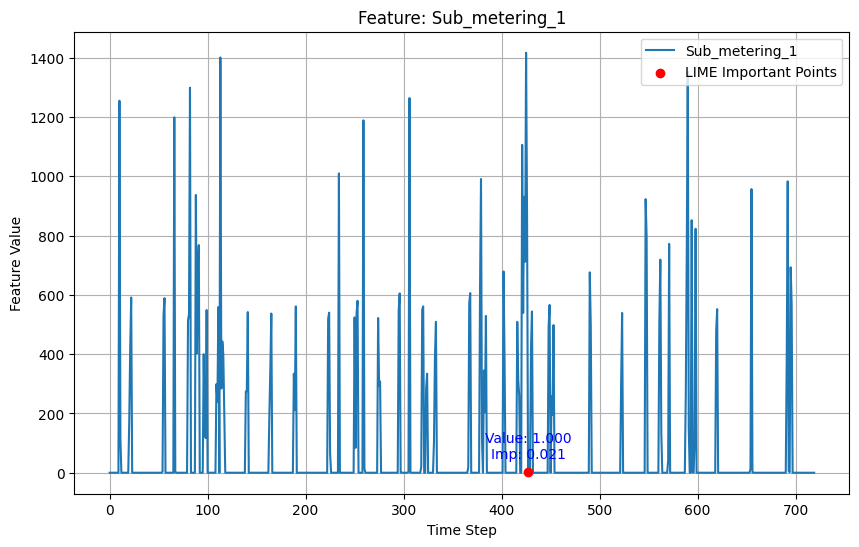


Feature: Sub_metering_1 - Detailed Information
Time Step: 427, Feature Value: 1.000, Importance: 0.021


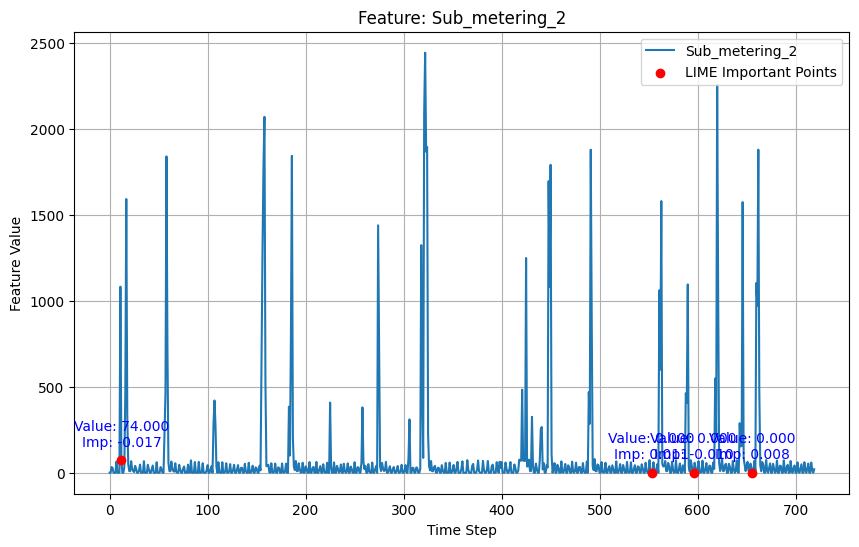


Feature: Sub_metering_2 - Detailed Information
Time Step: 12, Feature Value: 74.000, Importance: -0.017
Time Step: 553, Feature Value: 0.000, Importance: 0.011
Time Step: 596, Feature Value: 0.000, Importance: -0.010
Time Step: 656, Feature Value: 0.000, Importance: 0.008


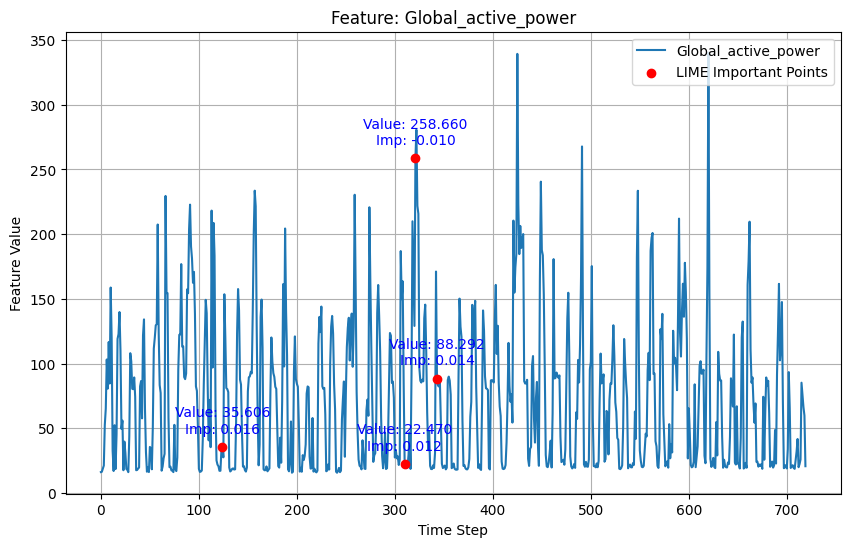


Feature: Global_active_power - Detailed Information
Time Step: 124, Feature Value: 35.606, Importance: 0.016
Time Step: 343, Feature Value: 88.292, Importance: 0.014
Time Step: 310, Feature Value: 22.470, Importance: 0.012
Time Step: 321, Feature Value: 258.660, Importance: -0.010


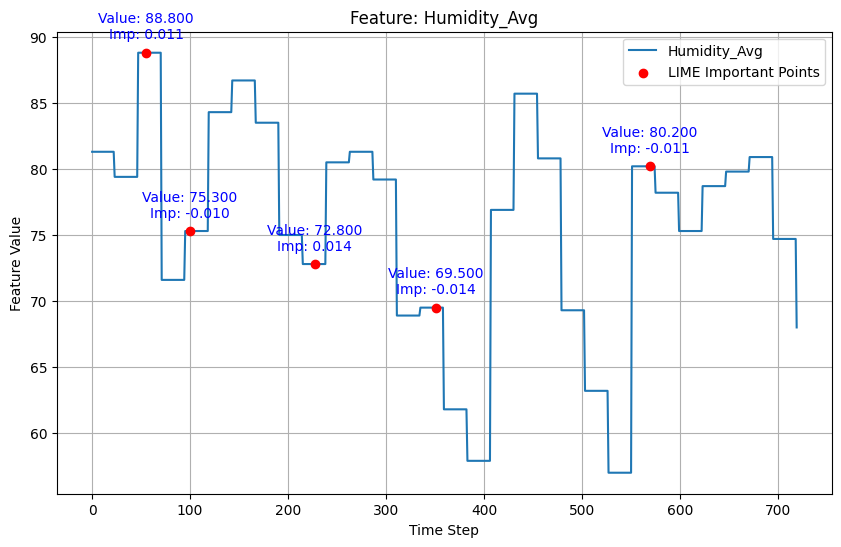


Feature: Humidity_Avg - Detailed Information
Time Step: 227, Feature Value: 72.800, Importance: 0.014
Time Step: 351, Feature Value: 69.500, Importance: -0.014
Time Step: 569, Feature Value: 80.200, Importance: -0.011
Time Step: 55, Feature Value: 88.800, Importance: 0.011
Time Step: 100, Feature Value: 75.300, Importance: -0.010


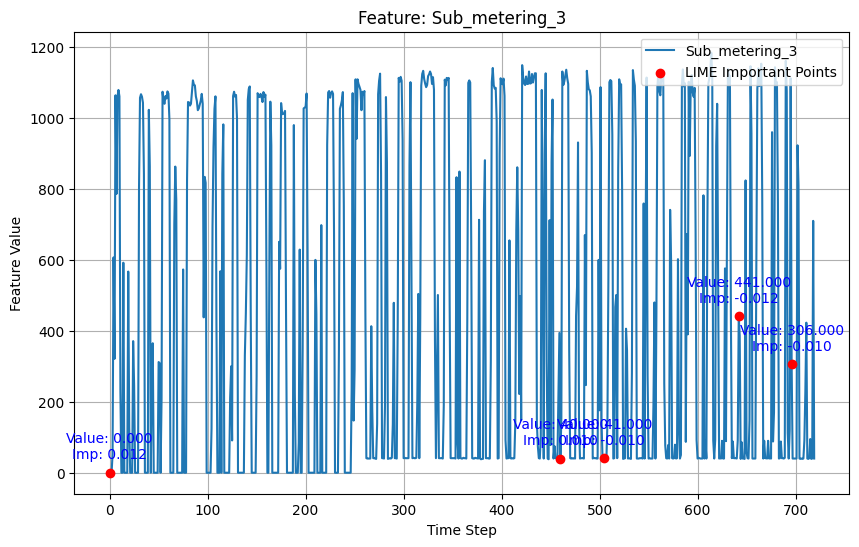


Feature: Sub_metering_3 - Detailed Information
Time Step: 0, Feature Value: 0.000, Importance: 0.012
Time Step: 642, Feature Value: 441.000, Importance: -0.012
Time Step: 696, Feature Value: 306.000, Importance: -0.010
Time Step: 460, Feature Value: 40.000, Importance: 0.010
Time Step: 505, Feature Value: 41.000, Importance: -0.010


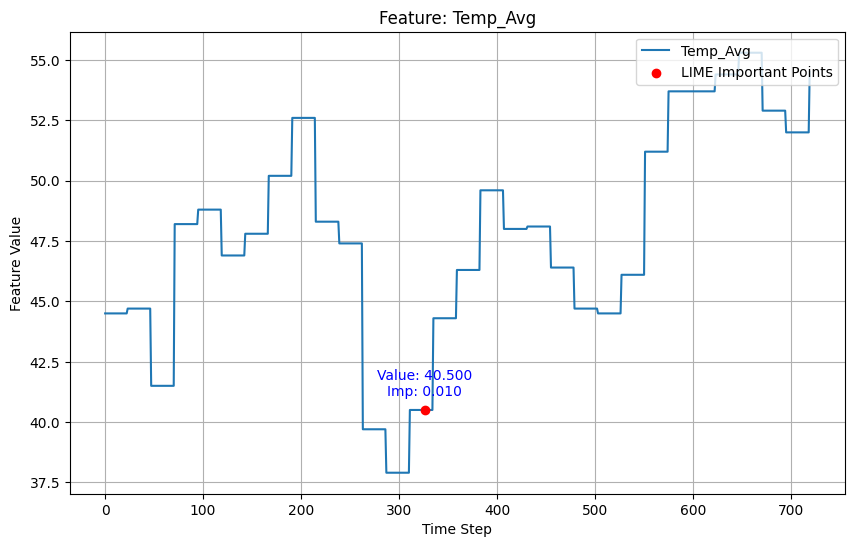


Feature: Temp_Avg - Detailed Information
Time Step: 326, Feature Value: 40.500, Importance: 0.010


In [18]:
if explainer != None:
    # 랜덤 샘플 추출 후, 주요 feature 시각화
    random_index = np.random.choice(len(eval_sequences)) 
    random_data_point = eval_sequences[random_index] 
    print('random_index: ', random_index)
    
    explanation = explainer.explain(random_data_point, 
                                    eval_sequences,
                                    num_features=20, 
                                    is_visual=True)

**주요 feature 추출**

In [19]:
lime_top_features = explainer.extract_important_features(eval_sequences, 
                                                          num_samples=num_samples,
                                                          top_n=top_n)

Feature keys in importance dictionary: dict_keys(['Global_active_power', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Temp_Avg', 'Humidity_Avg'])


Processing samples:   0%|                                                       | 0/300 [00:00<?, ?it/s]

Processing sample 1/300 (0.33%)
Current Top 5 features: Top1 Global_intensity (0.0594), Top2 Sub_metering_2 (0.0198), Top3 Sub_metering_1 (0.0185), Top4 Temp_Avg (0.0120), Top5 Global_active_power (0.0000)

Processing samples:   0%|▏                                              | 1/300 [00:02<10:39,  2.14s/it]

Processing sample 2/300 (0.67%)
Current Top 5 features: Top1 Global_intensity (0.0594), Top2 Humidity_Avg (0.0404), Top3 Sub_metering_2 (0.0346), Top4 Temp_Avg (0.0255), Top5 Sub_metering_1 (0.0185)

Processing samples:   1%|▎                                              | 2/300 [00:04<10:51,  2.19s/it]

Processing sample 3/300 (1.00%)
Current Top 5 features: Top1 Global_intensity (0.1038), Top2 Sub_metering_2 (0.0613), Top3 Humidity_Avg (0.0404), Top4 Temp_Avg (0.0389), Top5 Global_active_power (0.0265)

Processing samples:   1%|▍                                              | 3/300 [00:06<10:35,  2.14s/it]

Processing sample 4/300 (1.33%)
Current Top 5 features: Top1 Global_intensity (0.1407), Top2 Global_active_power (0.0759), Top3 Sub_metering_2 (0.0613), Top4 Humidity_Avg (0.0571), Top5 Temp_Avg (0.0562)

Processing samples:   1%|▋                                              | 4/300 [00:08<10:34,  2.15s/it]

Processing sample 5/300 (1.67%)
Current Top 5 features: Top1 Global_intensity (0.1678), Top2 Global_active_power (0.0999), Top3 Humidity_Avg (0.0850), Top4 Sub_metering_2 (0.0613), Top5 Temp_Avg (0.0562)

Processing samples:   2%|▊                                              | 5/300 [00:10<10:39,  2.17s/it]

Processing sample 6/300 (2.00%)
Current Top 5 features: Top1 Global_intensity (0.2057), Top2 Global_active_power (0.1157), Top3 Humidity_Avg (0.1146), Top4 Sub_metering_2 (0.0745), Top5 Sub_metering_3 (0.0679)

Processing samples:   2%|▉                                              | 6/300 [00:12<10:32,  2.15s/it]

Processing sample 7/300 (2.33%)
Current Top 5 features: Top1 Global_intensity (0.2375), Top2 Global_active_power (0.1323), Top3 Humidity_Avg (0.1290), Top4 Temp_Avg (0.0887), Top5 Sub_metering_3 (0.0855)

Processing samples:   2%|█                                              | 7/300 [00:15<10:29,  2.15s/it]

Processing sample 8/300 (2.67%)
Current Top 5 features: Top1 Global_intensity (0.3143), Top2 Global_active_power (0.1497), Top3 Humidity_Avg (0.1464), Top4 Temp_Avg (0.0887), Top5 Sub_metering_3 (0.0855)

Processing samples:   3%|█▎                                             | 8/300 [00:17<10:27,  2.15s/it]

Processing sample 9/300 (3.00%)
Current Top 5 features: Top1 Global_intensity (0.3143), Top2 Global_active_power (0.1951), Top3 Humidity_Avg (0.1700), Top4 Temp_Avg (0.1187), Top5 Sub_metering_3 (0.0855)

Processing samples:   3%|█▍                                             | 9/300 [00:19<10:25,  2.15s/it]

Processing sample 10/300 (3.33%)
Current Top 5 features: Top1 Global_intensity (0.3143), Top2 Global_active_power (0.1951), Top3 Humidity_Avg (0.1700), Top4 Temp_Avg (0.1282), Top5 Sub_metering_2 (0.1151)

Processing samples:   3%|█▌                                            | 10/300 [00:21<10:22,  2.15s/it]

Processing sample 11/300 (3.67%)
Current Top 5 features: Top1 Global_intensity (0.3275), Top2 Global_active_power (0.1951), Top3 Humidity_Avg (0.1843), Top4 Temp_Avg (0.1585), Top5 Sub_metering_2 (0.1535)

Processing samples:   4%|█▋                                            | 11/300 [00:23<10:24,  2.16s/it]

Processing sample 12/300 (4.00%)
Current Top 5 features: Top1 Global_intensity (0.3654), Top2 Global_active_power (0.2361), Top3 Humidity_Avg (0.1843), Top4 Temp_Avg (0.1727), Top5 Sub_metering_2 (0.1535)

Processing samples:   4%|█▊                                            | 12/300 [00:25<10:22,  2.16s/it]

Processing sample 13/300 (4.33%)
Current Top 5 features: Top1 Global_intensity (0.3931), Top2 Global_active_power (0.2361), Top3 Humidity_Avg (0.1962), Top4 Temp_Avg (0.1893), Top5 Sub_metering_2 (0.1821)

Processing samples:   4%|█▉                                            | 13/300 [00:28<10:21,  2.17s/it]

Processing sample 14/300 (4.67%)
Current Top 5 features: Top1 Global_intensity (0.4206), Top2 Global_active_power (0.2964), Top3 Temp_Avg (0.2163), Top4 Humidity_Avg (0.1962), Top5 Sub_metering_2 (0.1821)

Processing samples:   5%|██▏                                           | 14/300 [00:30<10:17,  2.16s/it]

Processing sample 15/300 (5.00%)
Current Top 5 features: Top1 Global_intensity (0.4597), Top2 Global_active_power (0.2964), Top3 Temp_Avg (0.2163), Top4 Humidity_Avg (0.2095), Top5 Sub_metering_2 (0.1992)

Processing samples:   5%|██▎                                           | 15/300 [00:32<10:11,  2.14s/it]

Processing sample 16/300 (5.33%)
Current Top 5 features: Top1 Global_intensity (0.5215), Top2 Global_active_power (0.3374), Top3 Humidity_Avg (0.2277), Top4 Temp_Avg (0.2163), Top5 Sub_metering_2 (0.1992)

Processing samples:   5%|██▍                                           | 16/300 [00:34<10:10,  2.15s/it]

Processing sample 17/300 (5.67%)
Current Top 5 features: Top1 Global_intensity (0.5464), Top2 Global_active_power (0.3768), Top3 Temp_Avg (0.2496), Top4 Humidity_Avg (0.2372), Top5 Sub_metering_2 (0.2102)

Processing samples:   6%|██▌                                           | 17/300 [00:36<10:10,  2.16s/it]

Processing sample 18/300 (6.00%)
Current Top 5 features: Top1 Global_intensity (0.6058), Top2 Global_active_power (0.3931), Top3 Temp_Avg (0.2496), Top4 Humidity_Avg (0.2475), Top5 Sub_metering_2 (0.2102)

Processing samples:   6%|██▊                                           | 18/300 [00:38<10:09,  2.16s/it]

Processing sample 19/300 (6.33%)
Current Top 5 features: Top1 Global_intensity (0.6461), Top2 Global_active_power (0.4077), Top3 Humidity_Avg (0.2817), Top4 Temp_Avg (0.2496), Top5 Sub_metering_2 (0.2263)

Processing samples:   6%|██▉                                           | 19/300 [00:40<10:10,  2.17s/it]

Processing sample 20/300 (6.67%)
Current Top 5 features: Top1 Global_intensity (0.6461), Top2 Global_active_power (0.4213), Top3 Humidity_Avg (0.2817), Top4 Temp_Avg (0.2816), Top5 Sub_metering_2 (0.2431)

Processing samples:   7%|███                                           | 20/300 [00:43<10:08,  2.17s/it]

Processing sample 21/300 (7.00%)
Current Top 5 features: Top1 Global_intensity (0.6616), Top2 Global_active_power (0.4496), Top3 Temp_Avg (0.3033), Top4 Humidity_Avg (0.2817), Top5 Sub_metering_2 (0.2662)

Processing samples:   7%|███▏                                          | 21/300 [00:45<10:05,  2.17s/it]

Processing sample 22/300 (7.33%)
Current Top 5 features: Top1 Global_intensity (0.7187), Top2 Global_active_power (0.5090), Top3 Temp_Avg (0.3184), Top4 Humidity_Avg (0.2817), Top5 Sub_metering_2 (0.2662)

Processing samples:   7%|███▎                                          | 22/300 [00:47<10:04,  2.17s/it]

Processing sample 23/300 (7.67%)
Current Top 5 features: Top1 Global_intensity (0.7446), Top2 Global_active_power (0.5561), Top3 Temp_Avg (0.3184), Top4 Humidity_Avg (0.3015), Top5 Sub_metering_2 (0.2786)

Processing samples:   8%|███▌                                          | 23/300 [00:49<09:57,  2.16s/it]

Processing sample 24/300 (8.00%)
Current Top 5 features: Top1 Global_intensity (0.7651), Top2 Global_active_power (0.6119), Top3 Temp_Avg (0.3184), Top4 Humidity_Avg (0.3015), Top5 Sub_metering_2 (0.2970)

Processing samples:   8%|███▋                                          | 24/300 [00:51<09:58,  2.17s/it]

Processing sample 25/300 (8.33%)
Current Top 5 features: Top1 Global_intensity (0.7990), Top2 Global_active_power (0.6119), Top3 Sub_metering_3 (0.3296), Top4 Temp_Avg (0.3184), Top5 Humidity_Avg (0.3126)

Processing samples:   8%|███▊                                          | 25/300 [00:54<09:59,  2.18s/it]

Processing sample 26/300 (8.67%)
Current Top 5 features: Top1 Global_intensity (0.8297), Top2 Global_active_power (0.6375), Top3 Sub_metering_3 (0.3296), Top4 Humidity_Avg (0.3263), Top5 Temp_Avg (0.3184)

Processing samples:   9%|███▉                                          | 26/300 [00:56<09:54,  2.17s/it]

Processing sample 27/300 (9.00%)
Current Top 5 features: Top1 Global_intensity (0.8699), Top2 Global_active_power (0.6836), Top3 Sub_metering_3 (0.3391), Top4 Sub_metering_2 (0.3302), Top5 Humidity_Avg (0.3263)

Processing samples:   9%|████▏                                         | 27/300 [00:58<09:56,  2.19s/it]

Processing sample 28/300 (9.33%)
Current Top 5 features: Top1 Global_intensity (0.9268), Top2 Global_active_power (0.7200), Top3 Sub_metering_3 (0.3391), Top4 Sub_metering_2 (0.3390), Top5 Humidity_Avg (0.3385)

Processing samples:   9%|████▎                                         | 28/300 [01:00<09:48,  2.16s/it]

Processing sample 29/300 (9.67%)
Current Top 5 features: Top1 Global_intensity (0.9268), Top2 Global_active_power (0.7470), Top3 Humidity_Avg (0.3721), Top4 Sub_metering_3 (0.3656), Top5 Sub_metering_2 (0.3390)

Processing samples:  10%|████▍                                         | 29/300 [01:02<09:45,  2.16s/it]

Processing sample 30/300 (10.00%)
Current Top 5 features: Top1 Global_intensity (0.9447), Top2 Global_active_power (0.7470), Top3 Sub_metering_3 (0.4284), Top4 Humidity_Avg (0.3867), Top5 Temp_Avg (0.3475)

Processing samples:  10%|████▌                                         | 30/300 [01:04<09:37,  2.14s/it]

Processing sample 31/300 (10.33%)
Current Top 5 features: Top1 Global_intensity (0.9447), Top2 Global_active_power (0.7580), Top3 Sub_metering_3 (0.4614), Top4 Temp_Avg (0.3885), Top5 Humidity_Avg (0.3867)

Processing samples:  10%|████▊                                         | 31/300 [01:06<09:36,  2.14s/it]

Processing sample 32/300 (10.67%)
Current Top 5 features: Top1 Global_intensity (0.9596), Top2 Global_active_power (0.7580), Top3 Sub_metering_3 (0.4783), Top4 Temp_Avg (0.4208), Top5 Sub_metering_2 (0.4008)

Processing samples:  11%|████▉                                         | 32/300 [01:09<09:36,  2.15s/it]

Processing sample 33/300 (11.00%)
Current Top 5 features: Top1 Global_intensity (0.9722), Top2 Global_active_power (0.7953), Top3 Sub_metering_3 (0.4938), Top4 Temp_Avg (0.4208), Top5 Humidity_Avg (0.4138)

Processing samples:  11%|█████                                         | 33/300 [01:11<09:37,  2.16s/it]

Processing sample 34/300 (11.33%)
Current Top 5 features: Top1 Global_intensity (0.9909), Top2 Global_active_power (0.8059), Top3 Sub_metering_3 (0.4938), Top4 Humidity_Avg (0.4527), Top5 Temp_Avg (0.4356)

Processing samples:  11%|█████▏                                        | 34/300 [01:13<09:35,  2.16s/it]

Processing sample 35/300 (11.67%)
Current Top 5 features: Top1 Global_intensity (0.9909), Top2 Global_active_power (0.8218), Top3 Sub_metering_3 (0.5121), Top4 Humidity_Avg (0.4820), Top5 Temp_Avg (0.4642)

Processing samples:  12%|█████▎                                        | 35/300 [01:15<09:35,  2.17s/it]

Processing sample 36/300 (12.00%)
Current Top 5 features: Top1 Global_intensity (1.0379), Top2 Global_active_power (0.8560), Top3 Sub_metering_3 (0.5433), Top4 Humidity_Avg (0.4820), Top5 Temp_Avg (0.4642)

Processing samples:  12%|█████▌                                        | 36/300 [01:17<09:33,  2.17s/it]

Processing sample 37/300 (12.33%)
Current Top 5 features: Top1 Global_intensity (1.0999), Top2 Global_active_power (0.8734), Top3 Sub_metering_3 (0.5433), Top4 Humidity_Avg (0.4956), Top5 Temp_Avg (0.4811)

Processing samples:  12%|█████▋                                        | 37/300 [01:19<09:33,  2.18s/it]

Processing sample 38/300 (12.67%)
Current Top 5 features: Top1 Global_intensity (1.1688), Top2 Global_active_power (0.8848), Top3 Sub_metering_3 (0.5619), Top4 Humidity_Avg (0.5066), Top5 Temp_Avg (0.4811)

Processing samples:  13%|█████▊                                        | 38/300 [01:22<09:35,  2.20s/it]

Processing sample 39/300 (13.00%)
Current Top 5 features: Top1 Global_intensity (1.2520), Top2 Global_active_power (0.9363), Top3 Sub_metering_3 (0.5619), Top4 Humidity_Avg (0.5066), Top5 Temp_Avg (0.4943)

Processing samples:  13%|█████▉                                        | 39/300 [01:24<09:32,  2.20s/it]

Processing sample 40/300 (13.33%)
Current Top 5 features: Top1 Global_intensity (1.2869), Top2 Global_active_power (0.9577), Top3 Sub_metering_3 (0.5777), Top4 Temp_Avg (0.5118), Top5 Humidity_Avg (0.5066)

Processing samples:  13%|██████▏                                       | 40/300 [01:26<09:26,  2.18s/it]

Processing sample 41/300 (13.67%)
Current Top 5 features: Top1 Global_intensity (1.3043), Top2 Global_active_power (0.9852), Top3 Sub_metering_3 (0.6111), Top4 Temp_Avg (0.5251), Top5 Humidity_Avg (0.5066)

Processing samples:  14%|██████▎                                       | 41/300 [01:28<09:21,  2.17s/it]

Processing sample 42/300 (14.00%)
Current Top 5 features: Top1 Global_intensity (1.3436), Top2 Global_active_power (0.9852), Top3 Sub_metering_3 (0.6111), Top4 Humidity_Avg (0.5360), Top5 Temp_Avg (0.5251)

Processing samples:  14%|██████▍                                       | 42/300 [01:30<09:17,  2.16s/it]

Processing sample 43/300 (14.33%)
Current Top 5 features: Top1 Global_intensity (1.4221), Top2 Global_active_power (1.0238), Top3 Sub_metering_3 (0.6275), Top4 Humidity_Avg (0.5360), Top5 Temp_Avg (0.5251)

Processing samples:  14%|██████▌                                       | 43/300 [01:33<09:16,  2.16s/it]

Processing sample 44/300 (14.67%)
Current Top 5 features: Top1 Global_intensity (1.4351), Top2 Global_active_power (1.0380), Top3 Sub_metering_3 (0.6275), Top4 Humidity_Avg (0.5787), Top5 Temp_Avg (0.5385)

Processing samples:  15%|██████▋                                       | 44/300 [01:35<09:12,  2.16s/it]

Processing sample 45/300 (15.00%)
Current Top 5 features: Top1 Global_intensity (1.4750), Top2 Global_active_power (1.0659), Top3 Sub_metering_3 (0.6275), Top4 Humidity_Avg (0.5787), Top5 Temp_Avg (0.5542)

Processing samples:  15%|██████▉                                       | 45/300 [01:37<09:09,  2.15s/it]

Processing sample 46/300 (15.33%)
Current Top 5 features: Top1 Global_intensity (1.5032), Top2 Global_active_power (1.1170), Top3 Sub_metering_3 (0.6275), Top4 Humidity_Avg (0.5787), Top5 Temp_Avg (0.5542)

Processing samples:  15%|███████                                       | 46/300 [01:39<09:06,  2.15s/it]

Processing sample 47/300 (15.67%)
Current Top 5 features: Top1 Global_intensity (1.5343), Top2 Global_active_power (1.1170), Top3 Sub_metering_3 (0.6275), Top4 Temp_Avg (0.6022), Top5 Humidity_Avg (0.5787)

Processing samples:  16%|███████▏                                      | 47/300 [01:41<09:05,  2.16s/it]

Processing sample 48/300 (16.00%)
Current Top 5 features: Top1 Global_intensity (1.5497), Top2 Global_active_power (1.1417), Top3 Sub_metering_3 (0.6411), Top4 Sub_metering_2 (0.6077), Top5 Temp_Avg (0.6022)

Processing samples:  16%|███████▎                                      | 48/300 [01:43<08:59,  2.14s/it]

Processing sample 49/300 (16.33%)
Current Top 5 features: Top1 Global_intensity (1.5644), Top2 Global_active_power (1.1711), Top3 Sub_metering_3 (0.6534), Top4 Temp_Avg (0.6202), Top5 Sub_metering_2 (0.6077)

Processing samples:  16%|███████▌                                      | 49/300 [01:45<08:54,  2.13s/it]

Processing sample 50/300 (16.67%)
Current Top 5 features: Top1 Global_intensity (1.5946), Top2 Global_active_power (1.2127), Top3 Sub_metering_3 (0.6638), Top4 Sub_metering_2 (0.6360), Top5 Temp_Avg (0.6202)

Processing samples:  17%|███████▋                                      | 50/300 [01:47<08:50,  2.12s/it]

Processing sample 51/300 (17.00%)
Current Top 5 features: Top1 Global_intensity (1.6069), Top2 Global_active_power (1.2248), Top3 Sub_metering_2 (0.6738), Top4 Sub_metering_3 (0.6638), Top5 Humidity_Avg (0.6372)

Processing samples:  17%|███████▊                                      | 51/300 [01:50<08:56,  2.16s/it]

Processing sample 52/300 (17.33%)
Current Top 5 features: Top1 Global_intensity (1.6209), Top2 Global_active_power (1.2421), Top3 Sub_metering_3 (0.7087), Top4 Sub_metering_2 (0.6738), Top5 Temp_Avg (0.6489)

Processing samples:  17%|███████▉                                      | 52/300 [01:52<08:57,  2.17s/it]

Processing sample 53/300 (17.67%)
Current Top 5 features: Top1 Global_intensity (1.6475), Top2 Global_active_power (1.2588), Top3 Sub_metering_3 (0.7249), Top4 Sub_metering_2 (0.6864), Top5 Temp_Avg (0.6680)

Processing samples:  18%|████████▏                                     | 53/300 [01:54<08:56,  2.17s/it]

Processing sample 54/300 (18.00%)
Current Top 5 features: Top1 Global_intensity (1.7131), Top2 Global_active_power (1.3066), Top3 Sub_metering_3 (0.7729), Top4 Sub_metering_2 (0.6864), Top5 Temp_Avg (0.6680)

Processing samples:  18%|████████▎                                     | 54/300 [01:56<08:52,  2.17s/it]

Processing sample 55/300 (18.33%)
Current Top 5 features: Top1 Global_intensity (1.7921), Top2 Global_active_power (1.3241), Top3 Sub_metering_3 (0.7885), Top4 Sub_metering_2 (0.6864), Top5 Temp_Avg (0.6793)

Processing samples:  18%|████████▍                                     | 55/300 [01:58<08:53,  2.18s/it]

Processing sample 56/300 (18.67%)
Current Top 5 features: Top1 Global_intensity (1.8163), Top2 Global_active_power (1.3472), Top3 Sub_metering_3 (0.8141), Top4 Temp_Avg (0.6922), Top5 Sub_metering_2 (0.6864)

Processing samples:  19%|████████▌                                     | 56/300 [02:01<08:50,  2.17s/it]

Processing sample 57/300 (19.00%)
Current Top 5 features: Top1 Global_intensity (1.8454), Top2 Global_active_power (1.3663), Top3 Sub_metering_3 (0.8308), Top4 Temp_Avg (0.7079), Top5 Sub_metering_2 (0.6864)

Processing samples:  19%|████████▋                                     | 57/300 [02:03<08:49,  2.18s/it]

Processing sample 58/300 (19.33%)
Current Top 5 features: Top1 Global_intensity (1.8614), Top2 Global_active_power (1.3830), Top3 Sub_metering_3 (0.8308), Top4 Temp_Avg (0.7208), Top5 Humidity_Avg (0.7191)

Processing samples:  19%|████████▉                                     | 58/300 [02:05<08:52,  2.20s/it]

Processing sample 59/300 (19.67%)
Current Top 5 features: Top1 Global_intensity (1.8832), Top2 Global_active_power (1.3830), Top3 Sub_metering_3 (0.8597), Top4 Humidity_Avg (0.7320), Top5 Temp_Avg (0.7208)

Processing samples:  20%|█████████                                     | 59/300 [02:07<08:48,  2.19s/it]

Processing sample 60/300 (20.00%)
Current Top 5 features: Top1 Global_intensity (1.8994), Top2 Global_active_power (1.3830), Top3 Sub_metering_3 (0.8760), Top4 Humidity_Avg (0.8027), Top5 Temp_Avg (0.7346)

Processing samples:  20%|█████████▏                                    | 60/300 [02:09<08:44,  2.18s/it]

Processing sample 61/300 (20.33%)
Current Top 5 features: Top1 Global_intensity (1.9235), Top2 Global_active_power (1.4212), Top3 Sub_metering_3 (0.8955), Top4 Humidity_Avg (0.8176), Top5 Temp_Avg (0.7630)

Processing samples:  20%|█████████▎                                    | 61/300 [02:12<08:41,  2.18s/it]

Processing sample 62/300 (20.67%)
Current Top 5 features: Top1 Global_intensity (1.9944), Top2 Global_active_power (1.4486), Top3 Sub_metering_3 (0.9086), Top4 Humidity_Avg (0.8301), Top5 Temp_Avg (0.7630)

Processing samples:  21%|█████████▌                                    | 62/300 [02:14<08:37,  2.18s/it]

Processing sample 63/300 (21.00%)
Current Top 5 features: Top1 Global_intensity (2.0125), Top2 Global_active_power (1.4645), Top3 Sub_metering_3 (0.9381), Top4 Humidity_Avg (0.8451), Top5 Temp_Avg (0.7754)

Processing samples:  21%|█████████▋                                    | 63/300 [02:16<08:35,  2.17s/it]

Processing sample 64/300 (21.33%)
Current Top 5 features: Top1 Global_intensity (2.0404), Top2 Global_active_power (1.4795), Top3 Sub_metering_3 (0.9652), Top4 Humidity_Avg (0.8451), Top5 Temp_Avg (0.7910)

Processing samples:  21%|█████████▊                                    | 64/300 [02:18<08:29,  2.16s/it]

Processing sample 65/300 (21.67%)
Current Top 5 features: Top1 Global_intensity (2.0749), Top2 Global_active_power (1.4795), Top3 Sub_metering_3 (0.9997), Top4 Humidity_Avg (0.8784), Top5 Temp_Avg (0.7910)

Processing samples:  22%|█████████▉                                    | 65/300 [02:20<08:28,  2.16s/it]

Processing sample 66/300 (22.00%)
Current Top 5 features: Top1 Global_intensity (2.0871), Top2 Global_active_power (1.5132), Top3 Sub_metering_3 (0.9997), Top4 Humidity_Avg (0.8900), Top5 Temp_Avg (0.8073)

Processing samples:  22%|██████████                                    | 66/300 [02:22<08:27,  2.17s/it]

Processing sample 67/300 (22.33%)
Current Top 5 features: Top1 Global_intensity (2.0871), Top2 Global_active_power (1.5247), Top3 Sub_metering_3 (1.0357), Top4 Humidity_Avg (0.9122), Top5 Temp_Avg (0.8220)

Processing samples:  22%|██████████▎                                   | 67/300 [02:25<08:28,  2.18s/it]

Processing sample 68/300 (22.67%)
Current Top 5 features: Top1 Global_intensity (2.1287), Top2 Global_active_power (1.5462), Top3 Sub_metering_3 (1.0579), Top4 Humidity_Avg (0.9122), Top5 Temp_Avg (0.8354)

Processing samples:  23%|██████████▍                                   | 68/300 [02:27<08:25,  2.18s/it]

Processing sample 69/300 (23.00%)
Current Top 5 features: Top1 Global_intensity (2.1542), Top2 Global_active_power (1.5708), Top3 Sub_metering_3 (1.0579), Top4 Humidity_Avg (0.9283), Top5 Sub_metering_2 (0.8471)

Processing samples:  23%|██████████▌                                   | 69/300 [02:29<08:22,  2.17s/it]

Processing sample 70/300 (23.33%)
Current Top 5 features: Top1 Global_intensity (2.1864), Top2 Global_active_power (1.5859), Top3 Sub_metering_3 (1.0711), Top4 Humidity_Avg (0.9283), Top5 Temp_Avg (0.8669)

Processing samples:  23%|██████████▋                                   | 70/300 [02:31<08:18,  2.17s/it]

Processing sample 71/300 (23.67%)
Current Top 5 features: Top1 Global_intensity (2.2543), Top2 Global_active_power (1.6309), Top3 Sub_metering_3 (1.1154), Top4 Humidity_Avg (0.9283), Top5 Temp_Avg (0.8669)

Processing samples:  24%|██████████▉                                   | 71/300 [02:33<08:12,  2.15s/it]

Processing sample 72/300 (24.00%)
Current Top 5 features: Top1 Global_intensity (2.2761), Top2 Global_active_power (1.6455), Top3 Sub_metering_3 (1.1734), Top4 Humidity_Avg (0.9283), Top5 Temp_Avg (0.8669)

Processing samples:  24%|███████████                                   | 72/300 [02:35<08:10,  2.15s/it]

Processing sample 73/300 (24.33%)
Current Top 5 features: Top1 Global_intensity (2.2889), Top2 Global_active_power (1.7181), Top3 Sub_metering_3 (1.1981), Top4 Humidity_Avg (0.9283), Top5 Sub_metering_2 (0.8741)

Processing samples:  24%|███████████▏                                  | 73/300 [02:37<08:10,  2.16s/it]

Processing sample 74/300 (24.67%)
Current Top 5 features: Top1 Global_intensity (2.2889), Top2 Global_active_power (1.7181), Top3 Sub_metering_3 (1.2428), Top4 Humidity_Avg (0.9283), Top5 Temp_Avg (0.9100)

Processing samples:  25%|███████████▎                                  | 74/300 [02:40<08:08,  2.16s/it]

Processing sample 75/300 (25.00%)
Current Top 5 features: Top1 Global_intensity (2.3750), Top2 Global_active_power (1.7282), Top3 Sub_metering_3 (1.2605), Top4 Humidity_Avg (0.9283), Top5 Temp_Avg (0.9100)

Processing samples:  25%|███████████▌                                  | 75/300 [02:42<08:04,  2.15s/it]

Processing sample 76/300 (25.33%)
Current Top 5 features: Top1 Global_intensity (2.4098), Top2 Global_active_power (1.7449), Top3 Sub_metering_3 (1.2713), Top4 Humidity_Avg (0.9640), Top5 Temp_Avg (0.9100)

Processing samples:  25%|███████████▋                                  | 76/300 [02:44<08:00,  2.14s/it]

Processing sample 77/300 (25.67%)
Current Top 5 features: Top1 Global_intensity (2.4603), Top2 Global_active_power (1.7661), Top3 Sub_metering_3 (1.2713), Top4 Humidity_Avg (0.9753), Top5 Temp_Avg (0.9300)

Processing samples:  26%|███████████▊                                  | 77/300 [02:46<07:57,  2.14s/it]

Processing sample 78/300 (26.00%)
Current Top 5 features: Top1 Global_intensity (2.4972), Top2 Global_active_power (1.7955), Top3 Sub_metering_3 (1.2713), Top4 Humidity_Avg (0.9753), Top5 Temp_Avg (0.9300)

Processing samples:  26%|███████████▉                                  | 78/300 [02:48<07:56,  2.14s/it]

Processing sample 79/300 (26.33%)
Current Top 5 features: Top1 Global_intensity (2.5265), Top2 Global_active_power (1.8118), Top3 Sub_metering_3 (1.2713), Top4 Humidity_Avg (0.9753), Top5 Temp_Avg (0.9667)

Processing samples:  26%|████████████                                  | 79/300 [02:50<07:56,  2.15s/it]

Processing sample 80/300 (26.67%)
Current Top 5 features: Top1 Global_intensity (2.5894), Top2 Global_active_power (1.8366), Top3 Sub_metering_3 (1.3065), Top4 Humidity_Avg (0.9753), Top5 Temp_Avg (0.9667)

Processing samples:  27%|████████████▎                                 | 80/300 [02:53<07:54,  2.16s/it]

Processing sample 81/300 (27.00%)
Current Top 5 features: Top1 Global_intensity (2.5894), Top2 Global_active_power (1.8518), Top3 Sub_metering_3 (1.3480), Top4 Humidity_Avg (1.0187), Top5 Temp_Avg (0.9667)

Processing samples:  27%|████████████▍                                 | 81/300 [02:55<07:53,  2.16s/it]

Processing sample 82/300 (27.33%)
Current Top 5 features: Top1 Global_intensity (2.6107), Top2 Global_active_power (1.8641), Top3 Sub_metering_3 (1.3480), Top4 Humidity_Avg (1.0330), Top5 Temp_Avg (0.9895)

Processing samples:  27%|████████████▌                                 | 82/300 [02:57<07:53,  2.17s/it]

Processing sample 83/300 (27.67%)
Current Top 5 features: Top1 Global_intensity (2.6107), Top2 Global_active_power (1.9243), Top3 Sub_metering_3 (1.3480), Top4 Humidity_Avg (1.0451), Top5 Temp_Avg (1.0219)

Processing samples:  28%|████████████▋                                 | 83/300 [02:59<07:55,  2.19s/it]

Processing sample 84/300 (28.00%)
Current Top 5 features: Top1 Global_intensity (2.6591), Top2 Global_active_power (1.9534), Top3 Sub_metering_3 (1.3621), Top4 Humidity_Avg (1.0569), Top5 Temp_Avg (1.0363)

Processing samples:  28%|████████████▉                                 | 84/300 [03:01<07:51,  2.18s/it]

Processing sample 85/300 (28.33%)
Current Top 5 features: Top1 Global_intensity (2.7086), Top2 Global_active_power (1.9652), Top3 Sub_metering_3 (1.3699), Top4 Humidity_Avg (1.0569), Top5 Temp_Avg (1.0491)

Processing samples:  28%|█████████████                                 | 85/300 [03:03<07:45,  2.17s/it]

Processing sample 86/300 (28.67%)
Current Top 5 features: Top1 Global_intensity (2.7259), Top2 Global_active_power (1.9799), Top3 Sub_metering_3 (1.3902), Top4 Humidity_Avg (1.1015), Top5 Temp_Avg (1.0663)

Processing samples:  29%|█████████████▏                                | 86/300 [03:06<07:43,  2.16s/it]

Processing sample 87/300 (29.00%)
Current Top 5 features: Top1 Global_intensity (2.7259), Top2 Global_active_power (1.9946), Top3 Sub_metering_3 (1.4412), Top4 Humidity_Avg (1.1167), Top5 Temp_Avg (1.0969)

Processing samples:  29%|█████████████▎                                | 87/300 [03:08<07:43,  2.17s/it]

Processing sample 88/300 (29.33%)
Current Top 5 features: Top1 Global_intensity (2.7633), Top2 Global_active_power (1.9946), Top3 Sub_metering_3 (1.4573), Top4 Humidity_Avg (1.1379), Top5 Temp_Avg (1.1273)

Processing samples:  29%|█████████████▍                                | 88/300 [03:10<07:43,  2.18s/it]

Processing sample 89/300 (29.67%)
Current Top 5 features: Top1 Global_intensity (2.8193), Top2 Global_active_power (2.0257), Top3 Sub_metering_3 (1.4789), Top4 Humidity_Avg (1.1379), Top5 Temp_Avg (1.1273)

Processing samples:  30%|█████████████▋                                | 89/300 [03:12<07:39,  2.18s/it]

Processing sample 90/300 (30.00%)
Current Top 5 features: Top1 Global_intensity (2.9069), Top2 Global_active_power (2.0636), Top3 Sub_metering_3 (1.5032), Top4 Humidity_Avg (1.1379), Top5 Temp_Avg (1.1273)

Processing samples:  30%|█████████████▊                                | 90/300 [03:14<07:33,  2.16s/it]

Processing sample 91/300 (30.33%)
Current Top 5 features: Top1 Global_intensity (2.9069), Top2 Global_active_power (2.0902), Top3 Sub_metering_3 (1.5174), Top4 Humidity_Avg (1.1771), Top5 Temp_Avg (1.1392)

Processing samples:  30%|█████████████▉                                | 91/300 [03:16<07:28,  2.15s/it]

Processing sample 92/300 (30.67%)
Current Top 5 features: Top1 Global_intensity (2.9628), Top2 Global_active_power (2.1385), Top3 Sub_metering_3 (1.5174), Top4 Humidity_Avg (1.1875), Top5 Temp_Avg (1.1392)

Processing samples:  31%|██████████████                                | 92/300 [03:19<07:24,  2.14s/it]

Processing sample 93/300 (31.00%)
Current Top 5 features: Top1 Global_intensity (3.0071), Top2 Global_active_power (2.1385), Top3 Sub_metering_3 (1.5174), Top4 Humidity_Avg (1.2026), Top5 Temp_Avg (1.1392)

Processing samples:  31%|██████████████▎                               | 93/300 [03:21<07:25,  2.15s/it]

Processing sample 94/300 (31.33%)
Current Top 5 features: Top1 Global_intensity (3.0248), Top2 Global_active_power (2.1599), Top3 Sub_metering_3 (1.5696), Top4 Humidity_Avg (1.2180), Top5 Temp_Avg (1.1547)

Processing samples:  31%|██████████████▍                               | 94/300 [03:23<07:23,  2.15s/it]

Processing sample 95/300 (31.67%)
Current Top 5 features: Top1 Global_intensity (3.0248), Top2 Global_active_power (2.1760), Top3 Sub_metering_3 (1.5836), Top4 Humidity_Avg (1.2305), Top5 Temp_Avg (1.1995)

Processing samples:  32%|██████████████▌                               | 95/300 [03:25<07:27,  2.18s/it]

Processing sample 96/300 (32.00%)
Current Top 5 features: Top1 Global_intensity (3.0418), Top2 Global_active_power (2.1889), Top3 Sub_metering_3 (1.5836), Top4 Humidity_Avg (1.2589), Top5 Temp_Avg (1.2291)

Processing samples:  32%|██████████████▋                               | 96/300 [03:27<07:25,  2.18s/it]

Processing sample 97/300 (32.33%)
Current Top 5 features: Top1 Global_intensity (3.0540), Top2 Global_active_power (2.2164), Top3 Sub_metering_3 (1.6078), Top4 Humidity_Avg (1.2773), Top5 Temp_Avg (1.2291)

Processing samples:  32%|██████████████▊                               | 97/300 [03:30<07:25,  2.20s/it]

Processing sample 98/300 (32.67%)
Current Top 5 features: Top1 Global_intensity (3.0860), Top2 Global_active_power (2.2537), Top3 Sub_metering_3 (1.6378), Top4 Humidity_Avg (1.2938), Top5 Temp_Avg (1.2508)

Processing samples:  33%|███████████████                               | 98/300 [03:32<07:22,  2.19s/it]

Processing sample 99/300 (33.00%)
Current Top 5 features: Top1 Global_intensity (3.1368), Top2 Global_active_power (2.2888), Top3 Sub_metering_3 (1.6567), Top4 Humidity_Avg (1.2938), Top5 Temp_Avg (1.2508)

Processing samples:  33%|███████████████▏                              | 99/300 [03:34<07:15,  2.17s/it]

Processing sample 100/300 (33.33%)
Current Top 5 features: Top1 Global_intensity (3.1821), Top2 Global_active_power (2.3425), Top3 Sub_metering_3 (1.6567), Top4 Humidity_Avg (1.2938), Top5 Temp_Avg (1.2508)

Processing samples:  33%|███████████████                              | 100/300 [03:36<07:12,  2.16s/it]

Processing sample 101/300 (33.67%)
Current Top 5 features: Top1 Global_intensity (3.2163), Top2 Global_active_power (2.3820), Top3 Sub_metering_3 (1.6729), Top4 Humidity_Avg (1.3267), Top5 Temp_Avg (1.2508)

Processing samples:  34%|███████████████▏                             | 101/300 [03:38<07:07,  2.15s/it]

Processing sample 102/300 (34.00%)
Current Top 5 features: Top1 Global_intensity (3.2163), Top2 Global_active_power (2.4004), Top3 Sub_metering_3 (1.7152), Top4 Humidity_Avg (1.3633), Top5 Temp_Avg (1.2670)

Processing samples:  34%|███████████████▎                             | 102/300 [03:40<07:04,  2.14s/it]

Processing sample 103/300 (34.33%)
Current Top 5 features: Top1 Global_intensity (3.2547), Top2 Global_active_power (2.4655), Top3 Sub_metering_3 (1.7152), Top4 Humidity_Avg (1.3788), Top5 Temp_Avg (1.2831)

Processing samples:  34%|███████████████▍                             | 103/300 [03:42<07:02,  2.14s/it]

Processing sample 104/300 (34.67%)
Current Top 5 features: Top1 Global_intensity (3.2705), Top2 Global_active_power (2.5115), Top3 Sub_metering_3 (1.7582), Top4 Humidity_Avg (1.3788), Top5 Temp_Avg (1.2831)

Processing samples:  35%|███████████████▌                             | 104/300 [03:45<07:02,  2.15s/it]

Processing sample 105/300 (35.00%)
Current Top 5 features: Top1 Global_intensity (3.3127), Top2 Global_active_power (2.5244), Top3 Sub_metering_3 (1.8147), Top4 Humidity_Avg (1.3788), Top5 Temp_Avg (1.2831)

Processing samples:  35%|███████████████▋                             | 105/300 [03:47<07:02,  2.17s/it]

Processing sample 106/300 (35.33%)
Current Top 5 features: Top1 Global_intensity (3.3127), Top2 Global_active_power (2.5718), Top3 Sub_metering_3 (1.8147), Top4 Humidity_Avg (1.3788), Top5 Temp_Avg (1.2970)

Processing samples:  35%|███████████████▉                             | 106/300 [03:49<07:00,  2.17s/it]

Processing sample 107/300 (35.67%)
Current Top 5 features: Top1 Global_intensity (3.3540), Top2 Global_active_power (2.5841), Top3 Sub_metering_3 (1.8512), Top4 Humidity_Avg (1.3788), Top5 Temp_Avg (1.2970)

Processing samples:  36%|████████████████                             | 107/300 [03:51<06:56,  2.16s/it]

Processing sample 108/300 (36.00%)
Current Top 5 features: Top1 Global_intensity (3.3833), Top2 Global_active_power (2.5841), Top3 Sub_metering_3 (1.8512), Top4 Humidity_Avg (1.4075), Top5 Temp_Avg (1.2970)

Processing samples:  36%|████████████████▏                            | 108/300 [03:53<06:56,  2.17s/it]

Processing sample 109/300 (36.33%)
Current Top 5 features: Top1 Global_intensity (3.3972), Top2 Global_active_power (2.6046), Top3 Sub_metering_3 (1.8852), Top4 Humidity_Avg (1.4242), Top5 Temp_Avg (1.3125)

Processing samples:  36%|████████████████▎                            | 109/300 [03:55<06:50,  2.15s/it]

Processing sample 110/300 (36.67%)
Current Top 5 features: Top1 Global_intensity (3.3972), Top2 Global_active_power (2.6046), Top3 Sub_metering_3 (1.9404), Top4 Humidity_Avg (1.4565), Top5 Temp_Avg (1.3431)

Processing samples:  37%|████████████████▌                            | 110/300 [03:57<06:48,  2.15s/it]

Processing sample 111/300 (37.00%)
Current Top 5 features: Top1 Global_intensity (3.4297), Top2 Global_active_power (2.6350), Top3 Sub_metering_3 (1.9598), Top4 Humidity_Avg (1.4565), Top5 Temp_Avg (1.3567)

Processing samples:  37%|████████████████▋                            | 111/300 [04:00<06:45,  2.15s/it]

Processing sample 112/300 (37.33%)
Current Top 5 features: Top1 Global_intensity (3.4774), Top2 Global_active_power (2.6571), Top3 Sub_metering_3 (1.9598), Top4 Humidity_Avg (1.4921), Top5 Temp_Avg (1.3567)

Processing samples:  37%|████████████████▊                            | 112/300 [04:02<06:43,  2.15s/it]

Processing sample 113/300 (37.67%)
Current Top 5 features: Top1 Global_intensity (3.4774), Top2 Global_active_power (2.6571), Top3 Sub_metering_3 (1.9933), Top4 Humidity_Avg (1.4921), Top5 Temp_Avg (1.4128)

Processing samples:  38%|████████████████▉                            | 113/300 [04:04<06:42,  2.15s/it]

Processing sample 114/300 (38.00%)
Current Top 5 features: Top1 Global_intensity (3.5302), Top2 Global_active_power (2.6698), Top3 Sub_metering_3 (1.9933), Top4 Humidity_Avg (1.5089), Top5 Temp_Avg (1.4128)

Processing samples:  38%|█████████████████                            | 114/300 [04:06<06:38,  2.14s/it]

Processing sample 115/300 (38.33%)
Current Top 5 features: Top1 Global_intensity (3.5417), Top2 Global_active_power (2.6998), Top3 Sub_metering_3 (2.0290), Top4 Humidity_Avg (1.5195), Top5 Temp_Avg (1.4128)

Processing samples:  38%|█████████████████▎                           | 115/300 [04:08<06:37,  2.15s/it]

Processing sample 116/300 (38.67%)
Current Top 5 features: Top1 Global_intensity (3.5670), Top2 Global_active_power (2.7350), Top3 Sub_metering_3 (2.0290), Top4 Humidity_Avg (1.5327), Top5 Temp_Avg (1.4309)

Processing samples:  39%|█████████████████▍                           | 116/300 [04:10<06:34,  2.14s/it]

Processing sample 117/300 (39.00%)
Current Top 5 features: Top1 Global_intensity (3.6350), Top2 Global_active_power (2.7872), Top3 Sub_metering_3 (2.0513), Top4 Humidity_Avg (1.5327), Top5 Temp_Avg (1.4435)

Processing samples:  39%|█████████████████▌                           | 117/300 [04:13<06:34,  2.15s/it]

Processing sample 118/300 (39.33%)
Current Top 5 features: Top1 Global_intensity (3.6490), Top2 Global_active_power (2.7978), Top3 Sub_metering_3 (2.0842), Top4 Humidity_Avg (1.5639), Top5 Temp_Avg (1.4435)

Processing samples:  39%|█████████████████▋                           | 118/300 [04:15<06:34,  2.17s/it]

Processing sample 119/300 (39.67%)
Current Top 5 features: Top1 Global_intensity (3.6635), Top2 Global_active_power (2.7978), Top3 Sub_metering_3 (2.1341), Top4 Humidity_Avg (1.5975), Top5 Temp_Avg (1.4435)

Processing samples:  40%|█████████████████▊                           | 119/300 [04:17<06:33,  2.18s/it]

Processing sample 120/300 (40.00%)
Current Top 5 features: Top1 Global_intensity (3.6924), Top2 Global_active_power (2.8106), Top3 Sub_metering_3 (2.1514), Top4 Humidity_Avg (1.6219), Top5 Temp_Avg (1.4435)

Processing samples:  40%|██████████████████                           | 120/300 [04:19<06:33,  2.19s/it]

Processing sample 121/300 (40.33%)
Current Top 5 features: Top1 Global_intensity (3.7252), Top2 Global_active_power (2.8368), Top3 Sub_metering_3 (2.1694), Top4 Humidity_Avg (1.6364), Top5 Temp_Avg (1.4435)

Processing samples:  40%|██████████████████▏                          | 121/300 [04:21<06:30,  2.18s/it]

Processing sample 122/300 (40.67%)
Current Top 5 features: Top1 Global_intensity (3.7506), Top2 Global_active_power (2.8368), Top3 Sub_metering_3 (2.1694), Top4 Humidity_Avg (1.6668), Top5 Temp_Avg (1.4435)

Processing samples:  41%|██████████████████▎                          | 122/300 [04:23<06:25,  2.17s/it]

Processing sample 123/300 (41.00%)
Current Top 5 features: Top1 Global_intensity (3.8214), Top2 Global_active_power (2.8799), Top3 Sub_metering_3 (2.2031), Top4 Humidity_Avg (1.6668), Top5 Temp_Avg (1.4435)

Processing samples:  41%|██████████████████▍                          | 123/300 [04:26<06:23,  2.17s/it]

Processing sample 124/300 (41.33%)
Current Top 5 features: Top1 Global_intensity (3.8751), Top2 Global_active_power (2.9005), Top3 Sub_metering_3 (2.2188), Top4 Humidity_Avg (1.6763), Top5 Temp_Avg (1.4435)

Processing samples:  41%|██████████████████▌                          | 124/300 [04:28<06:20,  2.16s/it]

Processing sample 125/300 (41.67%)
Current Top 5 features: Top1 Global_intensity (3.9444), Top2 Global_active_power (2.9520), Top3 Sub_metering_3 (2.2328), Top4 Humidity_Avg (1.6763), Top5 Temp_Avg (1.4435)

Processing samples:  42%|██████████████████▊                          | 125/300 [04:30<06:18,  2.16s/it]

Processing sample 126/300 (42.00%)
Current Top 5 features: Top1 Global_intensity (3.9689), Top2 Global_active_power (2.9702), Top3 Sub_metering_3 (2.2640), Top4 Humidity_Avg (1.6913), Top5 Temp_Avg (1.4435)

Processing samples:  42%|██████████████████▉                          | 126/300 [04:32<06:14,  2.15s/it]

Processing sample 127/300 (42.33%)
Current Top 5 features: Top1 Global_intensity (4.0221), Top2 Global_active_power (2.9702), Top3 Sub_metering_3 (2.3184), Top4 Humidity_Avg (1.6913), Top5 Temp_Avg (1.4435)

Processing samples:  42%|███████████████████                          | 127/300 [04:34<06:12,  2.16s/it]

Processing sample 128/300 (42.67%)
Current Top 5 features: Top1 Global_intensity (4.0360), Top2 Global_active_power (3.0149), Top3 Sub_metering_3 (2.3323), Top4 Humidity_Avg (1.7039), Top5 Temp_Avg (1.4435)

Processing samples:  43%|███████████████████▏                         | 128/300 [04:36<06:13,  2.17s/it]

Processing sample 129/300 (43.00%)
Current Top 5 features: Top1 Global_intensity (4.0903), Top2 Global_active_power (3.0149), Top3 Sub_metering_3 (2.3405), Top4 Humidity_Avg (1.7163), Top5 Temp_Avg (1.4607)

Processing samples:  43%|███████████████████▎                         | 129/300 [04:39<06:11,  2.18s/it]

Processing sample 130/300 (43.33%)
Current Top 5 features: Top1 Global_intensity (4.0903), Top2 Global_active_power (3.0586), Top3 Sub_metering_3 (2.3573), Top4 Humidity_Avg (1.7416), Top5 Temp_Avg (1.4607)

Processing samples:  43%|███████████████████▌                         | 130/300 [04:41<06:07,  2.16s/it]

Processing sample 131/300 (43.67%)
Current Top 5 features: Top1 Global_intensity (4.1731), Top2 Global_active_power (3.1028), Top3 Sub_metering_3 (2.3573), Top4 Humidity_Avg (1.7416), Top5 Temp_Avg (1.4607)

Processing samples:  44%|███████████████████▋                         | 131/300 [04:43<06:02,  2.15s/it]

Processing sample 132/300 (44.00%)
Current Top 5 features: Top1 Global_intensity (4.1731), Top2 Global_active_power (3.1517), Top3 Sub_metering_3 (2.3573), Top4 Humidity_Avg (1.7416), Top5 Temp_Avg (1.5068)

Processing samples:  44%|███████████████████▊                         | 132/300 [04:45<06:01,  2.15s/it]

Processing sample 133/300 (44.33%)
Current Top 5 features: Top1 Global_intensity (4.2005), Top2 Global_active_power (3.1517), Top3 Sub_metering_3 (2.3782), Top4 Humidity_Avg (1.7416), Top5 Temp_Avg (1.5224)

Processing samples:  44%|███████████████████▉                         | 133/300 [04:47<05:58,  2.15s/it]

Processing sample 134/300 (44.67%)
Current Top 5 features: Top1 Global_intensity (4.2239), Top2 Global_active_power (3.1517), Top3 Sub_metering_3 (2.3782), Top4 Humidity_Avg (1.7965), Top5 Temp_Avg (1.5356)

Processing samples:  45%|████████████████████                         | 134/300 [04:49<05:54,  2.14s/it]

Processing sample 135/300 (45.00%)
Current Top 5 features: Top1 Global_intensity (4.2746), Top2 Global_active_power (3.1788), Top3 Sub_metering_3 (2.3782), Top4 Humidity_Avg (1.7965), Top5 Temp_Avg (1.5502)

Processing samples:  45%|████████████████████▎                        | 135/300 [04:51<05:53,  2.14s/it]

Processing sample 136/300 (45.33%)
Current Top 5 features: Top1 Global_intensity (4.3134), Top2 Global_active_power (3.2486), Top3 Sub_metering_3 (2.4029), Top4 Humidity_Avg (1.7965), Top5 Temp_Avg (1.5502)

Processing samples:  45%|████████████████████▍                        | 136/300 [04:54<05:55,  2.17s/it]

Processing sample 137/300 (45.67%)
Current Top 5 features: Top1 Global_intensity (4.3556), Top2 Global_active_power (3.2723), Top3 Sub_metering_3 (2.4248), Top4 Humidity_Avg (1.7965), Top5 Temp_Avg (1.5810)

Processing samples:  46%|████████████████████▌                        | 137/300 [04:56<05:55,  2.18s/it]

Processing sample 138/300 (46.00%)
Current Top 5 features: Top1 Global_intensity (4.3864), Top2 Global_active_power (3.3055), Top3 Sub_metering_3 (2.4455), Top4 Humidity_Avg (1.8078), Top5 Temp_Avg (1.5810)

Processing samples:  46%|████████████████████▋                        | 138/300 [04:58<05:49,  2.16s/it]

Processing sample 139/300 (46.33%)
Current Top 5 features: Top1 Global_intensity (4.4137), Top2 Global_active_power (3.3222), Top3 Sub_metering_3 (2.4455), Top4 Humidity_Avg (1.8318), Top5 Temp_Avg (1.5810)

Processing samples:  46%|████████████████████▊                        | 139/300 [05:00<05:45,  2.15s/it]

Processing sample 140/300 (46.67%)
Current Top 5 features: Top1 Global_intensity (4.4312), Top2 Global_active_power (3.3222), Top3 Sub_metering_3 (2.4455), Top4 Humidity_Avg (1.8687), Top5 Temp_Avg (1.6190)

Processing samples:  47%|█████████████████████                        | 140/300 [05:02<05:42,  2.14s/it]

Processing sample 141/300 (47.00%)
Current Top 5 features: Top1 Global_intensity (4.4536), Top2 Global_active_power (3.3665), Top3 Sub_metering_3 (2.4850), Top4 Humidity_Avg (1.8848), Top5 Temp_Avg (1.6190)

Processing samples:  47%|█████████████████████▏                       | 141/300 [05:04<05:38,  2.13s/it]

Processing sample 142/300 (47.33%)
Current Top 5 features: Top1 Global_intensity (4.4782), Top2 Global_active_power (3.3836), Top3 Sub_metering_3 (2.5360), Top4 Humidity_Avg (1.8848), Top5 Temp_Avg (1.6328)

Processing samples:  47%|█████████████████████▎                       | 142/300 [05:07<05:40,  2.16s/it]

Processing sample 143/300 (47.67%)
Current Top 5 features: Top1 Global_intensity (4.5072), Top2 Global_active_power (3.4385), Top3 Sub_metering_3 (2.5568), Top4 Humidity_Avg (1.8848), Top5 Temp_Avg (1.6328)

Processing samples:  48%|█████████████████████▍                       | 143/300 [05:09<05:37,  2.15s/it]

Processing sample 144/300 (48.00%)
Current Top 5 features: Top1 Global_intensity (4.5489), Top2 Global_active_power (3.4522), Top3 Sub_metering_3 (2.5971), Top4 Humidity_Avg (1.8848), Top5 Temp_Avg (1.6328)

Processing samples:  48%|█████████████████████▌                       | 144/300 [05:11<05:38,  2.17s/it]

Processing sample 145/300 (48.33%)
Current Top 5 features: Top1 Global_intensity (4.5950), Top2 Global_active_power (3.5082), Top3 Sub_metering_3 (2.5971), Top4 Humidity_Avg (1.9004), Top5 Temp_Avg (1.6328)

Processing samples:  48%|█████████████████████▊                       | 145/300 [05:13<05:32,  2.15s/it]

Processing sample 146/300 (48.67%)
Current Top 5 features: Top1 Global_intensity (4.6150), Top2 Global_active_power (3.5216), Top3 Sub_metering_3 (2.6160), Top4 Humidity_Avg (1.9548), Top5 Temp_Avg (1.6496)

Processing samples:  49%|█████████████████████▉                       | 146/300 [05:15<05:29,  2.14s/it]

Processing sample 147/300 (49.00%)
Current Top 5 features: Top1 Global_intensity (4.6579), Top2 Global_active_power (3.5822), Top3 Sub_metering_3 (2.6619), Top4 Humidity_Avg (1.9548), Top5 Temp_Avg (1.6496)

Processing samples:  49%|██████████████████████                       | 147/300 [05:17<05:29,  2.15s/it]

Processing sample 148/300 (49.33%)
Current Top 5 features: Top1 Global_intensity (4.6832), Top2 Global_active_power (3.6504), Top3 Sub_metering_3 (2.6811), Top4 Humidity_Avg (1.9548), Top5 Temp_Avg (1.6496)

Processing samples:  49%|██████████████████████▏                      | 148/300 [05:19<05:30,  2.17s/it]

Processing sample 149/300 (49.67%)
Current Top 5 features: Top1 Global_intensity (4.7127), Top2 Global_active_power (3.6504), Top3 Sub_metering_3 (2.6930), Top4 Humidity_Avg (1.9672), Top5 Temp_Avg (1.6784)

Processing samples:  50%|██████████████████████▎                      | 149/300 [05:22<05:29,  2.18s/it]

Processing sample 150/300 (50.00%)
Current Top 5 features: Top1 Global_intensity (4.7683), Top2 Global_active_power (3.6719), Top3 Sub_metering_3 (2.6930), Top4 Humidity_Avg (1.9802), Top5 Temp_Avg (1.6912)

Processing samples:  50%|██████████████████████▌                      | 150/300 [05:24<05:28,  2.19s/it]

Processing sample 151/300 (50.33%)
Current Top 5 features: Top1 Global_intensity (4.8014), Top2 Global_active_power (3.6719), Top3 Sub_metering_3 (2.7140), Top4 Humidity_Avg (1.9971), Top5 Temp_Avg (1.7060)

Processing samples:  50%|██████████████████████▋                      | 151/300 [05:26<05:27,  2.20s/it]

Processing sample 152/300 (50.67%)
Current Top 5 features: Top1 Global_intensity (4.8345), Top2 Global_active_power (3.7051), Top3 Sub_metering_3 (2.7301), Top4 Humidity_Avg (2.0074), Top5 Temp_Avg (1.7258)

Processing samples:  51%|██████████████████████▊                      | 152/300 [05:28<05:21,  2.17s/it]

Processing sample 153/300 (51.00%)
Current Top 5 features: Top1 Global_intensity (4.8494), Top2 Global_active_power (3.7051), Top3 Sub_metering_3 (2.7601), Top4 Humidity_Avg (2.0243), Top5 Temp_Avg (1.7702)

Processing samples:  51%|██████████████████████▉                      | 153/300 [05:30<05:19,  2.17s/it]

Processing sample 154/300 (51.33%)
Current Top 5 features: Top1 Global_intensity (4.8779), Top2 Global_active_power (3.7260), Top3 Sub_metering_3 (2.7747), Top4 Humidity_Avg (2.0419), Top5 Temp_Avg (1.7702)

Processing samples:  51%|███████████████████████                      | 154/300 [05:33<05:19,  2.19s/it]

Processing sample 155/300 (51.67%)
Current Top 5 features: Top1 Global_intensity (4.9050), Top2 Global_active_power (3.7612), Top3 Sub_metering_3 (2.7747), Top4 Humidity_Avg (2.0591), Top5 Temp_Avg (1.7702)

Processing samples:  52%|███████████████████████▎                     | 155/300 [05:35<05:21,  2.21s/it]

Processing sample 156/300 (52.00%)
Current Top 5 features: Top1 Global_intensity (4.9197), Top2 Global_active_power (3.8153), Top3 Sub_metering_3 (2.7925), Top4 Humidity_Avg (2.0759), Top5 Temp_Avg (1.7702)

Processing samples:  52%|███████████████████████▍                     | 156/300 [05:37<05:15,  2.19s/it]

Processing sample 157/300 (52.33%)
Current Top 5 features: Top1 Global_intensity (4.9436), Top2 Global_active_power (3.8153), Top3 Sub_metering_3 (2.8055), Top4 Humidity_Avg (2.1063), Top5 Temp_Avg (1.7886)

Processing samples:  52%|███████████████████████▌                     | 157/300 [05:39<05:12,  2.18s/it]

Processing sample 158/300 (52.67%)
Current Top 5 features: Top1 Global_intensity (4.9436), Top2 Global_active_power (3.8153), Top3 Sub_metering_3 (2.8429), Top4 Humidity_Avg (2.1063), Top5 Temp_Avg (1.7978)

Processing samples:  53%|███████████████████████▋                     | 158/300 [05:41<05:11,  2.19s/it]

Processing sample 159/300 (53.00%)
Current Top 5 features: Top1 Global_intensity (5.0107), Top2 Global_active_power (3.8153), Top3 Sub_metering_3 (2.8596), Top4 Humidity_Avg (2.1063), Top5 Temp_Avg (1.8294)

Processing samples:  53%|███████████████████████▊                     | 159/300 [05:44<05:07,  2.18s/it]

Processing sample 160/300 (53.33%)
Current Top 5 features: Top1 Global_intensity (5.0107), Top2 Global_active_power (3.8815), Top3 Sub_metering_3 (2.8596), Top4 Humidity_Avg (2.1215), Top5 Temp_Avg (1.8441)

Processing samples:  53%|████████████████████████                     | 160/300 [05:46<05:02,  2.16s/it]

Processing sample 161/300 (53.67%)
Current Top 5 features: Top1 Global_intensity (5.0451), Top2 Global_active_power (3.8942), Top3 Sub_metering_3 (2.8596), Top4 Humidity_Avg (2.1341), Top5 Temp_Avg (1.8776)

Processing samples:  54%|████████████████████████▏                    | 161/300 [05:48<05:00,  2.16s/it]

Processing sample 162/300 (54.00%)
Current Top 5 features: Top1 Global_intensity (5.1167), Top2 Global_active_power (3.9386), Top3 Sub_metering_3 (2.8741), Top4 Humidity_Avg (2.1341), Top5 Temp_Avg (1.8776)

Processing samples:  54%|████████████████████████▎                    | 162/300 [05:50<04:59,  2.17s/it]

Processing sample 163/300 (54.33%)
Current Top 5 features: Top1 Global_intensity (5.1349), Top2 Global_active_power (3.9386), Top3 Sub_metering_3 (2.8912), Top4 Humidity_Avg (2.1740), Top5 Temp_Avg (1.8904)

Processing samples:  54%|████████████████████████▍                    | 163/300 [05:52<04:56,  2.16s/it]

Processing sample 164/300 (54.67%)
Current Top 5 features: Top1 Global_intensity (5.1667), Top2 Global_active_power (3.9971), Top3 Sub_metering_3 (2.9337), Top4 Humidity_Avg (2.1740), Top5 Temp_Avg (1.8904)

Processing samples:  55%|████████████████████████▌                    | 164/300 [05:54<04:55,  2.17s/it]

Processing sample 165/300 (55.00%)
Current Top 5 features: Top1 Global_intensity (5.1918), Top2 Global_active_power (4.0447), Top3 Sub_metering_3 (2.9717), Top4 Humidity_Avg (2.1926), Top5 Temp_Avg (1.8904)

Processing samples:  55%|████████████████████████▊                    | 165/300 [05:57<04:54,  2.18s/it]

Processing sample 166/300 (55.33%)
Current Top 5 features: Top1 Global_intensity (5.2127), Top2 Global_active_power (4.0565), Top3 Sub_metering_3 (2.9875), Top4 Humidity_Avg (2.2080), Top5 Temp_Avg (1.9039)

Processing samples:  55%|████████████████████████▉                    | 166/300 [05:59<04:51,  2.18s/it]

Processing sample 167/300 (55.67%)
Current Top 5 features: Top1 Global_intensity (5.2510), Top2 Global_active_power (4.1079), Top3 Sub_metering_3 (2.9875), Top4 Humidity_Avg (2.2529), Top5 Temp_Avg (1.9039)

Processing samples:  56%|█████████████████████████                    | 167/300 [06:01<04:51,  2.19s/it]

Processing sample 168/300 (56.00%)
Current Top 5 features: Top1 Global_intensity (5.2646), Top2 Global_active_power (4.1361), Top3 Sub_metering_3 (2.9995), Top4 Humidity_Avg (2.2529), Top5 Temp_Avg (1.9519)

Processing samples:  56%|█████████████████████████▏                   | 168/300 [06:03<04:47,  2.18s/it]

Processing sample 169/300 (56.33%)
Current Top 5 features: Top1 Global_intensity (5.2646), Top2 Global_active_power (4.1582), Top3 Sub_metering_3 (3.0183), Top4 Humidity_Avg (2.2669), Top5 Temp_Avg (1.9519)

Processing samples:  56%|█████████████████████████▎                   | 169/300 [06:05<04:43,  2.17s/it]

Processing sample 170/300 (56.67%)
Current Top 5 features: Top1 Global_intensity (5.3060), Top2 Global_active_power (4.2286), Top3 Sub_metering_3 (3.0183), Top4 Humidity_Avg (2.2801), Top5 Temp_Avg (1.9622)

Processing samples:  57%|█████████████████████████▌                   | 170/300 [06:07<04:39,  2.15s/it]

Processing sample 171/300 (57.00%)
Current Top 5 features: Top1 Global_intensity (5.3390), Top2 Global_active_power (4.2379), Top3 Sub_metering_3 (3.0183), Top4 Humidity_Avg (2.2956), Top5 Temp_Avg (1.9759)

Processing samples:  57%|█████████████████████████▋                   | 171/300 [06:10<04:38,  2.16s/it]

Processing sample 172/300 (57.33%)
Current Top 5 features: Top1 Global_intensity (5.3534), Top2 Global_active_power (4.2802), Top3 Sub_metering_3 (3.0413), Top4 Humidity_Avg (2.3115), Top5 Temp_Avg (1.9946)

Processing samples:  57%|█████████████████████████▊                   | 172/300 [06:12<04:37,  2.17s/it]

Processing sample 173/300 (57.67%)
Current Top 5 features: Top1 Global_intensity (5.3700), Top2 Global_active_power (4.3074), Top3 Sub_metering_3 (3.0613), Top4 Humidity_Avg (2.3275), Top5 Temp_Avg (2.0140)

Processing samples:  58%|█████████████████████████▉                   | 173/300 [06:14<04:37,  2.18s/it]

Processing sample 174/300 (58.00%)
Current Top 5 features: Top1 Global_intensity (5.3930), Top2 Global_active_power (4.3490), Top3 Sub_metering_3 (3.0613), Top4 Humidity_Avg (2.3275), Top5 Temp_Avg (2.0478)

Processing samples:  58%|██████████████████████████                   | 174/300 [06:16<04:35,  2.19s/it]

Processing sample 175/300 (58.33%)
Current Top 5 features: Top1 Global_intensity (5.4310), Top2 Global_active_power (4.3490), Top3 Sub_metering_3 (3.0613), Top4 Humidity_Avg (2.3453), Top5 Temp_Avg (2.0968)

Processing samples:  58%|██████████████████████████▎                  | 175/300 [06:18<04:31,  2.17s/it]

Processing sample 176/300 (58.67%)
Current Top 5 features: Top1 Global_intensity (5.4582), Top2 Global_active_power (4.3894), Top3 Sub_metering_3 (3.1039), Top4 Humidity_Avg (2.3453), Top5 Temp_Avg (2.0968)

Processing samples:  59%|██████████████████████████▍                  | 176/300 [06:20<04:27,  2.16s/it]

Processing sample 177/300 (59.00%)
Current Top 5 features: Top1 Global_intensity (5.4698), Top2 Global_active_power (4.4206), Top3 Sub_metering_3 (3.1164), Top4 Humidity_Avg (2.3764), Top5 Temp_Avg (2.1067)

Processing samples:  59%|██████████████████████████▌                  | 177/300 [06:23<04:26,  2.17s/it]

Processing sample 178/300 (59.33%)
Current Top 5 features: Top1 Global_intensity (5.4698), Top2 Global_active_power (4.4323), Top3 Sub_metering_3 (3.1579), Top4 Humidity_Avg (2.3764), Top5 Temp_Avg (2.1379)

Processing samples:  59%|██████████████████████████▋                  | 178/300 [06:25<04:26,  2.18s/it]

Processing sample 179/300 (59.67%)
Current Top 5 features: Top1 Global_intensity (5.4829), Top2 Global_active_power (4.4838), Top3 Sub_metering_3 (3.1579), Top4 Humidity_Avg (2.3764), Top5 Temp_Avg (2.1488)

Processing samples:  60%|██████████████████████████▊                  | 179/300 [06:27<04:23,  2.18s/it]

Processing sample 180/300 (60.00%)
Current Top 5 features: Top1 Global_intensity (5.4829), Top2 Global_active_power (4.5340), Top3 Sub_metering_3 (3.1735), Top4 Humidity_Avg (2.3764), Top5 Temp_Avg (2.1488)

Processing samples:  60%|███████████████████████████                  | 180/300 [06:29<04:23,  2.20s/it]

Processing sample 181/300 (60.33%)
Current Top 5 features: Top1 Global_intensity (5.4947), Top2 Global_active_power (4.5480), Top3 Sub_metering_3 (3.2155), Top4 Humidity_Avg (2.3946), Top5 Temp_Avg (2.1615)

Processing samples:  60%|███████████████████████████▏                 | 181/300 [06:31<04:20,  2.19s/it]

Processing sample 182/300 (60.67%)
Current Top 5 features: Top1 Global_intensity (5.5428), Top2 Global_active_power (4.5952), Top3 Sub_metering_3 (3.2500), Top4 Humidity_Avg (2.3946), Top5 Temp_Avg (2.1770)

Processing samples:  61%|███████████████████████████▎                 | 182/300 [06:34<04:18,  2.19s/it]

Processing sample 183/300 (61.00%)
Current Top 5 features: Top1 Global_intensity (5.5428), Top2 Global_active_power (4.6318), Top3 Sub_metering_3 (3.2976), Top4 Humidity_Avg (2.4112), Top5 Temp_Avg (2.1939)

Processing samples:  61%|███████████████████████████▍                 | 183/300 [06:36<04:17,  2.20s/it]

Processing sample 184/300 (61.33%)
Current Top 5 features: Top1 Global_intensity (5.5612), Top2 Global_active_power (4.6780), Top3 Sub_metering_3 (3.3116), Top4 Humidity_Avg (2.4112), Top5 Temp_Avg (2.1939)

Processing samples:  61%|███████████████████████████▌                 | 184/300 [06:38<04:13,  2.19s/it]

Processing sample 185/300 (61.67%)
Current Top 5 features: Top1 Global_intensity (5.6129), Top2 Global_active_power (4.6966), Top3 Sub_metering_3 (3.3209), Top4 Humidity_Avg (2.4229), Top5 Temp_Avg (2.1939)

Processing samples:  62%|███████████████████████████▊                 | 185/300 [06:40<04:09,  2.17s/it]

Processing sample 186/300 (62.00%)
Current Top 5 features: Top1 Global_intensity (5.6391), Top2 Global_active_power (4.7490), Top3 Sub_metering_3 (3.3407), Top4 Humidity_Avg (2.4229), Top5 Temp_Avg (2.1939)

Processing samples:  62%|███████████████████████████▉                 | 186/300 [06:42<04:06,  2.17s/it]

Processing sample 187/300 (62.33%)
Current Top 5 features: Top1 Global_intensity (5.6591), Top2 Global_active_power (4.7814), Top3 Sub_metering_3 (3.3407), Top4 Humidity_Avg (2.4229), Top5 Temp_Avg (2.2276)

Processing samples:  62%|████████████████████████████                 | 187/300 [06:44<04:04,  2.17s/it]

Processing sample 188/300 (62.67%)
Current Top 5 features: Top1 Global_intensity (5.6591), Top2 Global_active_power (4.7990), Top3 Sub_metering_3 (3.3688), Top4 Humidity_Avg (2.4477), Top5 Temp_Avg (2.2276)

Processing samples:  63%|████████████████████████████▏                | 188/300 [06:47<04:04,  2.19s/it]

Processing sample 189/300 (63.00%)
Current Top 5 features: Top1 Global_intensity (5.6882), Top2 Global_active_power (4.8190), Top3 Sub_metering_3 (3.3820), Top4 Humidity_Avg (2.4477), Top5 Temp_Avg (2.2374)

Processing samples:  63%|████████████████████████████▎                | 189/300 [06:49<04:02,  2.18s/it]

Processing sample 190/300 (63.33%)
Current Top 5 features: Top1 Global_intensity (5.7283), Top2 Global_active_power (4.8592), Top3 Sub_metering_3 (3.3974), Top4 Humidity_Avg (2.4676), Top5 Temp_Avg (2.2528)

Processing samples:  63%|████████████████████████████▌                | 190/300 [06:51<03:59,  2.18s/it]

Processing sample 191/300 (63.67%)
Current Top 5 features: Top1 Global_intensity (5.7744), Top2 Global_active_power (4.8745), Top3 Sub_metering_3 (3.4127), Top4 Humidity_Avg (2.4676), Top5 Temp_Avg (2.2671)

Processing samples:  64%|████████████████████████████▋                | 191/300 [06:53<03:55,  2.16s/it]

Processing sample 192/300 (64.00%)
Current Top 5 features: Top1 Global_intensity (5.8062), Top2 Global_active_power (4.8745), Top3 Sub_metering_3 (3.4127), Top4 Humidity_Avg (2.4957), Top5 Temp_Avg (2.2671)

Processing samples:  64%|████████████████████████████▊                | 192/300 [06:55<03:51,  2.14s/it]

Processing sample 193/300 (64.33%)
Current Top 5 features: Top1 Global_intensity (5.8360), Top2 Global_active_power (4.8920), Top3 Sub_metering_3 (3.4355), Top4 Humidity_Avg (2.5067), Top5 Temp_Avg (2.2671)

Processing samples:  64%|████████████████████████████▉                | 193/300 [06:57<03:48,  2.13s/it]

Processing sample 194/300 (64.67%)
Current Top 5 features: Top1 Global_intensity (5.9051), Top2 Global_active_power (4.9400), Top3 Sub_metering_3 (3.4559), Top4 Humidity_Avg (2.5067), Top5 Temp_Avg (2.2671)

Processing samples:  65%|█████████████████████████████                | 194/300 [07:00<03:48,  2.15s/it]

Processing sample 195/300 (65.00%)
Current Top 5 features: Top1 Global_intensity (5.9301), Top2 Global_active_power (4.9400), Top3 Sub_metering_3 (3.4559), Top4 Humidity_Avg (2.5242), Top5 Temp_Avg (2.2869)

Processing samples:  65%|█████████████████████████████▎               | 195/300 [07:02<03:47,  2.16s/it]

Processing sample 196/300 (65.33%)
Current Top 5 features: Top1 Global_intensity (5.9702), Top2 Global_active_power (4.9573), Top3 Sub_metering_3 (3.4686), Top4 Humidity_Avg (2.5333), Top5 Temp_Avg (2.3029)

Processing samples:  65%|█████████████████████████████▍               | 196/300 [07:04<03:45,  2.16s/it]

Processing sample 197/300 (65.67%)
Current Top 5 features: Top1 Global_intensity (5.9950), Top2 Global_active_power (5.0019), Top3 Sub_metering_3 (3.5050), Top4 Humidity_Avg (2.5333), Top5 Temp_Avg (2.3029)

Processing samples:  66%|█████████████████████████████▌               | 197/300 [07:06<03:40,  2.15s/it]

Processing sample 198/300 (66.00%)
Current Top 5 features: Top1 Global_intensity (6.0553), Top2 Global_active_power (5.0417), Top3 Sub_metering_3 (3.5185), Top4 Humidity_Avg (2.5333), Top5 Temp_Avg (2.3183)

Processing samples:  66%|█████████████████████████████▋               | 198/300 [07:08<03:40,  2.16s/it]

Processing sample 199/300 (66.33%)
Current Top 5 features: Top1 Global_intensity (6.0728), Top2 Global_active_power (5.0904), Top3 Sub_metering_3 (3.5614), Top4 Humidity_Avg (2.5467), Top5 Temp_Avg (2.3183)

Processing samples:  66%|█████████████████████████████▊               | 199/300 [07:10<03:38,  2.16s/it]

Processing sample 200/300 (66.67%)
Current Top 5 features: Top1 Global_intensity (6.1476), Top2 Global_active_power (5.1066), Top3 Sub_metering_3 (3.5614), Top4 Humidity_Avg (2.5467), Top5 Temp_Avg (2.3295)

Processing samples:  67%|██████████████████████████████               | 200/300 [07:13<03:35,  2.16s/it]

Processing sample 201/300 (67.00%)
Current Top 5 features: Top1 Global_intensity (6.1699), Top2 Global_active_power (5.1066), Top3 Sub_metering_3 (3.5783), Top4 Humidity_Avg (2.5467), Top5 Temp_Avg (2.3665)

Processing samples:  67%|██████████████████████████████▏              | 201/300 [07:15<03:33,  2.15s/it]

Processing sample 202/300 (67.33%)
Current Top 5 features: Top1 Global_intensity (6.1832), Top2 Global_active_power (5.1390), Top3 Sub_metering_3 (3.6126), Top4 Humidity_Avg (2.5695), Top5 Temp_Avg (2.3665)

Processing samples:  67%|██████████████████████████████▎              | 202/300 [07:17<03:32,  2.17s/it]

Processing sample 203/300 (67.67%)
Current Top 5 features: Top1 Global_intensity (6.2295), Top2 Global_active_power (5.1817), Top3 Sub_metering_3 (3.6239), Top4 Humidity_Avg (2.5857), Top5 Temp_Avg (2.3665)

Processing samples:  68%|██████████████████████████████▍              | 203/300 [07:19<03:29,  2.16s/it]

Processing sample 204/300 (68.00%)
Current Top 5 features: Top1 Global_intensity (6.2295), Top2 Global_active_power (5.1817), Top3 Sub_metering_3 (3.6648), Top4 Humidity_Avg (2.6182), Top5 Temp_Avg (2.3665)

Processing samples:  68%|██████████████████████████████▌              | 204/300 [07:21<03:28,  2.17s/it]

Processing sample 205/300 (68.33%)
Current Top 5 features: Top1 Global_intensity (6.2295), Top2 Global_active_power (5.2182), Top3 Sub_metering_3 (3.6969), Top4 Humidity_Avg (2.6182), Top5 Temp_Avg (2.3965)

Processing samples:  68%|██████████████████████████████▊              | 205/300 [07:23<03:25,  2.16s/it]

Processing sample 206/300 (68.67%)
Current Top 5 features: Top1 Global_intensity (6.2523), Top2 Global_active_power (5.2313), Top3 Sub_metering_3 (3.7119), Top4 Humidity_Avg (2.6526), Top5 Temp_Avg (2.3965)

Processing samples:  69%|██████████████████████████████▉              | 206/300 [07:25<03:21,  2.14s/it]

Processing sample 207/300 (69.00%)
Current Top 5 features: Top1 Global_intensity (6.2782), Top2 Global_active_power (5.2438), Top3 Sub_metering_3 (3.7227), Top4 Humidity_Avg (2.6645), Top5 Temp_Avg (2.3965)

Processing samples:  69%|███████████████████████████████              | 207/300 [07:28<03:21,  2.17s/it]

Processing sample 208/300 (69.33%)
Current Top 5 features: Top1 Global_intensity (6.2782), Top2 Global_active_power (5.2879), Top3 Sub_metering_3 (3.7227), Top4 Humidity_Avg (2.6799), Top5 Temp_Avg (2.3965)

Processing samples:  69%|███████████████████████████████▏             | 208/300 [07:30<03:21,  2.19s/it]

Processing sample 209/300 (69.67%)
Current Top 5 features: Top1 Global_intensity (6.3470), Top2 Global_active_power (5.3326), Top3 Sub_metering_3 (3.7401), Top4 Humidity_Avg (2.6799), Top5 Temp_Avg (2.3965)

Processing samples:  70%|███████████████████████████████▎             | 209/300 [07:32<03:17,  2.17s/it]

Processing sample 210/300 (70.00%)
Current Top 5 features: Top1 Global_intensity (6.3594), Top2 Global_active_power (5.3502), Top3 Sub_metering_3 (3.7656), Top4 Humidity_Avg (2.6799), Top5 Temp_Avg (2.4098)

Processing samples:  70%|███████████████████████████████▍             | 210/300 [07:34<03:16,  2.19s/it]

Processing sample 211/300 (70.33%)
Current Top 5 features: Top1 Global_intensity (6.3594), Top2 Global_active_power (5.4109), Top3 Sub_metering_3 (3.7839), Top4 Humidity_Avg (2.6799), Top5 Sub_metering_2 (2.4184)

Processing samples:  70%|███████████████████████████████▋             | 211/300 [07:37<03:15,  2.20s/it]

Processing sample 212/300 (70.67%)
Current Top 5 features: Top1 Global_intensity (6.3807), Top2 Global_active_power (5.4376), Top3 Sub_metering_3 (3.8173), Top4 Humidity_Avg (2.6799), Top5 Sub_metering_2 (2.4476)

Processing samples:  71%|███████████████████████████████▊             | 212/300 [07:39<03:13,  2.19s/it]

Processing sample 213/300 (71.00%)
Current Top 5 features: Top1 Global_intensity (6.3937), Top2 Global_active_power (5.4767), Top3 Sub_metering_3 (3.8311), Top4 Humidity_Avg (2.6951), Top5 Sub_metering_2 (2.4565)

Processing samples:  71%|███████████████████████████████▉             | 213/300 [07:41<03:08,  2.17s/it]

Processing sample 214/300 (71.33%)
Current Top 5 features: Top1 Global_intensity (6.3937), Top2 Global_active_power (5.4767), Top3 Sub_metering_3 (3.8528), Top4 Humidity_Avg (2.6951), Top5 Temp_Avg (2.4809)

Processing samples:  71%|████████████████████████████████             | 214/300 [07:43<03:06,  2.16s/it]

Processing sample 215/300 (71.67%)
Current Top 5 features: Top1 Global_intensity (6.4467), Top2 Global_active_power (5.4874), Top3 Sub_metering_3 (3.8837), Top4 Humidity_Avg (2.6951), Top5 Temp_Avg (2.4924)

Processing samples:  72%|████████████████████████████████▎            | 215/300 [07:45<03:04,  2.17s/it]

Processing sample 216/300 (72.00%)
Current Top 5 features: Top1 Global_intensity (6.4946), Top2 Global_active_power (5.5254), Top3 Sub_metering_3 (3.9178), Top4 Humidity_Avg (2.7081), Top5 Temp_Avg (2.4924)

Processing samples:  72%|████████████████████████████████▍            | 216/300 [07:47<03:02,  2.18s/it]

Processing sample 217/300 (72.33%)
Current Top 5 features: Top1 Global_intensity (6.5538), Top2 Global_active_power (5.5474), Top3 Sub_metering_3 (3.9385), Top4 Humidity_Avg (2.7081), Top5 Temp_Avg (2.5084)

Processing samples:  72%|████████████████████████████████▌            | 217/300 [07:50<03:01,  2.18s/it]

Processing sample 218/300 (72.67%)
Current Top 5 features: Top1 Global_intensity (6.5702), Top2 Global_active_power (5.5734), Top3 Sub_metering_3 (3.9385), Top4 Humidity_Avg (2.7624), Top5 Temp_Avg (2.5084)

Processing samples:  73%|████████████████████████████████▋            | 218/300 [07:52<02:58,  2.18s/it]

Processing sample 219/300 (73.00%)
Current Top 5 features: Top1 Global_intensity (6.5950), Top2 Global_active_power (5.6009), Top3 Sub_metering_3 (3.9519), Top4 Humidity_Avg (2.7624), Top5 Temp_Avg (2.5084)

Processing samples:  73%|████████████████████████████████▊            | 219/300 [07:54<02:56,  2.18s/it]

Processing sample 220/300 (73.33%)
Current Top 5 features: Top1 Global_intensity (6.6250), Top2 Global_active_power (5.6009), Top3 Sub_metering_3 (3.9893), Top4 Humidity_Avg (2.7810), Top5 Sub_metering_2 (2.5288)

Processing samples:  73%|█████████████████████████████████            | 220/300 [07:56<02:54,  2.18s/it]

Processing sample 221/300 (73.67%)
Current Top 5 features: Top1 Global_intensity (6.6691), Top2 Global_active_power (5.6381), Top3 Sub_metering_3 (4.0230), Top4 Humidity_Avg (2.7961), Top5 Sub_metering_2 (2.5288)

Processing samples:  74%|█████████████████████████████████▏           | 221/300 [07:58<02:52,  2.18s/it]

Processing sample 222/300 (74.00%)
Current Top 5 features: Top1 Global_intensity (6.7189), Top2 Global_active_power (5.6628), Top3 Sub_metering_3 (4.0474), Top4 Humidity_Avg (2.7961), Top5 Sub_metering_2 (2.5449)

Processing samples:  74%|█████████████████████████████████▎           | 222/300 [08:00<02:50,  2.18s/it]

Processing sample 223/300 (74.33%)
Current Top 5 features: Top1 Global_intensity (6.7810), Top2 Global_active_power (5.6628), Top3 Sub_metering_3 (4.0658), Top4 Humidity_Avg (2.7961), Top5 Sub_metering_2 (2.5583)

Processing samples:  74%|█████████████████████████████████▍           | 223/300 [08:03<02:48,  2.19s/it]

Processing sample 224/300 (74.67%)
Current Top 5 features: Top1 Global_intensity (6.8098), Top2 Global_active_power (5.6790), Top3 Sub_metering_3 (4.0832), Top4 Humidity_Avg (2.7961), Top5 Sub_metering_2 (2.5881)

Processing samples:  75%|█████████████████████████████████▌           | 224/300 [08:05<02:46,  2.19s/it]

Processing sample 225/300 (75.00%)
Current Top 5 features: Top1 Global_intensity (6.8098), Top2 Global_active_power (5.6976), Top3 Sub_metering_3 (4.0951), Top4 Humidity_Avg (2.8341), Top5 Sub_metering_2 (2.6177)

Processing samples:  75%|█████████████████████████████████▊           | 225/300 [08:07<02:44,  2.19s/it]

Processing sample 226/300 (75.33%)
Current Top 5 features: Top1 Global_intensity (6.8098), Top2 Global_active_power (5.6976), Top3 Sub_metering_3 (4.0951), Top4 Humidity_Avg (2.8778), Top5 Sub_metering_2 (2.6580)

Processing samples:  75%|█████████████████████████████████▉           | 226/300 [08:09<02:41,  2.18s/it]

Processing sample 227/300 (75.67%)
Current Top 5 features: Top1 Global_intensity (6.8325), Top2 Global_active_power (5.7668), Top3 Sub_metering_3 (4.1114), Top4 Humidity_Avg (2.8963), Top5 Sub_metering_2 (2.6701)

Processing samples:  76%|██████████████████████████████████           | 227/300 [08:11<02:38,  2.17s/it]

Processing sample 228/300 (76.00%)
Current Top 5 features: Top1 Global_intensity (6.8325), Top2 Global_active_power (5.8017), Top3 Sub_metering_3 (4.1418), Top4 Humidity_Avg (2.9065), Top5 Sub_metering_2 (2.6701)

Processing samples:  76%|██████████████████████████████████▏          | 228/300 [08:14<02:37,  2.19s/it]

Processing sample 229/300 (76.33%)
Current Top 5 features: Top1 Global_intensity (6.8533), Top2 Global_active_power (5.8386), Top3 Sub_metering_3 (4.1581), Top4 Humidity_Avg (2.9212), Top5 Sub_metering_2 (2.6817)

Processing samples:  76%|██████████████████████████████████▎          | 229/300 [08:16<02:34,  2.18s/it]

Processing sample 230/300 (76.67%)
Current Top 5 features: Top1 Global_intensity (6.8647), Top2 Global_active_power (5.8386), Top3 Sub_metering_3 (4.1880), Top4 Humidity_Avg (2.9324), Top5 Sub_metering_2 (2.7135)

Processing samples:  77%|██████████████████████████████████▌          | 230/300 [08:18<02:31,  2.16s/it]

Processing sample 231/300 (77.00%)
Current Top 5 features: Top1 Global_intensity (6.8647), Top2 Global_active_power (5.8386), Top3 Sub_metering_3 (4.1880), Top4 Humidity_Avg (2.9775), Top5 Sub_metering_2 (2.7539)

Processing samples:  77%|██████████████████████████████████▋          | 231/300 [08:20<02:30,  2.18s/it]

Processing sample 232/300 (77.33%)
Current Top 5 features: Top1 Global_intensity (6.8647), Top2 Global_active_power (5.8642), Top3 Sub_metering_3 (4.2056), Top4 Humidity_Avg (2.9984), Top5 Sub_metering_2 (2.7872)

Processing samples:  77%|██████████████████████████████████▊          | 232/300 [08:22<02:27,  2.16s/it]

Processing sample 233/300 (77.67%)
Current Top 5 features: Top1 Global_intensity (6.9037), Top2 Global_active_power (5.9060), Top3 Sub_metering_3 (4.2056), Top4 Humidity_Avg (2.9984), Top5 Sub_metering_2 (2.8052)

Processing samples:  78%|██████████████████████████████████▉          | 233/300 [08:24<02:24,  2.16s/it]

Processing sample 234/300 (78.00%)
Current Top 5 features: Top1 Global_intensity (6.9316), Top2 Global_active_power (5.9358), Top3 Sub_metering_3 (4.2230), Top4 Humidity_Avg (3.0090), Top5 Sub_metering_2 (2.8177)

Processing samples:  78%|███████████████████████████████████          | 234/300 [08:26<02:23,  2.17s/it]

Processing sample 235/300 (78.33%)
Current Top 5 features: Top1 Global_intensity (6.9855), Top2 Global_active_power (5.9635), Top3 Sub_metering_3 (4.2706), Top4 Humidity_Avg (3.0090), Top5 Sub_metering_2 (2.8177)

Processing samples:  78%|███████████████████████████████████▎         | 235/300 [08:29<02:19,  2.15s/it]

Processing sample 236/300 (78.67%)
Current Top 5 features: Top1 Global_intensity (7.0200), Top2 Global_active_power (5.9635), Top3 Sub_metering_3 (4.3057), Top4 Humidity_Avg (3.0251), Top5 Sub_metering_2 (2.8327)

Processing samples:  79%|███████████████████████████████████▍         | 236/300 [08:31<02:17,  2.16s/it]

Processing sample 237/300 (79.00%)
Current Top 5 features: Top1 Global_intensity (7.0778), Top2 Global_active_power (6.0080), Top3 Sub_metering_3 (4.3057), Top4 Humidity_Avg (3.0251), Top5 Sub_metering_2 (2.8433)

Processing samples:  79%|███████████████████████████████████▌         | 237/300 [08:33<02:16,  2.17s/it]

Processing sample 238/300 (79.33%)
Current Top 5 features: Top1 Global_intensity (7.1073), Top2 Global_active_power (6.0400), Top3 Sub_metering_3 (4.3199), Top4 Humidity_Avg (3.0251), Top5 Sub_metering_2 (2.8745)

Processing samples:  79%|███████████████████████████████████▋         | 238/300 [08:35<02:13,  2.15s/it]

Processing sample 239/300 (79.67%)
Current Top 5 features: Top1 Global_intensity (7.1340), Top2 Global_active_power (6.0674), Top3 Sub_metering_3 (4.3199), Top4 Humidity_Avg (3.0379), Top5 Sub_metering_2 (2.8745)

Processing samples:  80%|███████████████████████████████████▊         | 239/300 [08:37<02:10,  2.14s/it]

Processing sample 240/300 (80.00%)
Current Top 5 features: Top1 Global_intensity (7.1617), Top2 Global_active_power (6.0826), Top3 Sub_metering_3 (4.3318), Top4 Humidity_Avg (3.0379), Top5 Sub_metering_2 (2.8869)

Processing samples:  80%|████████████████████████████████████         | 240/300 [08:39<02:08,  2.15s/it]

Processing sample 241/300 (80.33%)
Current Top 5 features: Top1 Global_intensity (7.1951), Top2 Global_active_power (6.0826), Top3 Sub_metering_3 (4.3426), Top4 Humidity_Avg (3.0379), Top5 Sub_metering_2 (2.9100)

Processing samples:  80%|████████████████████████████████████▏        | 241/300 [08:41<02:06,  2.14s/it]

Processing sample 242/300 (80.67%)
Current Top 5 features: Top1 Global_intensity (7.2250), Top2 Global_active_power (6.0954), Top3 Sub_metering_3 (4.3595), Top4 Humidity_Avg (3.0567), Top5 Sub_metering_2 (2.9100)

Processing samples:  81%|████████████████████████████████████▎        | 242/300 [08:44<02:04,  2.15s/it]

Processing sample 243/300 (81.00%)
Current Top 5 features: Top1 Global_intensity (7.2447), Top2 Global_active_power (6.1381), Top3 Sub_metering_3 (4.3910), Top4 Humidity_Avg (3.0567), Top5 Sub_metering_2 (2.9100)

Processing samples:  81%|████████████████████████████████████▍        | 243/300 [08:46<02:01,  2.14s/it]

Processing sample 244/300 (81.33%)
Current Top 5 features: Top1 Global_intensity (7.2447), Top2 Global_active_power (6.1638), Top3 Sub_metering_3 (4.4280), Top4 Humidity_Avg (3.0567), Top5 Sub_metering_2 (2.9100)

Processing samples:  81%|████████████████████████████████████▌        | 244/300 [08:48<01:59,  2.14s/it]

Processing sample 245/300 (81.67%)
Current Top 5 features: Top1 Global_intensity (7.2447), Top2 Global_active_power (6.1638), Top3 Sub_metering_3 (4.4560), Top4 Humidity_Avg (3.0957), Top5 Sub_metering_2 (2.9100)

Processing samples:  82%|████████████████████████████████████▊        | 245/300 [08:50<01:57,  2.14s/it]

Processing sample 246/300 (82.00%)
Current Top 5 features: Top1 Global_intensity (7.2623), Top2 Global_active_power (6.1986), Top3 Sub_metering_3 (4.4717), Top4 Humidity_Avg (3.1276), Top5 Sub_metering_2 (2.9100)

Processing samples:  82%|████████████████████████████████████▉        | 246/300 [08:52<01:56,  2.15s/it]

Processing sample 247/300 (82.33%)
Current Top 5 features: Top1 Global_intensity (7.2772), Top2 Global_active_power (6.2313), Top3 Sub_metering_3 (4.5093), Top4 Humidity_Avg (3.1276), Top5 Sub_metering_2 (2.9100)

Processing samples:  82%|█████████████████████████████████████        | 247/300 [08:54<01:54,  2.15s/it]

Processing sample 248/300 (82.67%)
Current Top 5 features: Top1 Global_intensity (7.3202), Top2 Global_active_power (6.2700), Top3 Sub_metering_3 (4.5233), Top4 Humidity_Avg (3.1276), Top5 Sub_metering_2 (2.9266)

Processing samples:  83%|█████████████████████████████████████▏       | 248/300 [08:57<01:52,  2.16s/it]

Processing sample 249/300 (83.00%)
Current Top 5 features: Top1 Global_intensity (7.3540), Top2 Global_active_power (6.2940), Top3 Sub_metering_3 (4.5587), Top4 Humidity_Avg (3.1276), Top5 Sub_metering_2 (2.9266)

Processing samples:  83%|█████████████████████████████████████▎       | 249/300 [08:59<01:49,  2.15s/it]

Processing sample 250/300 (83.33%)
Current Top 5 features: Top1 Global_intensity (7.3947), Top2 Global_active_power (6.3203), Top3 Sub_metering_3 (4.5587), Top4 Humidity_Avg (3.1397), Top5 Sub_metering_2 (2.9266)

Processing samples:  83%|█████████████████████████████████████▌       | 250/300 [09:01<01:48,  2.17s/it]

Processing sample 251/300 (83.67%)
Current Top 5 features: Top1 Global_intensity (7.4371), Top2 Global_active_power (6.3336), Top3 Sub_metering_3 (4.5715), Top4 Humidity_Avg (3.1455), Top5 Sub_metering_2 (2.9266)

Processing samples:  84%|█████████████████████████████████████▋       | 251/300 [09:03<01:46,  2.17s/it]

Processing sample 252/300 (84.00%)
Current Top 5 features: Top1 Global_intensity (7.4371), Top2 Global_active_power (6.3530), Top3 Sub_metering_3 (4.5715), Top4 Humidity_Avg (3.1718), Top5 Temp_Avg (2.9655)

Processing samples:  84%|█████████████████████████████████████▊       | 252/300 [09:05<01:43,  2.16s/it]

Processing sample 253/300 (84.33%)
Current Top 5 features: Top1 Global_intensity (7.4555), Top2 Global_active_power (6.3530), Top3 Sub_metering_3 (4.5818), Top4 Humidity_Avg (3.2088), Top5 Temp_Avg (2.9919)

Processing samples:  84%|█████████████████████████████████████▉       | 253/300 [09:07<01:40,  2.15s/it]

Processing sample 254/300 (84.67%)
Current Top 5 features: Top1 Global_intensity (7.4707), Top2 Global_active_power (6.3675), Top3 Sub_metering_3 (4.5966), Top4 Humidity_Avg (3.2377), Top5 Temp_Avg (2.9919)

Processing samples:  85%|██████████████████████████████████████       | 254/300 [09:09<01:38,  2.14s/it]

Processing sample 255/300 (85.00%)
Current Top 5 features: Top1 Global_intensity (7.4863), Top2 Global_active_power (6.3804), Top3 Sub_metering_3 (4.6085), Top4 Humidity_Avg (3.2855), Top5 Temp_Avg (2.9919)

Processing samples:  85%|██████████████████████████████████████▎      | 255/300 [09:12<01:36,  2.14s/it]

Processing sample 256/300 (85.33%)
Current Top 5 features: Top1 Global_intensity (7.5378), Top2 Global_active_power (6.4025), Top3 Sub_metering_3 (4.6405), Top4 Humidity_Avg (3.2855), Top5 Temp_Avg (3.0060)

Processing samples:  85%|██████████████████████████████████████▍      | 256/300 [09:14<01:33,  2.13s/it]

Processing sample 257/300 (85.67%)
Current Top 5 features: Top1 Global_intensity (7.5378), Top2 Global_active_power (6.4239), Top3 Sub_metering_3 (4.6580), Top4 Humidity_Avg (3.3351), Top5 Temp_Avg (3.0237)

Processing samples:  86%|██████████████████████████████████████▌      | 257/300 [09:16<01:31,  2.13s/it]

Processing sample 258/300 (86.00%)
Current Top 5 features: Top1 Global_intensity (7.5671), Top2 Global_active_power (6.4394), Top3 Sub_metering_3 (4.6801), Top4 Humidity_Avg (3.3351), Top5 Temp_Avg (3.0237)

Processing samples:  86%|██████████████████████████████████████▋      | 258/300 [09:18<01:29,  2.14s/it]

Processing sample 259/300 (86.33%)
Current Top 5 features: Top1 Global_intensity (7.5984), Top2 Global_active_power (6.4702), Top3 Sub_metering_3 (4.6948), Top4 Humidity_Avg (3.3351), Top5 Temp_Avg (3.0528)

Processing samples:  86%|██████████████████████████████████████▊      | 259/300 [09:20<01:27,  2.13s/it]

Processing sample 260/300 (86.67%)
Current Top 5 features: Top1 Global_intensity (7.6111), Top2 Global_active_power (6.4702), Top3 Sub_metering_3 (4.6948), Top4 Humidity_Avg (3.3351), Top5 Temp_Avg (3.0864)

Processing samples:  87%|███████████████████████████████████████      | 260/300 [09:22<01:25,  2.14s/it]

Processing sample 261/300 (87.00%)
Current Top 5 features: Top1 Global_intensity (7.6245), Top2 Global_active_power (6.4864), Top3 Sub_metering_3 (4.7076), Top4 Humidity_Avg (3.3492), Top5 Temp_Avg (3.1221)

Processing samples:  87%|███████████████████████████████████████▏     | 261/300 [09:24<01:23,  2.14s/it]

Processing sample 262/300 (87.33%)
Current Top 5 features: Top1 Global_intensity (7.6733), Top2 Global_active_power (6.4864), Top3 Sub_metering_3 (4.7076), Top4 Humidity_Avg (3.3492), Top5 Temp_Avg (3.1404)

Processing samples:  87%|███████████████████████████████████████▎     | 262/300 [09:27<01:21,  2.15s/it]

Processing sample 263/300 (87.67%)
Current Top 5 features: Top1 Global_intensity (7.7005), Top2 Global_active_power (6.4864), Top3 Sub_metering_3 (4.7364), Top4 Humidity_Avg (3.3928), Top5 Temp_Avg (3.1404)

Processing samples:  88%|███████████████████████████████████████▍     | 263/300 [09:29<01:19,  2.15s/it]

Processing sample 264/300 (88.00%)
Current Top 5 features: Top1 Global_intensity (7.7005), Top2 Global_active_power (6.4864), Top3 Sub_metering_3 (4.7985), Top4 Humidity_Avg (3.4064), Top5 Temp_Avg (3.1538)

Processing samples:  88%|███████████████████████████████████████▌     | 264/300 [09:31<01:17,  2.16s/it]

Processing sample 265/300 (88.33%)
Current Top 5 features: Top1 Global_intensity (7.7673), Top2 Global_active_power (6.4864), Top3 Sub_metering_3 (4.7985), Top4 Humidity_Avg (3.4211), Top5 Temp_Avg (3.1706)

Processing samples:  88%|███████████████████████████████████████▊     | 265/300 [09:33<01:15,  2.17s/it]

Processing sample 266/300 (88.67%)
Current Top 5 features: Top1 Global_intensity (7.7820), Top2 Global_active_power (6.5011), Top3 Sub_metering_3 (4.8253), Top4 Humidity_Avg (3.4690), Top5 Temp_Avg (3.1706)

Processing samples:  89%|███████████████████████████████████████▉     | 266/300 [09:35<01:14,  2.18s/it]

Processing sample 267/300 (89.00%)
Current Top 5 features: Top1 Global_intensity (7.8228), Top2 Global_active_power (6.5513), Top3 Sub_metering_3 (4.8627), Top4 Humidity_Avg (3.4690), Top5 Temp_Avg (3.1706)

Processing samples:  89%|████████████████████████████████████████     | 267/300 [09:38<01:12,  2.18s/it]

Processing sample 268/300 (89.33%)
Current Top 5 features: Top1 Global_intensity (7.8372), Top2 Global_active_power (6.5651), Top3 Sub_metering_3 (4.8955), Top4 Humidity_Avg (3.5106), Top5 Temp_Avg (3.1706)

Processing samples:  89%|████████████████████████████████████████▏    | 268/300 [09:40<01:09,  2.18s/it]

Processing sample 269/300 (89.67%)
Current Top 5 features: Top1 Global_intensity (7.8825), Top2 Global_active_power (6.6065), Top3 Sub_metering_3 (4.9295), Top4 Humidity_Avg (3.5106), Top5 Sub_metering_2 (3.1747)

Processing samples:  90%|████████████████████████████████████████▎    | 269/300 [09:42<01:07,  2.18s/it]

Processing sample 270/300 (90.00%)
Current Top 5 features: Top1 Global_intensity (7.8825), Top2 Global_active_power (6.6214), Top3 Sub_metering_3 (4.9295), Top4 Humidity_Avg (3.5396), Top5 Sub_metering_2 (3.2364)

Processing samples:  90%|████████████████████████████████████████▌    | 270/300 [09:44<01:04,  2.15s/it]

Processing sample 271/300 (90.33%)
Current Top 5 features: Top1 Global_intensity (7.9293), Top2 Global_active_power (6.6556), Top3 Sub_metering_3 (4.9459), Top4 Humidity_Avg (3.5396), Top5 Sub_metering_2 (3.2478)

Processing samples:  90%|████████████████████████████████████████▋    | 271/300 [09:46<01:02,  2.14s/it]

Processing sample 272/300 (90.67%)
Current Top 5 features: Top1 Global_intensity (7.9293), Top2 Global_active_power (6.6794), Top3 Sub_metering_3 (4.9741), Top4 Humidity_Avg (3.5396), Top5 Sub_metering_2 (3.2615)

Processing samples:  91%|████████████████████████████████████████▊    | 272/300 [09:48<00:59,  2.13s/it]

Processing sample 273/300 (91.00%)
Current Top 5 features: Top1 Global_intensity (7.9293), Top2 Global_active_power (6.6973), Top3 Sub_metering_3 (4.9741), Top4 Humidity_Avg (3.5572), Top5 Sub_metering_2 (3.2939)

Processing samples:  91%|████████████████████████████████████████▉    | 273/300 [09:50<00:57,  2.12s/it]

Processing sample 274/300 (91.33%)
Current Top 5 features: Top1 Global_intensity (7.9511), Top2 Global_active_power (6.7218), Top3 Sub_metering_3 (5.0148), Top4 Humidity_Avg (3.5572), Top5 Sub_metering_2 (3.3357)

Processing samples:  91%|█████████████████████████████████████████    | 274/300 [09:52<00:55,  2.13s/it]

Processing sample 275/300 (91.67%)
Current Top 5 features: Top1 Global_intensity (7.9511), Top2 Global_active_power (6.7343), Top3 Sub_metering_3 (5.0148), Top4 Humidity_Avg (3.5978), Top5 Sub_metering_2 (3.3357)

Processing samples:  92%|█████████████████████████████████████████▎   | 275/300 [09:55<00:53,  2.13s/it]

Processing sample 276/300 (92.00%)
Current Top 5 features: Top1 Global_intensity (8.0134), Top2 Global_active_power (6.7771), Top3 Sub_metering_3 (5.0148), Top4 Humidity_Avg (3.6130), Top5 Sub_metering_2 (3.3357)

Processing samples:  92%|█████████████████████████████████████████▍   | 276/300 [09:57<00:51,  2.15s/it]

Processing sample 277/300 (92.33%)
Current Top 5 features: Top1 Global_intensity (8.0307), Top2 Global_active_power (6.8025), Top3 Sub_metering_3 (5.0479), Top4 Humidity_Avg (3.6130), Top5 Sub_metering_2 (3.3488)

Processing samples:  92%|█████████████████████████████████████████▌   | 277/300 [09:59<00:49,  2.15s/it]

Processing sample 278/300 (92.67%)
Current Top 5 features: Top1 Global_intensity (8.0501), Top2 Global_active_power (6.8458), Top3 Sub_metering_3 (5.0479), Top4 Humidity_Avg (3.6130), Top5 Sub_metering_2 (3.3716)

Processing samples:  93%|█████████████████████████████████████████▋   | 278/300 [10:01<00:47,  2.17s/it]

Processing sample 279/300 (93.00%)
Current Top 5 features: Top1 Global_intensity (8.0501), Top2 Global_active_power (6.8623), Top3 Sub_metering_3 (5.0479), Top4 Humidity_Avg (3.6359), Top5 Sub_metering_2 (3.4000)

Processing samples:  93%|█████████████████████████████████████████▊   | 279/300 [10:03<00:45,  2.18s/it]

Processing sample 280/300 (93.33%)
Current Top 5 features: Top1 Global_intensity (8.0900), Top2 Global_active_power (6.9158), Top3 Sub_metering_3 (5.0630), Top4 Humidity_Avg (3.6506), Top5 Sub_metering_2 (3.4000)

Processing samples:  93%|██████████████████████████████████████████   | 280/300 [10:05<00:43,  2.17s/it]

Processing sample 281/300 (93.67%)
Current Top 5 features: Top1 Global_intensity (8.1025), Top2 Global_active_power (6.9158), Top3 Sub_metering_3 (5.0911), Top4 Humidity_Avg (3.6754), Top5 Sub_metering_2 (3.4000)

Processing samples:  94%|██████████████████████████████████████████▏  | 281/300 [10:08<00:41,  2.17s/it]

Processing sample 282/300 (94.00%)
Current Top 5 features: Top1 Global_intensity (8.1396), Top2 Global_active_power (6.9665), Top3 Sub_metering_3 (5.0911), Top4 Humidity_Avg (3.6754), Top5 Sub_metering_2 (3.4179)

Processing samples:  94%|██████████████████████████████████████████▎  | 282/300 [10:10<00:39,  2.17s/it]

Processing sample 283/300 (94.33%)
Current Top 5 features: Top1 Global_intensity (8.1803), Top2 Global_active_power (7.0153), Top3 Sub_metering_3 (5.1073), Top4 Humidity_Avg (3.6754), Top5 Sub_metering_2 (3.4396)

Processing samples:  94%|██████████████████████████████████████████▍  | 283/300 [10:12<00:36,  2.17s/it]

Processing sample 284/300 (94.67%)
Current Top 5 features: Top1 Global_intensity (8.1803), Top2 Global_active_power (7.0954), Top3 Sub_metering_3 (5.1073), Top4 Humidity_Avg (3.7063), Top5 Sub_metering_2 (3.4396)

Processing samples:  95%|██████████████████████████████████████████▌  | 284/300 [10:14<00:34,  2.17s/it]

Processing sample 285/300 (95.00%)
Current Top 5 features: Top1 Global_intensity (8.2239), Top2 Global_active_power (7.1553), Top3 Sub_metering_3 (5.1231), Top4 Humidity_Avg (3.7063), Top5 Sub_metering_2 (3.4396)

Processing samples:  95%|██████████████████████████████████████████▊  | 285/300 [10:16<00:32,  2.19s/it]

Processing sample 286/300 (95.33%)
Current Top 5 features: Top1 Global_intensity (8.2446), Top2 Global_active_power (7.1553), Top3 Sub_metering_3 (5.1359), Top4 Humidity_Avg (3.7513), Top5 Sub_metering_2 (3.4396)

Processing samples:  95%|██████████████████████████████████████████▉  | 286/300 [10:18<00:30,  2.17s/it]

Processing sample 287/300 (95.67%)
Current Top 5 features: Top1 Global_intensity (8.2601), Top2 Global_active_power (7.1553), Top3 Sub_metering_3 (5.1359), Top4 Humidity_Avg (3.7911), Top5 Sub_metering_2 (3.4396)

Processing samples:  96%|███████████████████████████████████████████  | 287/300 [10:21<00:28,  2.16s/it]

Processing sample 288/300 (96.00%)
Current Top 5 features: Top1 Global_intensity (8.2884), Top2 Global_active_power (7.1694), Top3 Sub_metering_3 (5.1359), Top4 Humidity_Avg (3.8070), Top5 Sub_metering_2 (3.4830)

Processing samples:  96%|███████████████████████████████████████████▏ | 288/300 [10:23<00:25,  2.15s/it]

Processing sample 289/300 (96.33%)
Current Top 5 features: Top1 Global_intensity (8.3385), Top2 Global_active_power (7.2099), Top3 Sub_metering_3 (5.1469), Top4 Humidity_Avg (3.8070), Top5 Sub_metering_2 (3.4830)

Processing samples:  96%|███████████████████████████████████████████▎ | 289/300 [10:25<00:23,  2.17s/it]

Processing sample 290/300 (96.67%)
Current Top 5 features: Top1 Global_intensity (8.4064), Top2 Global_active_power (7.2386), Top3 Sub_metering_3 (5.1656), Top4 Humidity_Avg (3.8070), Top5 Sub_metering_2 (3.4830)

Processing samples:  97%|███████████████████████████████████████████▌ | 290/300 [10:27<00:21,  2.17s/it]

Processing sample 291/300 (97.00%)
Current Top 5 features: Top1 Global_intensity (8.4494), Top2 Global_active_power (7.2618), Top3 Sub_metering_3 (5.1796), Top4 Humidity_Avg (3.8070), Top5 Temp_Avg (3.5044)

Processing samples:  97%|███████████████████████████████████████████▋ | 291/300 [10:29<00:19,  2.16s/it]

Processing sample 292/300 (97.33%)
Current Top 5 features: Top1 Global_intensity (8.4856), Top2 Global_active_power (7.2618), Top3 Sub_metering_3 (5.1930), Top4 Humidity_Avg (3.8206), Top5 Temp_Avg (3.5164)

Processing samples:  97%|███████████████████████████████████████████▊ | 292/300 [10:31<00:17,  2.15s/it]

Processing sample 293/300 (97.67%)
Current Top 5 features: Top1 Global_intensity (8.5193), Top2 Global_active_power (7.2618), Top3 Sub_metering_3 (5.2119), Top4 Humidity_Avg (3.8317), Top5 Sub_metering_2 (3.5238)

Processing samples:  98%|███████████████████████████████████████████▉ | 293/300 [10:34<00:15,  2.17s/it]

Processing sample 294/300 (98.00%)
Current Top 5 features: Top1 Global_intensity (8.5193), Top2 Global_active_power (7.2618), Top3 Sub_metering_3 (5.2308), Top4 Humidity_Avg (3.8478), Top5 Temp_Avg (3.5604)

Processing samples:  98%|████████████████████████████████████████████ | 294/300 [10:36<00:13,  2.17s/it]

Processing sample 295/300 (98.33%)
Current Top 5 features: Top1 Global_intensity (8.5591), Top2 Global_active_power (7.2967), Top3 Sub_metering_3 (5.2440), Top4 Humidity_Avg (3.8609), Top5 Temp_Avg (3.5778)

Processing samples:  98%|████████████████████████████████████████████▎| 295/300 [10:38<00:10,  2.17s/it]

Processing sample 296/300 (98.67%)
Current Top 5 features: Top1 Global_intensity (8.5753), Top2 Global_active_power (7.3216), Top3 Sub_metering_3 (5.2614), Top4 Humidity_Avg (3.8765), Top5 Temp_Avg (3.5904)

Processing samples:  99%|████████████████████████████████████████████▍| 296/300 [10:40<00:08,  2.15s/it]

Processing sample 297/300 (99.00%)
Current Top 5 features: Top1 Global_intensity (8.6406), Top2 Global_active_power (7.3456), Top3 Sub_metering_3 (5.2614), Top4 Humidity_Avg (3.8765), Top5 Temp_Avg (3.5904)

Processing samples:  99%|████████████████████████████████████████████▌| 297/300 [10:42<00:06,  2.14s/it]

Processing sample 298/300 (99.33%)
Current Top 5 features: Top1 Global_intensity (8.6687), Top2 Global_active_power (7.3927), Top3 Sub_metering_3 (5.2840), Top4 Humidity_Avg (3.8765), Top5 Temp_Avg (3.5904)

Processing samples:  99%|████████████████████████████████████████████▋| 298/300 [10:44<00:04,  2.13s/it]

Processing sample 299/300 (99.67%)
Current Top 5 features: Top1 Global_intensity (8.6850), Top2 Global_active_power (7.4112), Top3 Sub_metering_3 (5.2991), Top4 Humidity_Avg (3.8909), Top5 Sub_metering_2 (3.6221)

Processing samples: 100%|████████████████████████████████████████████▊| 299/300 [10:46<00:02,  2.14s/it]

Processing sample 300/300 (100.00%)
Current Top 5 features: Top1 Global_intensity (8.6960), Top2 Global_active_power (7.4242), Top3 Sub_metering_3 (5.3249), Top4 Humidity_Avg (3.9205), Top5 Sub_metering_2 (3.6221)

Processing samples: 100%|█████████████████████████████████████████████| 300/300 [10:49<00:00,  2.16s/it]


Final Top Important Features with Scores:
Top1: Global_intensity (8.6960)
Top2: Global_active_power (7.4242)
Top3: Sub_metering_3 (5.3249)
Top4: Humidity_Avg (3.9205)
Top5: Sub_metering_2 (3.6221)


In [20]:
important_features_dict[explainer_type] = lime_top_features

### 3-2. SHAP
**시각화**

In [21]:
# SHAP explainer 정의
explainer_type = 'SHAP' 
explainer = get_explainer(explainer_type=explainer_type, 
                          model=model, device=device, 
                          train_sequences=train_sequences, 
                          sequence_length=sequence_length,
                          input_size=input_size,
                          selected_features=dataset.selected_features, 
                          scaler=dataset.scaler)

/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Summary plot


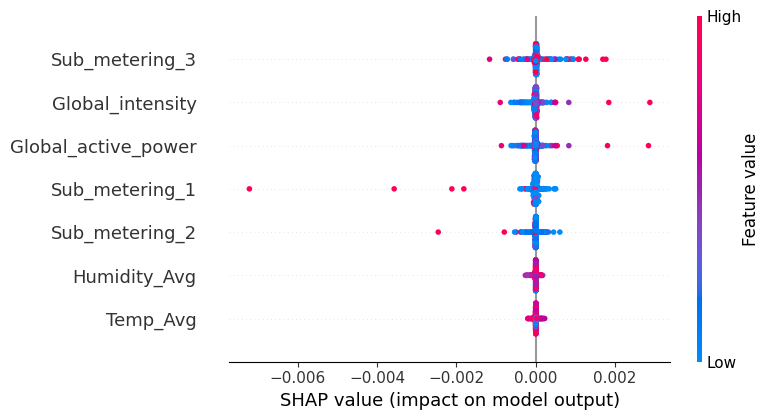

Force plot (target output index: 0)


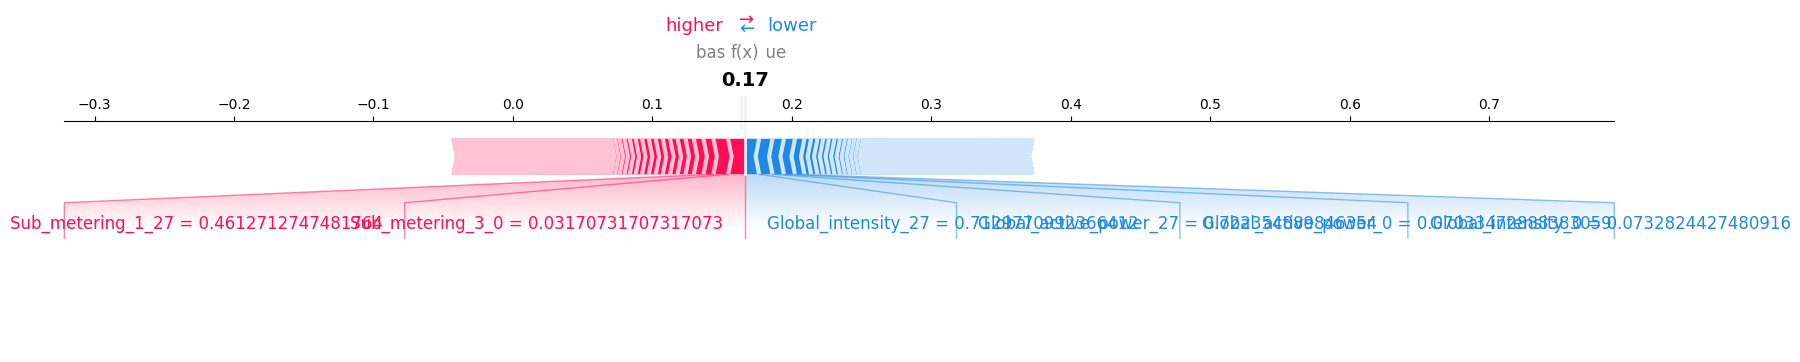

Waterfall plot (target output index: 0)


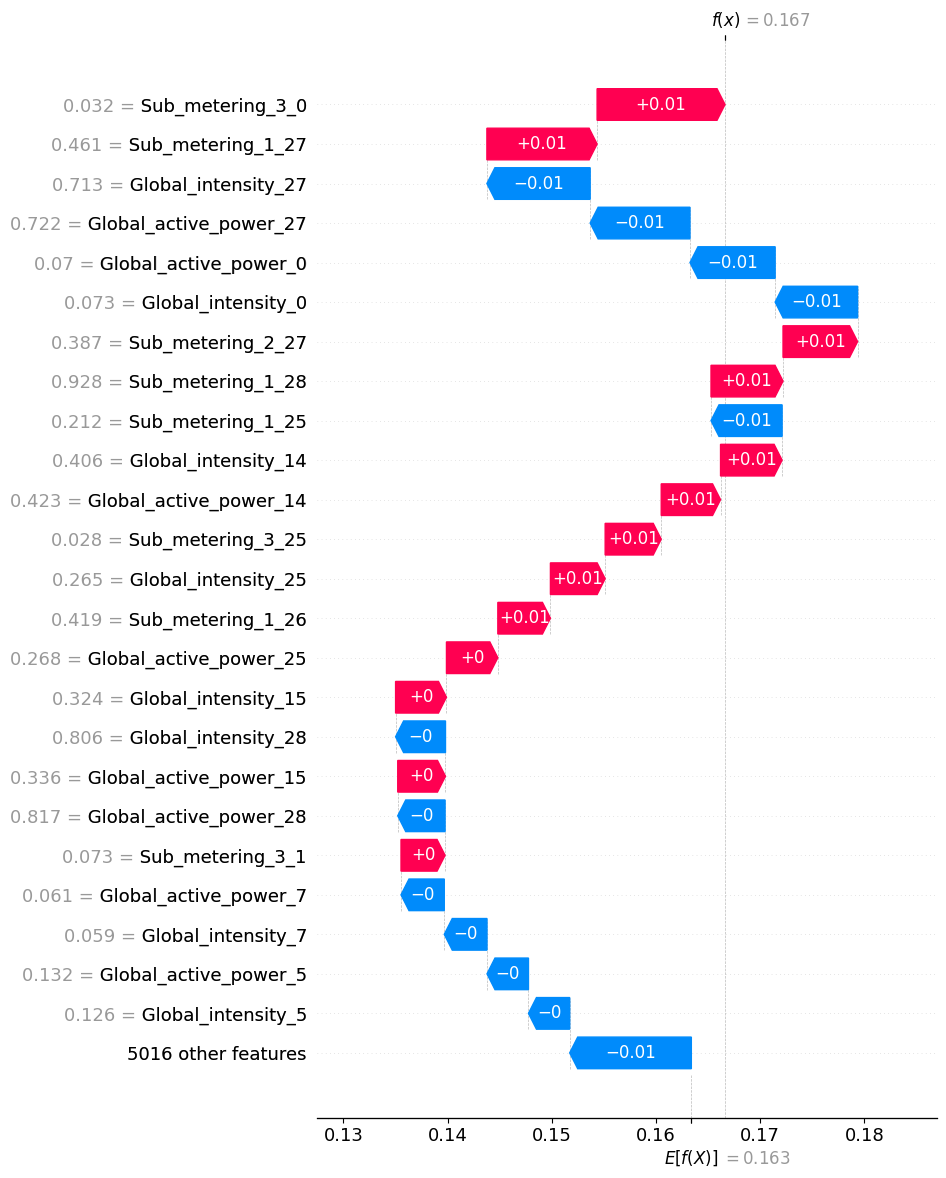

Dependence plot (target output index: 0)


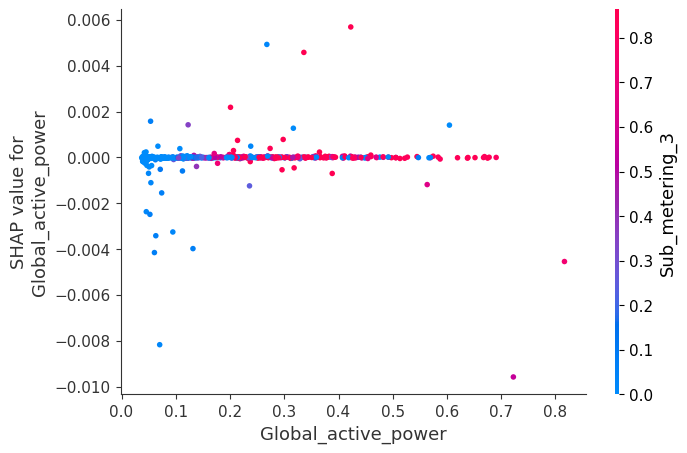

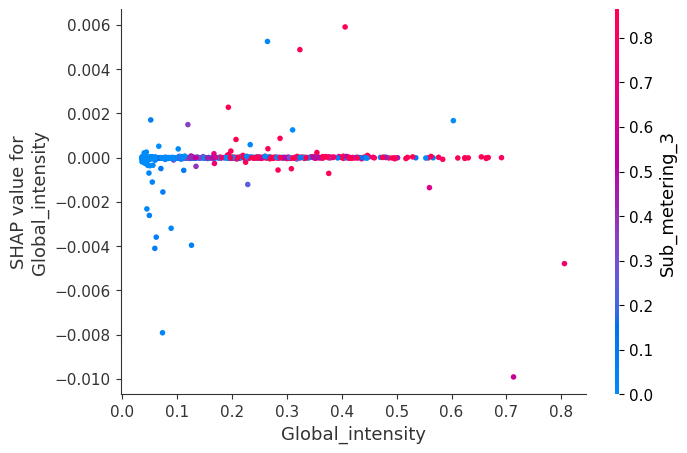

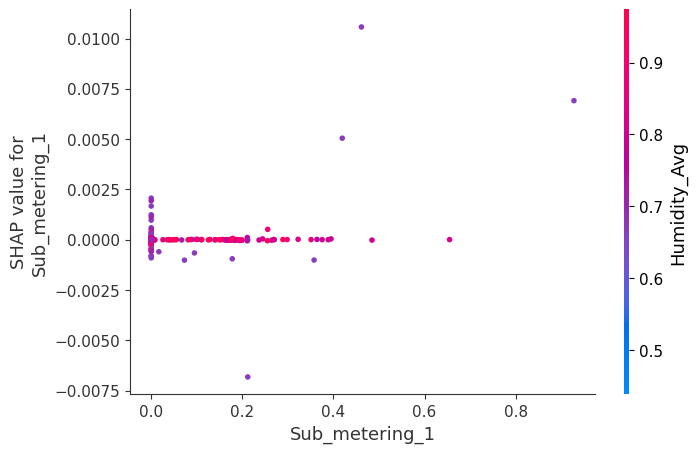

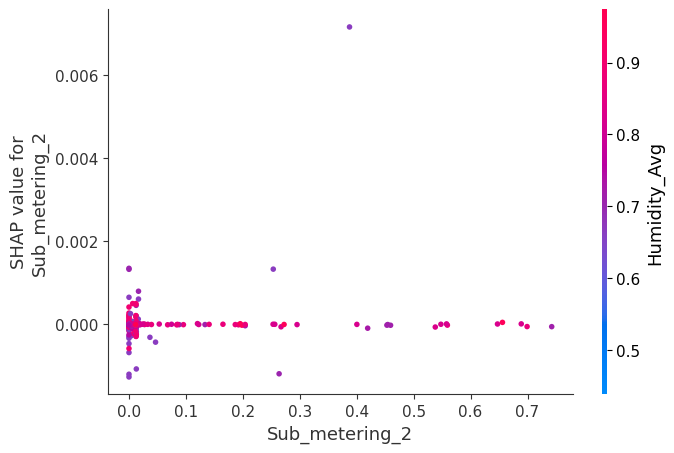

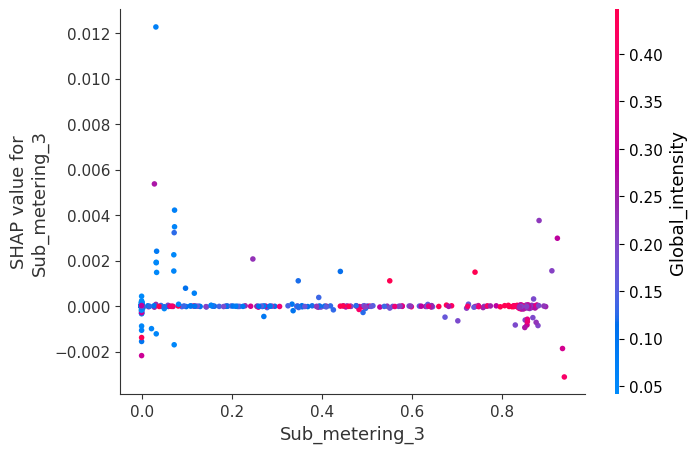

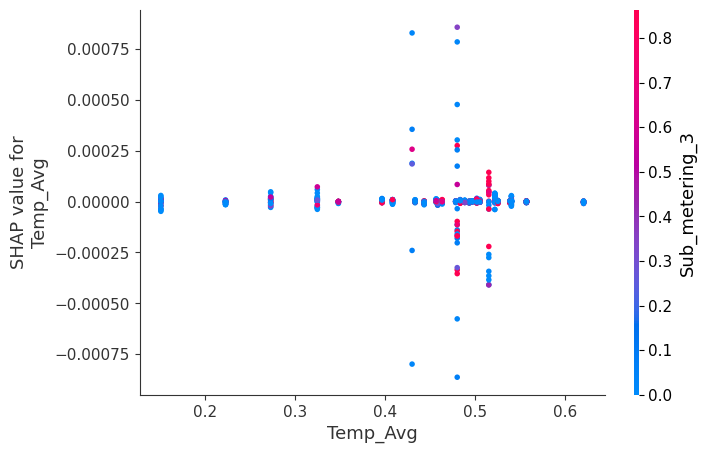

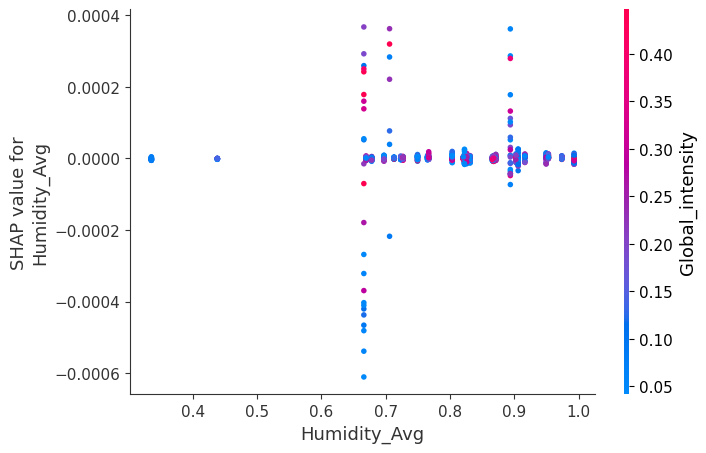

Decision plot (target output index: 0)


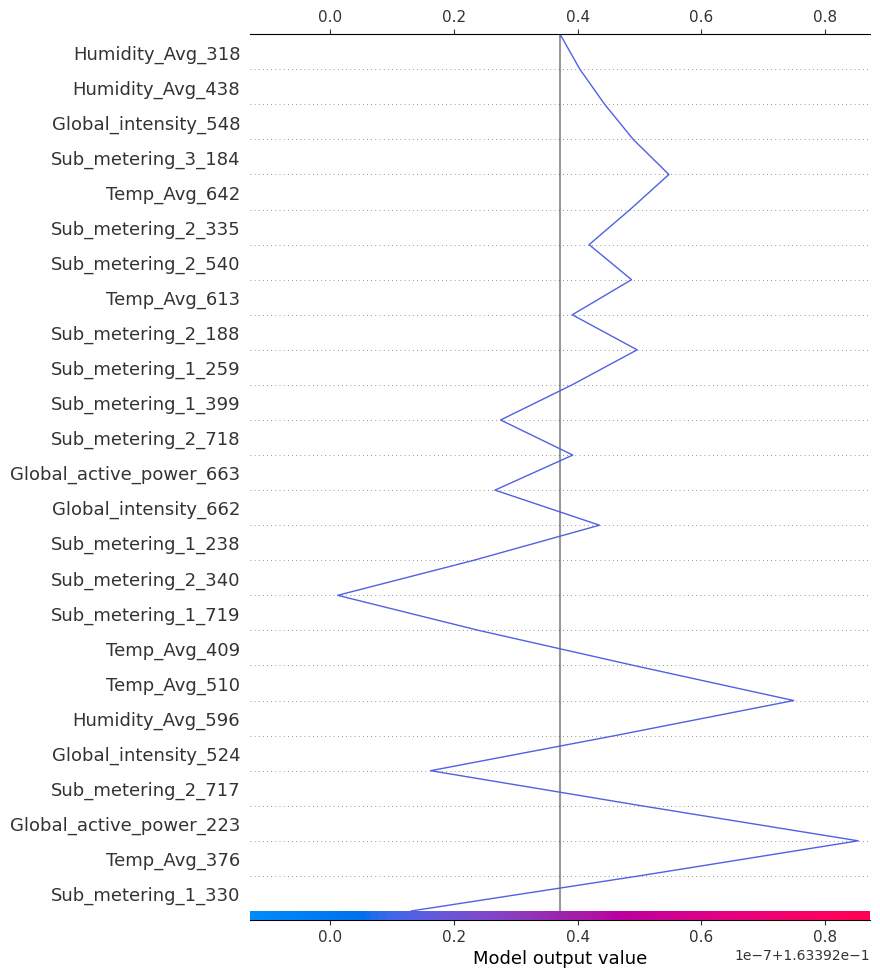

Scatter plot (target output index: 0)


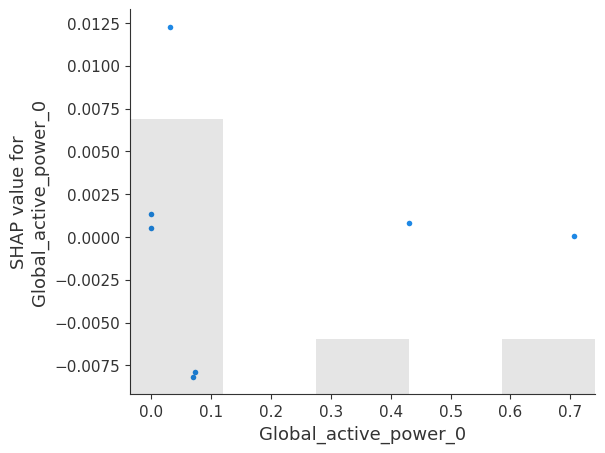

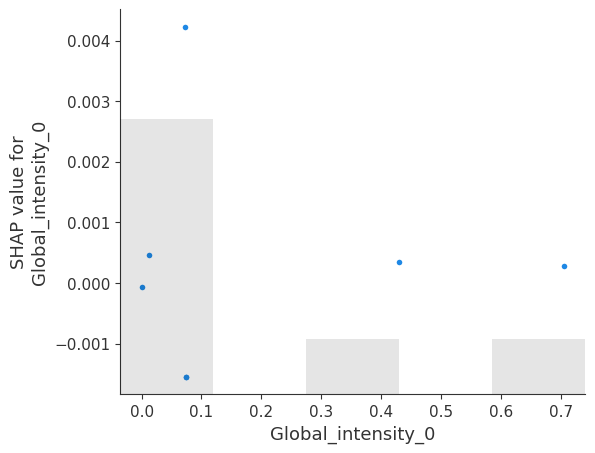

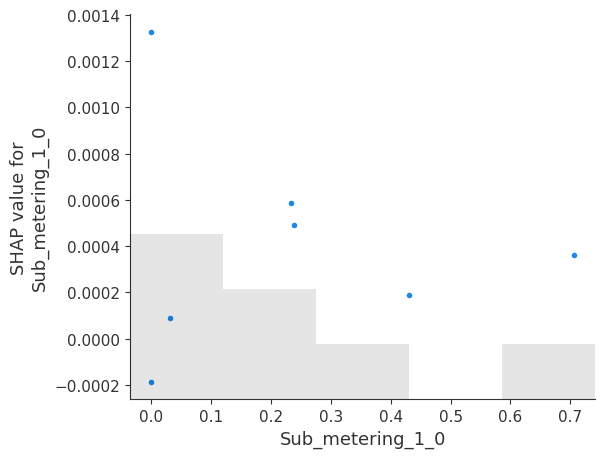

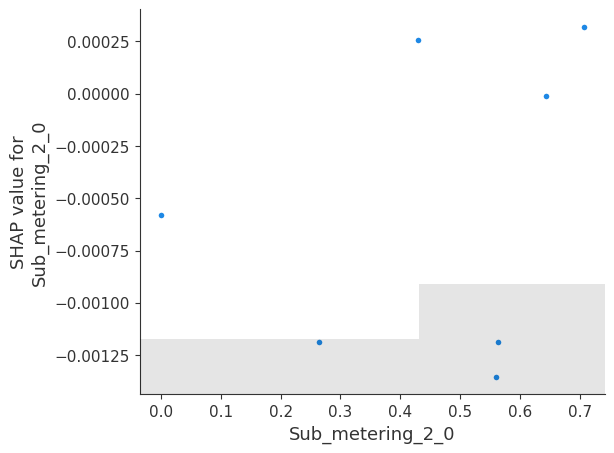

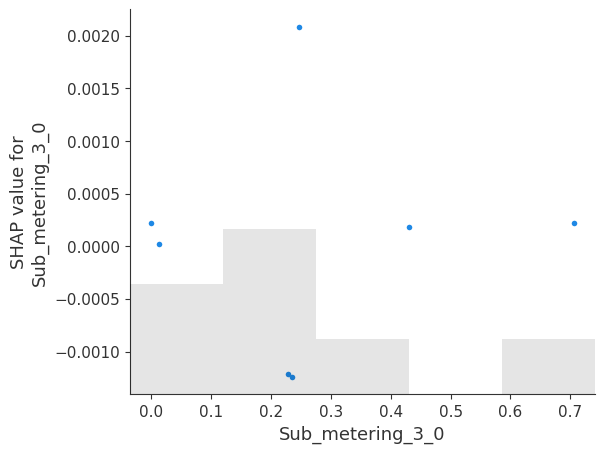

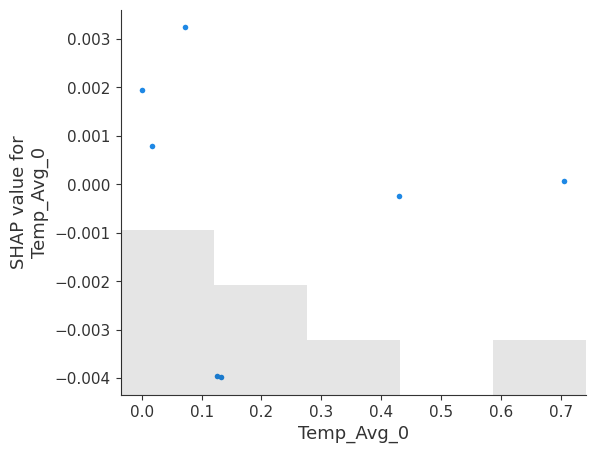

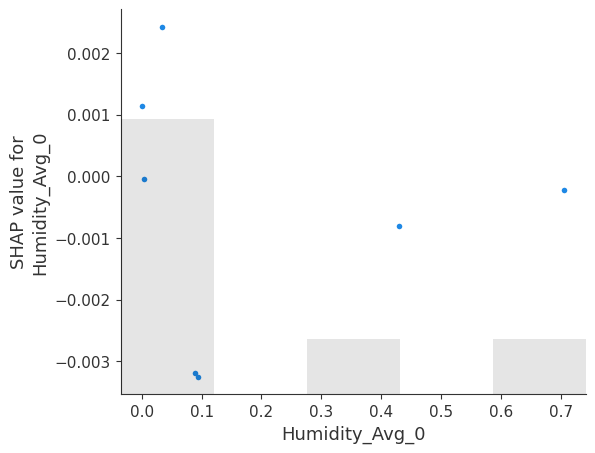

Bar plot


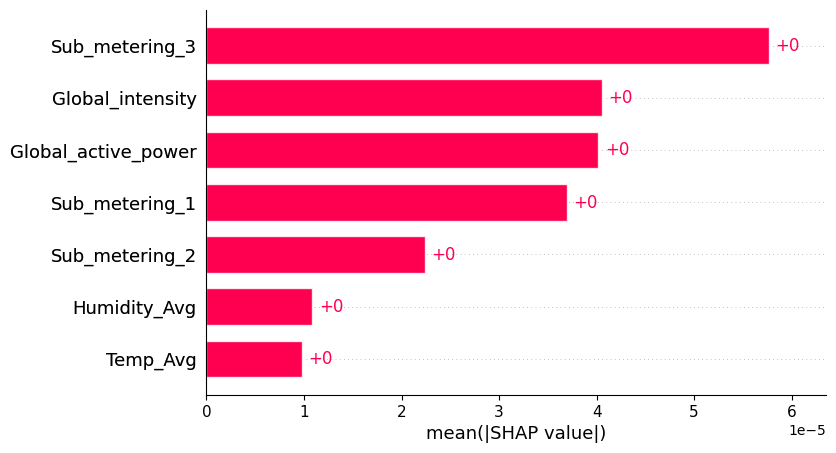

Beeswarm plot


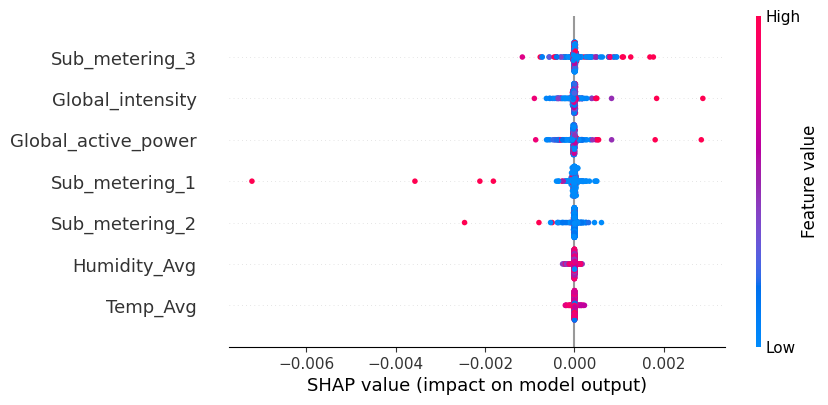

Heatmap plot


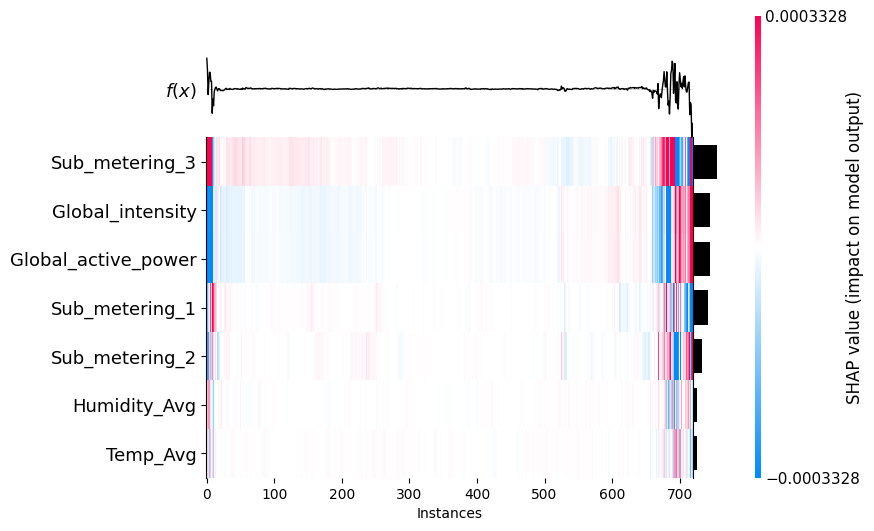

Partial Dependence Plot (feature: Global_active_power, target output index)


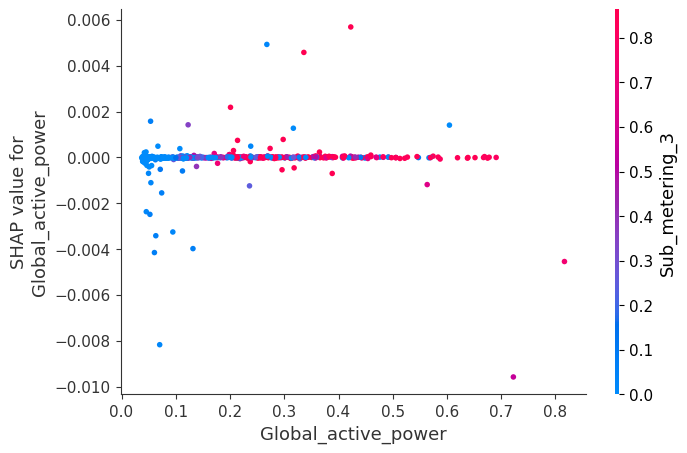

In [15]:
num_samples = 1
shap_values, sampled_eval_sequences = explainer.explain_DeepExplainer(eval_sequences, 
                                                                      num_samples=num_samples)
explainer.visualize_all_one_sample(shap_values[0], 
                                   sampled_eval_sequences[0], 
                                   target_f_idx1=0,
                                   target_f_idx2=1,
                                   target_idx=0)

target_feature_1:  Global_active_power
target_feature_2:  Sub_metering_3
SHAP Value Correlation Plot


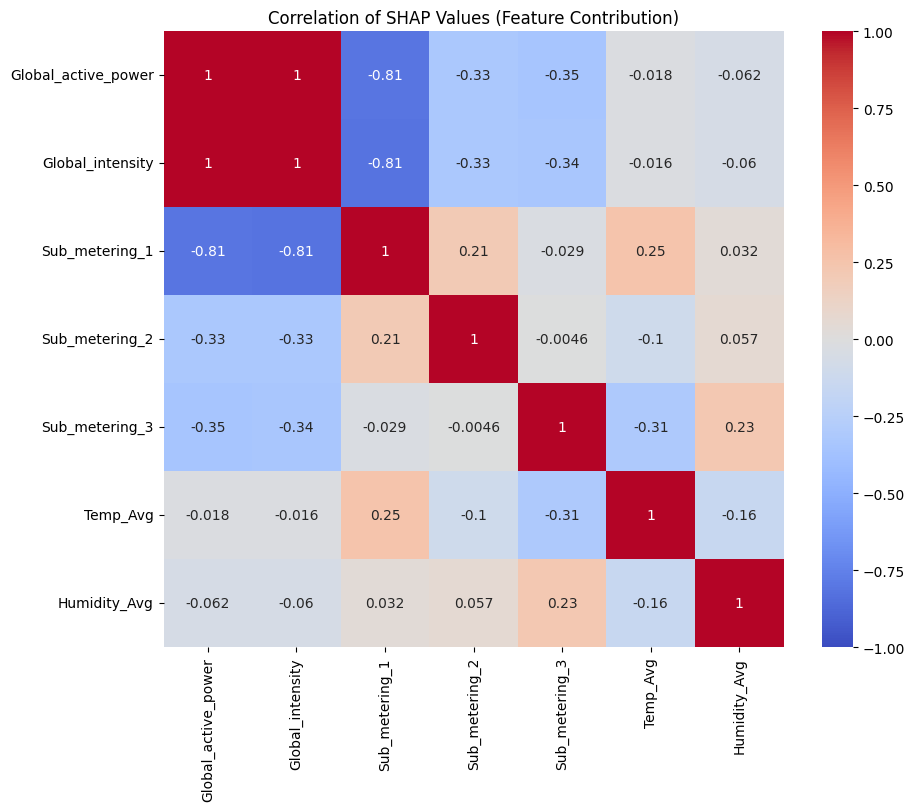

In [16]:
target_feature_1 = dataset.selected_features[0]
target_feature_2 = dataset.selected_features[4]

print('target_feature_1: ', target_feature_1)
print('target_feature_2: ', target_feature_2)


### feature간 shap_value 상관관계 분석
### 현재 출력이 24개이기때문에, 
### 각 아웃풋 1개마다 상관관계 계산 후 24개 평균 
###    or 24개 아웃풋의 평균에 대한 상관관계 계산으로 나뉨 
### 우선 두번째 방법으로 
explainer.visualize_correlation(shap_values[0], sampled_eval_sequences[0], 
                                target_feature_1, target_feature_2)

In [23]:
num_samples_shap = 50  # 여러 샘플을 사용하여 일반화된 분석 시도

shap_values, sampled_eval_sequences = explainer.explain_DeepExplainer(eval_sequences,
                                                                      num_samples=num_samples_shap)

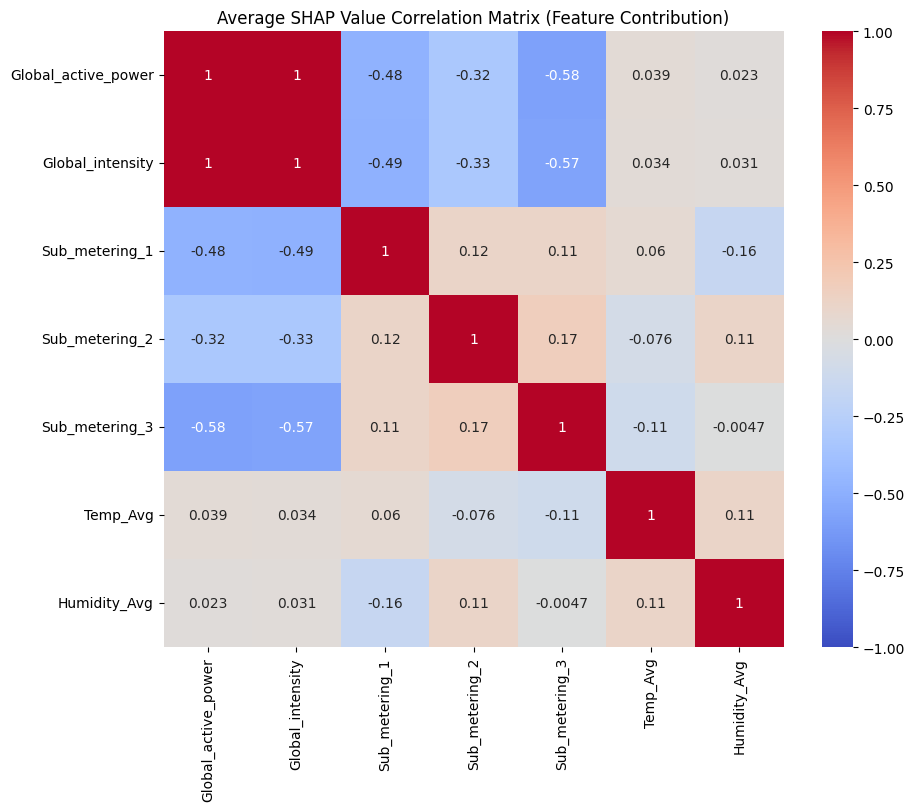

In [24]:
explainer.visualize_correlation_multiple_samples(shap_values)

**주요 feature 추출**

In [25]:
shap_top_features = explainer.extract_important_features(shap_values)

Top 5 important features based on SHAP values:
Top 1: Sub_metering_2 (Importance: 8.932436748020921e-05)
Top 2: Humidity_Avg (Importance: 8.804487493911243e-05)
Top 3: Sub_metering_1 (Importance: 8.5608932658762e-05)
Top 4: Global_active_power (Importance: 8.405028790679561e-05)
Top 5: Sub_metering_3 (Importance: 8.397667662985574e-05)


In [26]:
important_features_dict[explainer_type] = shap_top_features

### 3-3. Attention
**시각화**

- 현재 입력 sequences가 너무 길어 시각화하는 의미가 없어짐 -> 방법 고민 필요
- 주요 feature의 경우, 각 샘플에 대해서 attention weights를 뽑고, attention weight가 가장 높은 timestep의 feature를 선택 -> N개의 샘플에 대해서 반복해서 가장 빈도가 높은 feature를 주요 feature로 선정

In [37]:
# Attention explainer 정의
explainer_type = 'Attention' 
explainer = get_explainer(explainer_type=explainer_type, 
                          model=model, device=device, 
                          train_sequences=train_sequences, 
                          sequence_length=sequence_length,
                          input_size=input_size,
                          selected_features=dataset.selected_features, 
                          scaler=dataset.scaler)

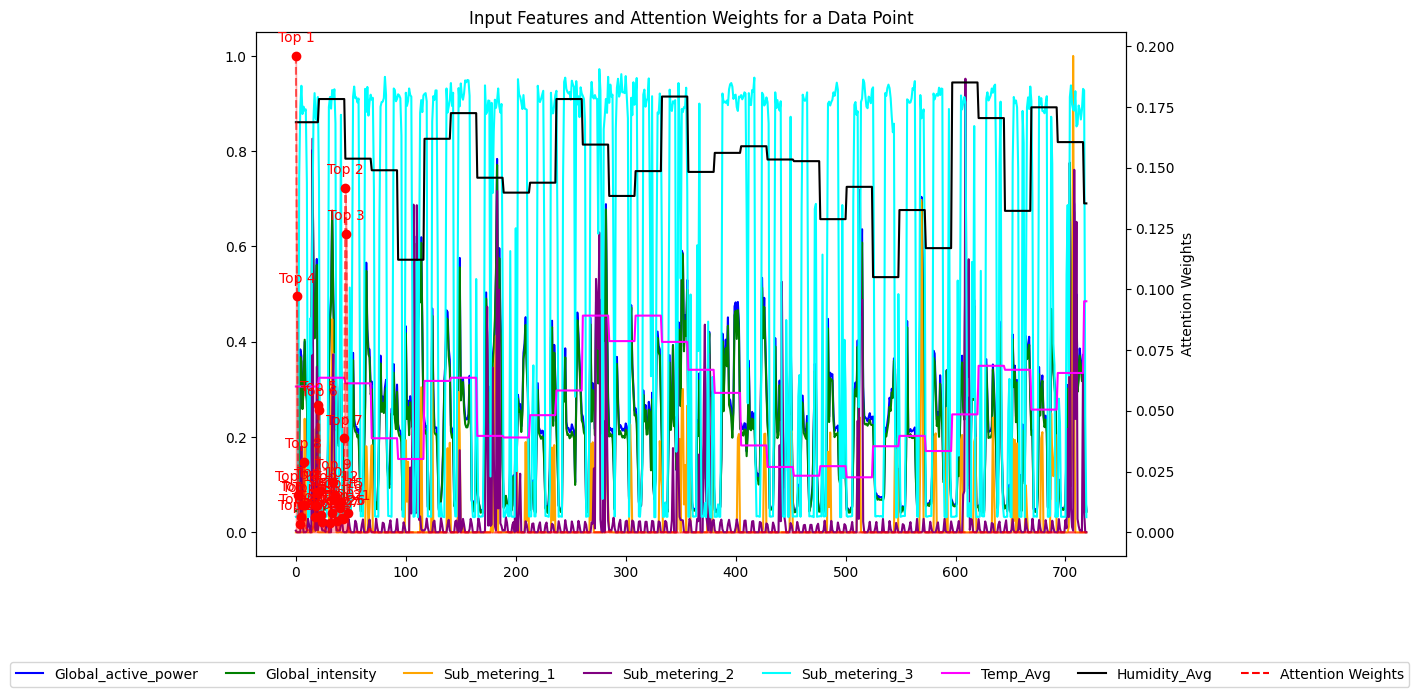

Prediction for the data point: tensor([[0.0818, 0.0471, 0.0672, 0.2113, 0.3521, 0.3312, 0.2269, 0.1957, 0.2018,
         0.1427, 0.0893, 0.0468, 0.0442, 0.0725, 0.0773, 0.0959, 0.1896, 0.2893,
         0.2711, 0.1410, 0.0632, 0.0526, 0.0491, 0.0385]], device='cuda:0',
       grad_fn=<BackwardHookFunctionBackward>)
Top 30 time steps with highest attention weights:
Top 1 - Time step 0: Attention Weight = 0.19601617753505707
  Global_active_power: 0.045595886513291606
  Global_intensity: 0.04439224897240164
  Sub_metering_1: 0.0
  Sub_metering_2: 0.0034142640364188165
  Sub_metering_3: 0.03252032520325203
  Temp_Avg: 0.306020066889632
  Humidity_Avg: 0.8608695652173913
Top 2 - Time step 45: Attention Weight = 0.14168962836265564
  Global_active_power: 0.05701264124867897
  Global_intensity: 0.054139753376394595
  Sub_metering_1: 0.0
  Sub_metering_2: 0.0
  Sub_metering_3: 0.06341463414634146
  Temp_Avg: 0.31270903010033435
  Humidity_Avg: 0.7843478260869564
Top 3 - Time step 46: Attention

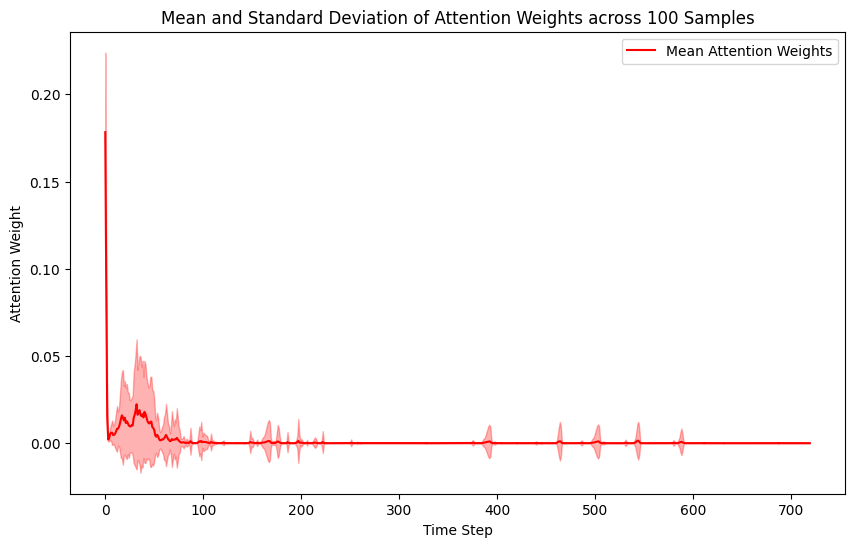

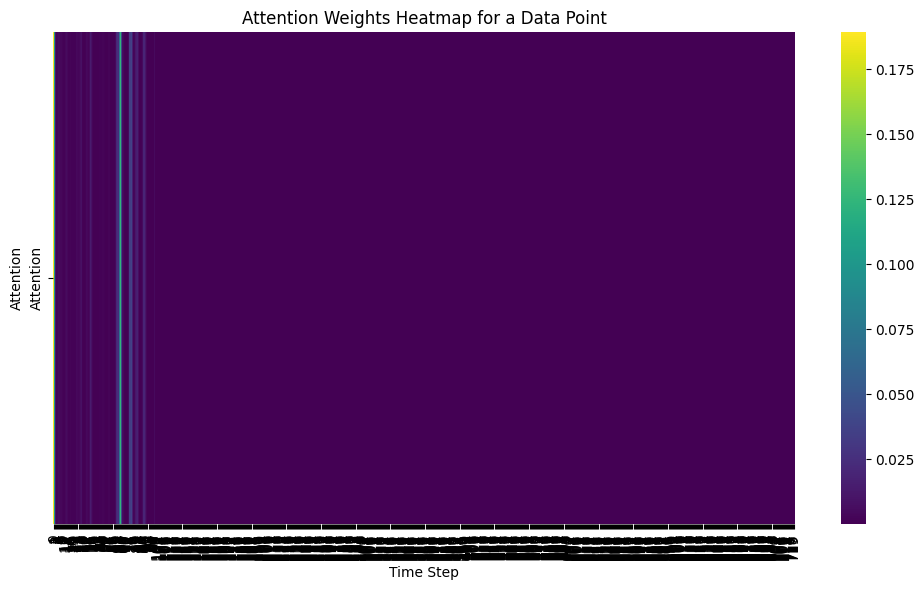

Prediction for the data point: tensor([[0.3481, 0.2974, 0.2226, 0.2021, 0.2408, 0.2497, 0.2196, 0.1605, 0.1468,
         0.2011, 0.2400, 0.2378, 0.2954, 0.3081, 0.2319, 0.1203, 0.0614, 0.0582,
         0.0735, 0.0833, 0.0703, 0.0685, 0.1896, 0.3514]], device='cuda:0',
       grad_fn=<BackwardHookFunctionBackward>)


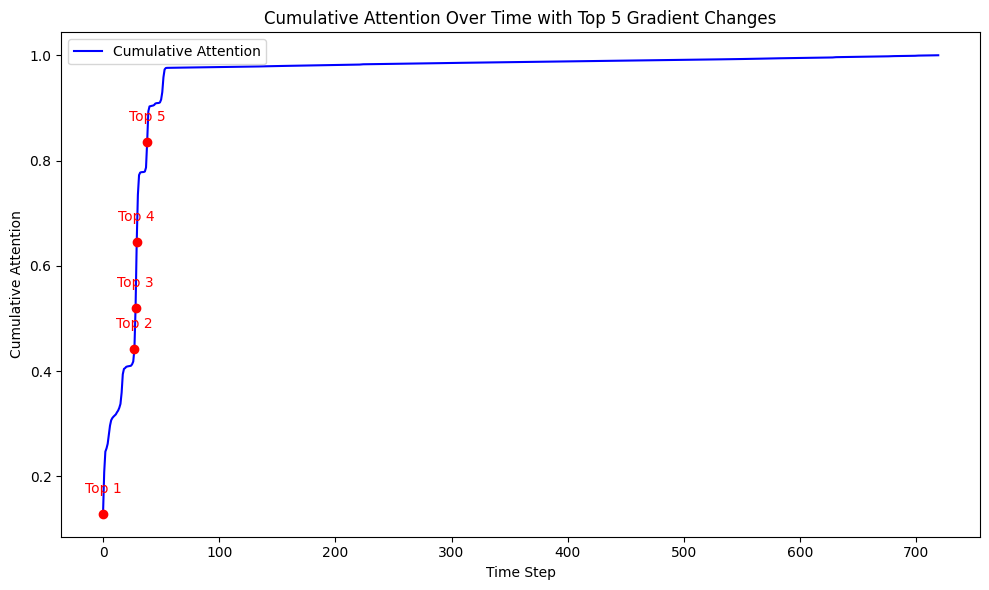

Prediction for the data point: tensor([[0.3701, 0.4786, 0.4055, 0.2355, 0.1340, 0.0726, 0.0440, 0.0482, 0.0208,
         0.0253, 0.1127, 0.2039, 0.2561, 0.2402, 0.1905, 0.1157, 0.0441, 0.0176,
         0.0403, 0.0736, 0.0757, 0.1001, 0.1806, 0.3020]], device='cuda:0',
       grad_fn=<BackwardHookFunctionBackward>)
Top 5 steps with largest gradient changes:
Top 1 - Time step 0: Gradient Change = 2.6881694793701172e-05
  Global_active_power: 0.4707340866596212
  Global_intensity: 0.45895478567234294
  Sub_metering_1: 0.0
  Sub_metering_2: 0.0
  Sub_metering_3: 0.8341463414634146
  Temp_Avg: 0.39966555183946484
  Humidity_Avg: 0.5113043478260867
Top 2 - Time step 27: Gradient Change = 0.023379862308502197
  Global_active_power: 0.07313429802455085
  Global_intensity: 0.071873165002936
  Sub_metering_1: 0.0
  Sub_metering_2: 0.00037936267071320183
  Sub_metering_3: 0.0
  Temp_Avg: 0.3929765886287625
  Humidity_Avg: 0.49913043478260877
Top 3 - Time step 28: Gradient Change = 0.0785149633884

In [38]:
attention_top_n = 30

# random smaple 하나에 대해서 attention weight 시각화
explainer.visualize_attention(n=attention_top_n) 

# n개 sample에 대해서 attention weight 분포 시각화
explainer.analyze_attention_distribution(num_samples=100)

# attention heatmap 시각화
explainer.visualize_attention_heatmap()

explainer.visualize_cumulative_attention(num_points=top_n)

**주요 feature 추출**

In [39]:
attention_top_features = explainer.extract_important_features(num_samples=num_samples, 
                                                              top_n=top_n)

Extracting important features: 100%|██████████████████████████████| 300/300 [00:07<00:00, 37.72sample/s]


Top 5 important features:
Top 1: Humidity_Avg (Importance: 98.3421)
Top 2: Temp_Avg (Importance: 84.7494)
Top 3: Sub_metering_3 (Importance: 39.7717)
Top 4: Global_active_power (Importance: 20.9790)
Top 5: Global_intensity (Importance: 20.5431)


In [40]:
important_features_dict[explainer_type] = attention_top_features

### 3-4. Grad-CAM 

Grad-CAM도 마찬가지로 hidden layer에서 만들어진 vector에 대해 각 입력 timestep별로 기여도를 추출 

**시각화**

In [41]:
# LIME explainer 정의
explainer_type = 'GRAD_CAM' 
explainer = get_explainer(explainer_type=explainer_type, 
                          model=model, device=device, 
                          train_sequences=train_sequences, 
                          sequence_length=sequence_length,
                          input_size=input_size,
                          selected_features=dataset.selected_features, 
                          scaler=dataset.scaler)

/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


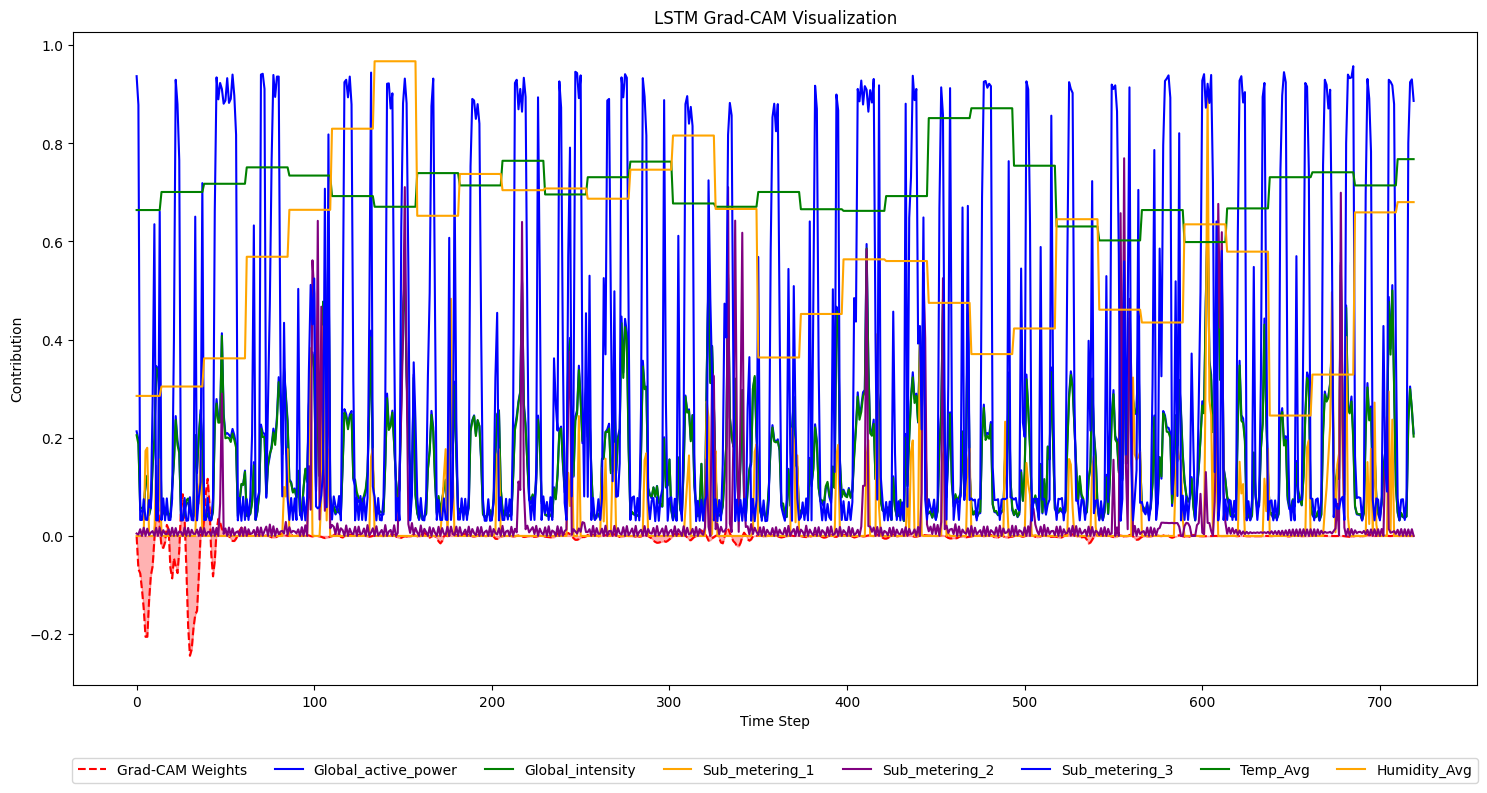

In [42]:
data_point = eval_sequences[np.random.choice(len(eval_sequences))]

grad_cam_weights = explainer.compute_grad_cam(data_point)
explainer.visualize_grad_cam(grad_cam_weights, data_point, dataset.selected_features)

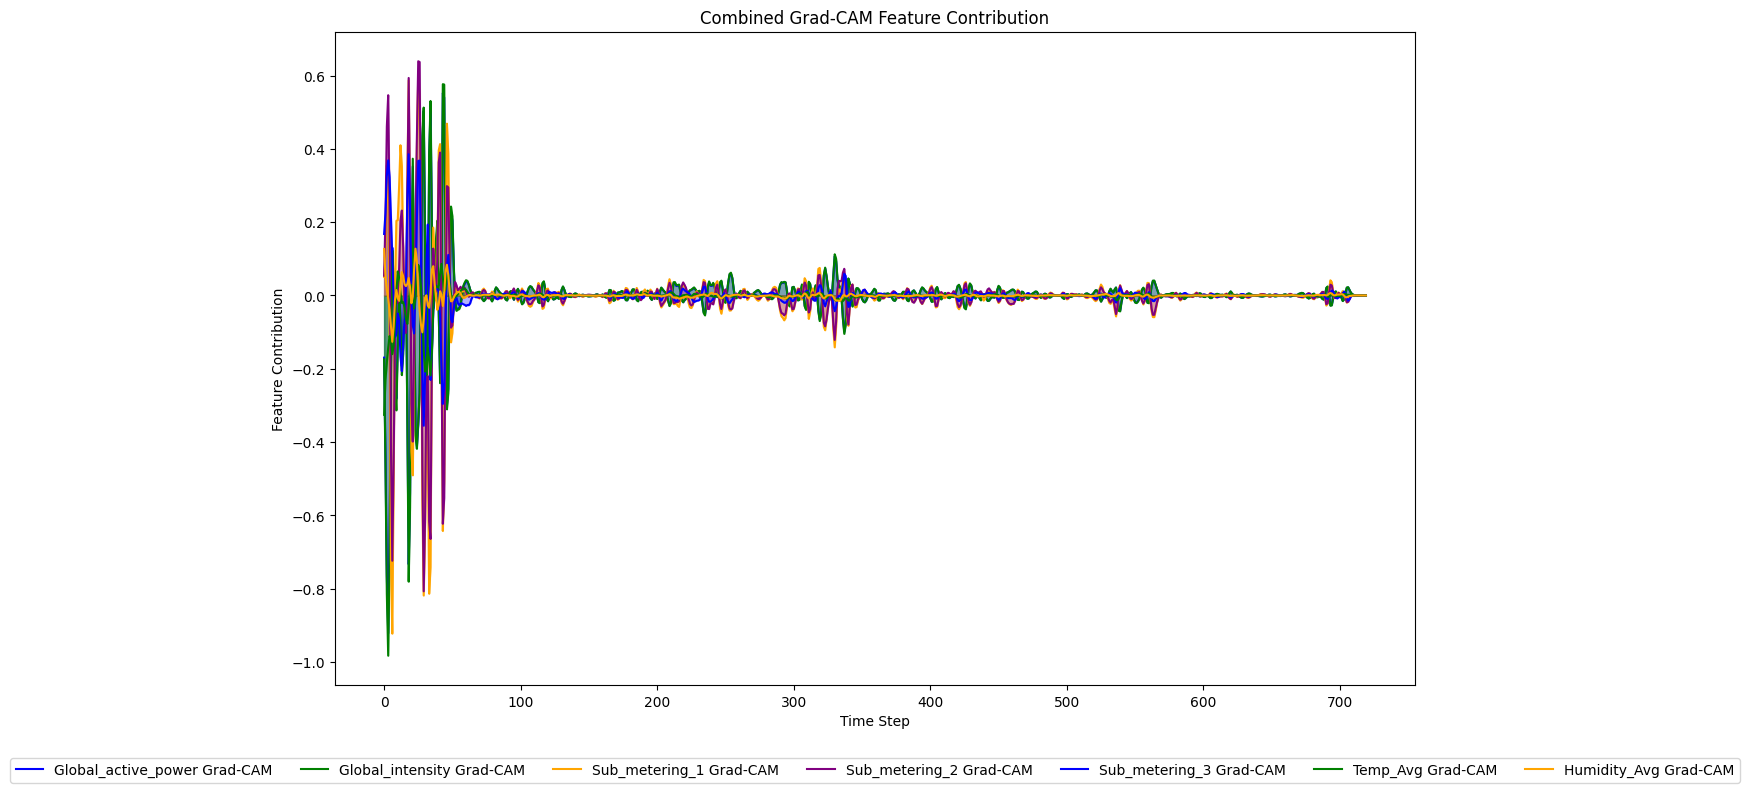

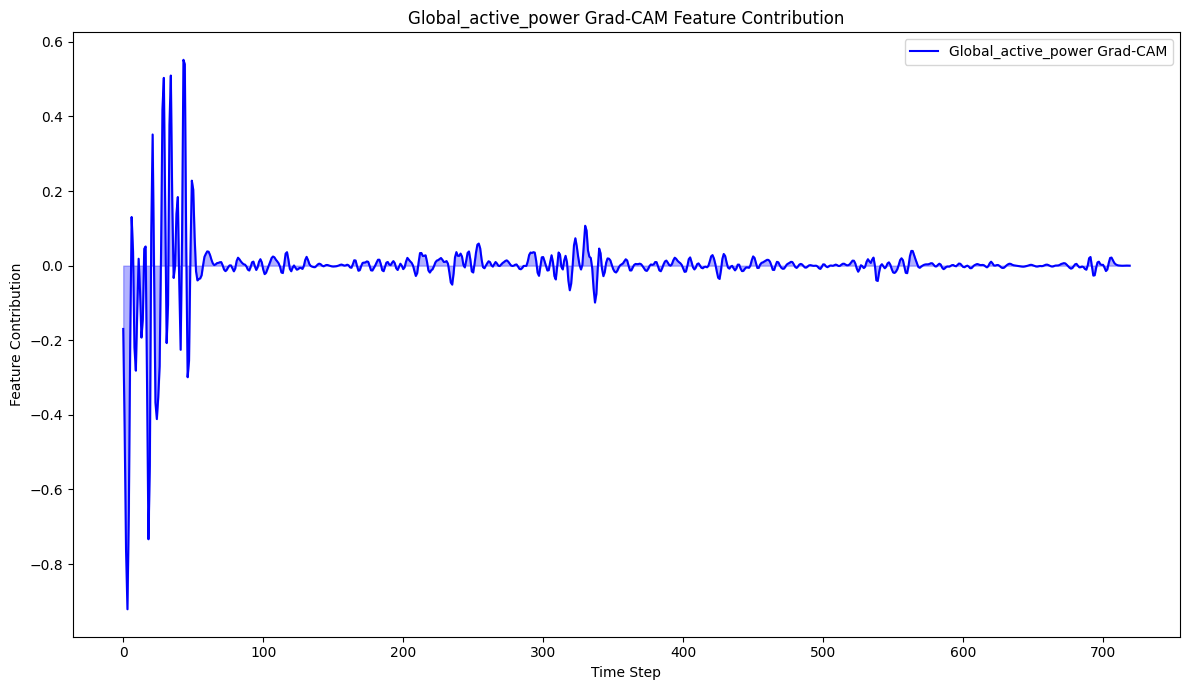

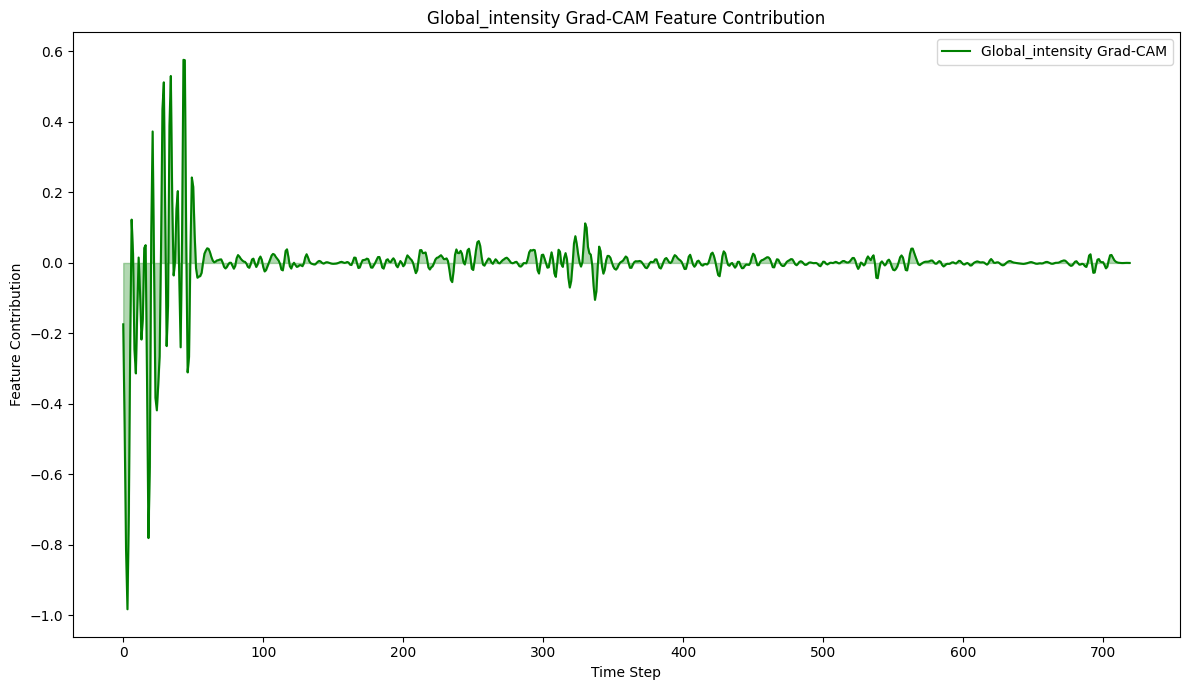

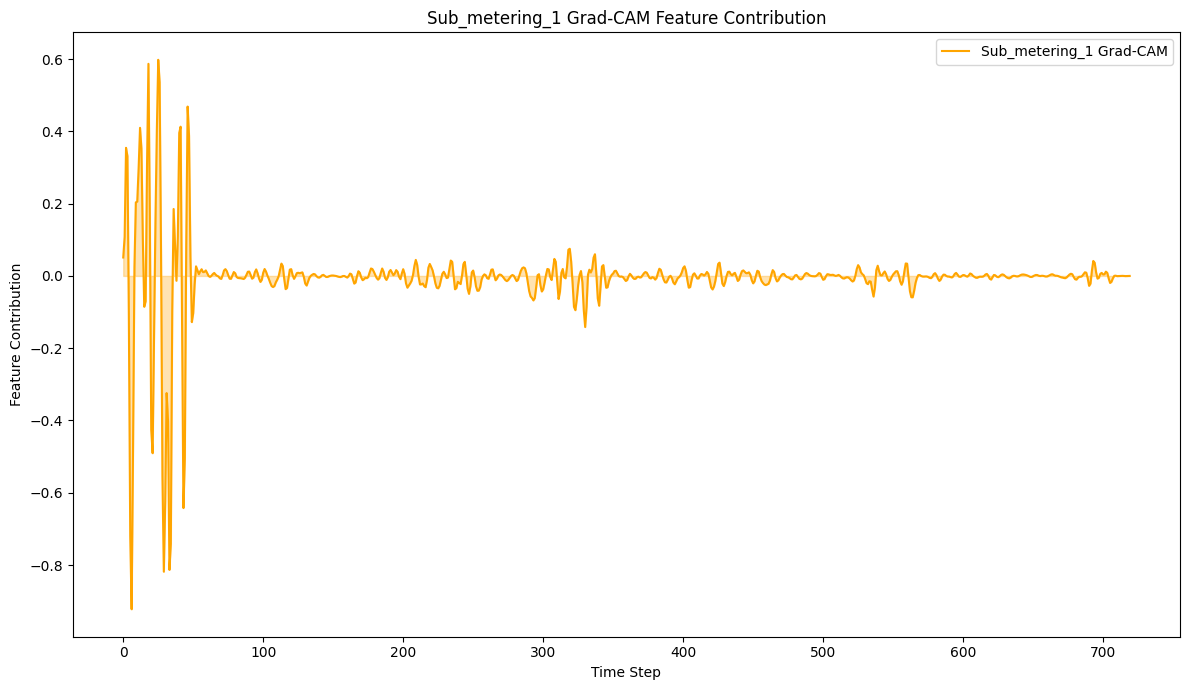

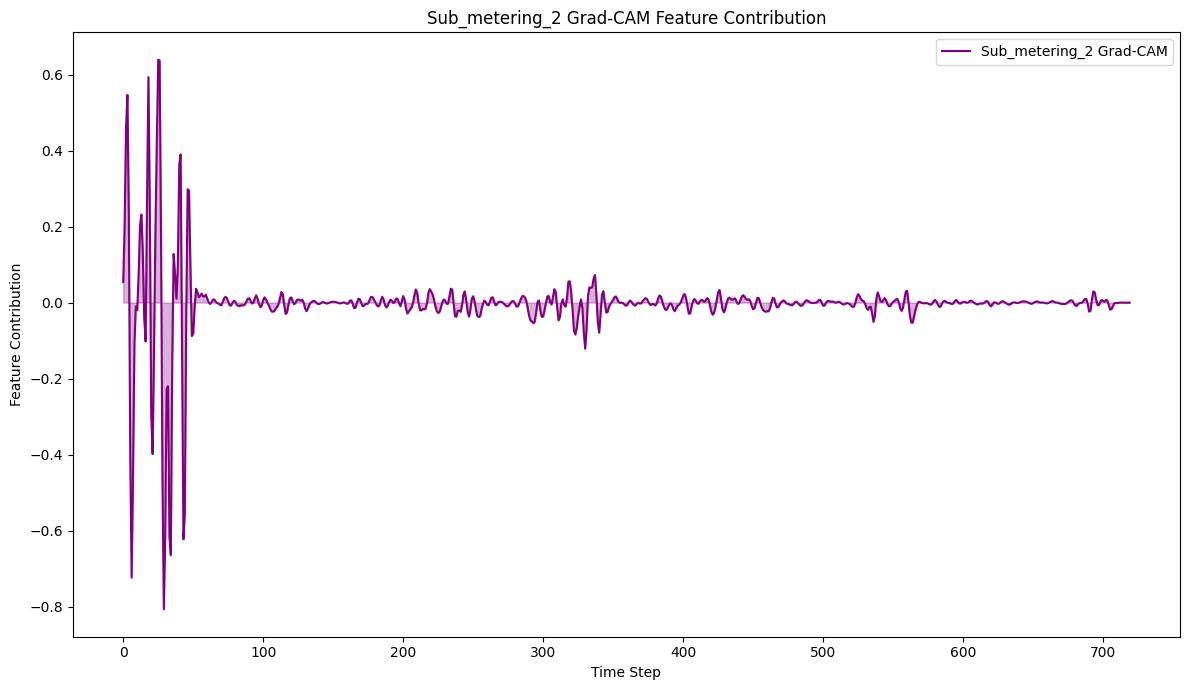

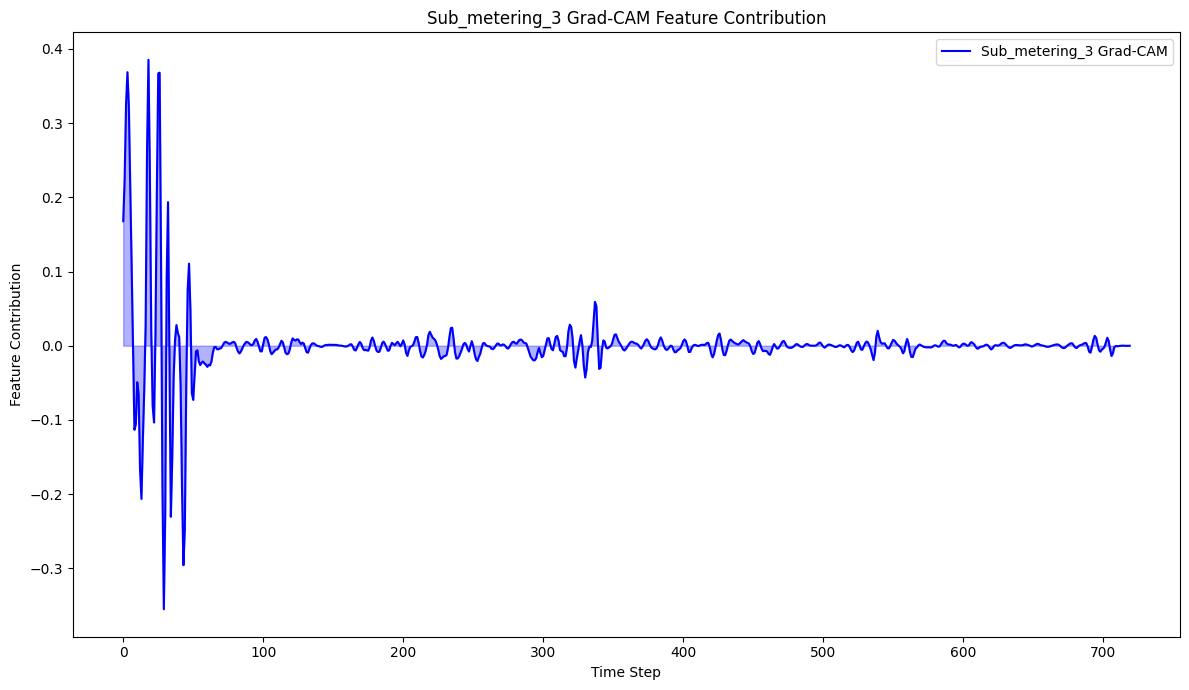

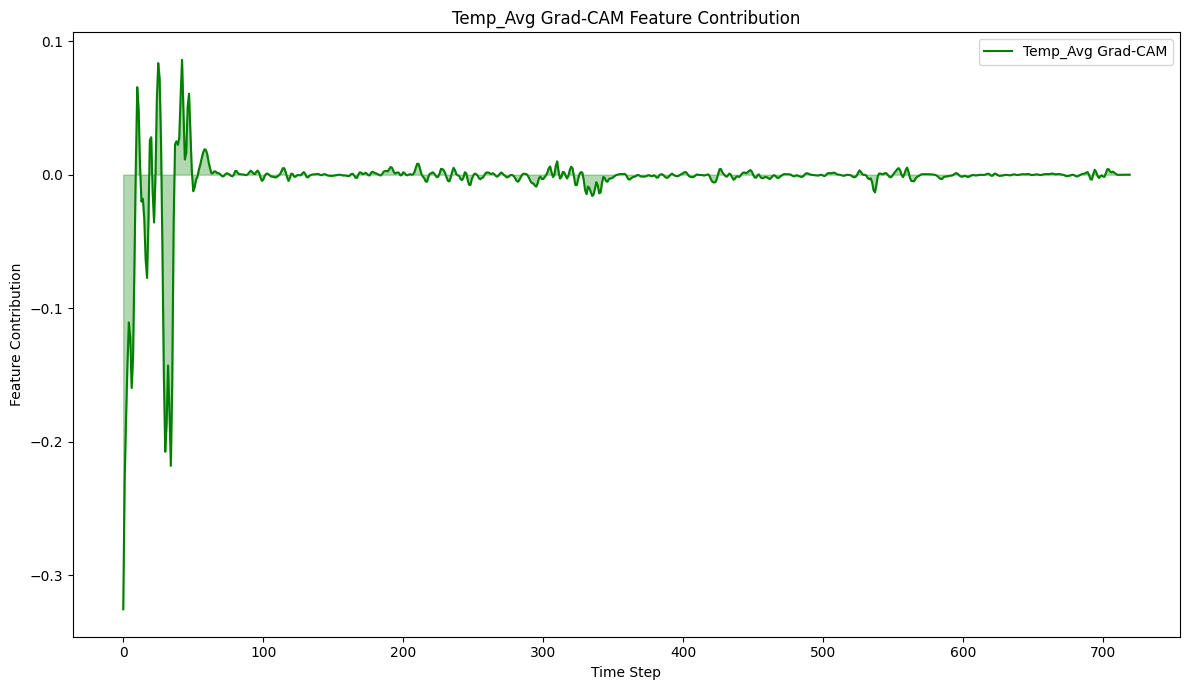

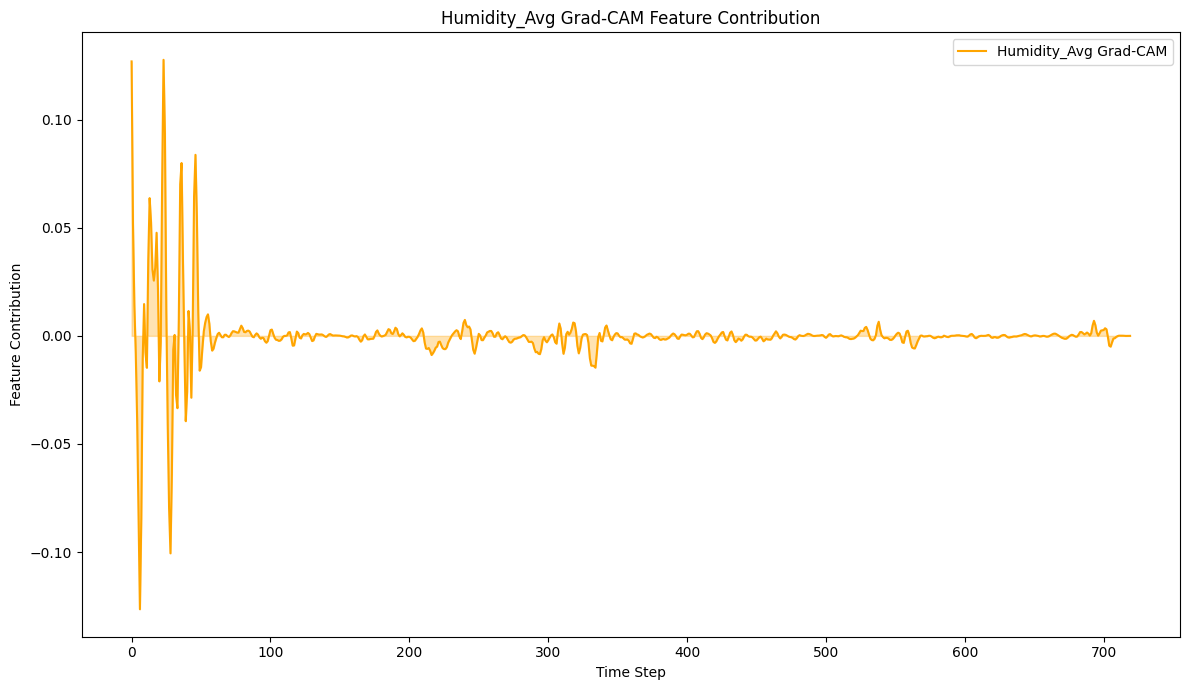

In [43]:
grad_cam_weights_per_feature = explainer.compute_grad_cam_per_feature(data_point)
explainer.visualize_grad_cam_per_feature(grad_cam_weights_per_feature, 
                                         data_point, dataset.selected_features)

In [44]:
gradcam_top_features = explainer.extract_important_features(num_samples=num_samples, 
                                                            top_n=top_n)

Extracting important features with Grad-CAM...


Processing samples: 100%|█████████████████████████████████████████████| 300/300 [00:27<00:00, 10.93it/s]

Top 5 important features based on SHAP values:
Top 1: Sub_metering_1 (Importance: 13.323340237140656)
Top 2: Global_intensity (Importance: 11.844873160123825)
Top 3: Sub_metering_2 (Importance: 11.566662511788309)
Top 4: Global_active_power (Importance: 11.236195892095566)
Top 5: Sub_metering_3 (Importance: 5.671727277804166)


In [45]:
important_features_dict[explainer_type] = gradcam_top_features

**최종 주요 feature 추출**

- 각 방법론별 importance 값을 정규화함
- 각 방법론별 중요도/가중치는 논의 후 반영 (현재는 동일 가중치)

In [49]:
"""
    explainers.utils.py 로 옮길 예정
"""

def normalize(values):
    min_val, max_val = min(values), max(values)
    return [(v - min_val) / (max_val - min_val) if max_val > min_val else 0 for v in values]

def get_top_features(methods):
    """
    최종 5개의 feature와 합산된 중요도를 반환하는 함수
    :param methods: 각 방법론의 feature 중요도를 포함한 딕셔너리
                    {"method_name": {"feature_name": importance, ...}, ...}
    :return: 최종 Top 5 feature와 중요도 합산 딕셔너리
    """
    # 각 방법론의 정규화된 중요도 값을 담을 딕셔너리
    normalized_importances = {}

    # 각 방법론의 중요도 값 정규화 및 합산
    for method_name, features in methods.items():
        importances = list(features.values())
        norm_importances = normalize(importances)

        for (feature, _), norm_imp in zip(features.items(), norm_importances):
            if feature in normalized_importances:
                normalized_importances[feature] += norm_imp
            else:
                normalized_importances[feature] = norm_imp

    # 합산된 중요도 값으로 상위 5개 feature를 추출
    top_features = sorted(normalized_importances.items(), key=lambda x: x[1], reverse=True)[:5]

    # 최종 결과 반환
    return {feature: importance for feature, importance in top_features}

In [56]:
top_5_features = get_top_features(important_features_dict)
print(top_5_features)

# importance 값을 어떻게 활용하지?
important_features = list(top_5_features.keys())
print('final important featurs: ', important_features)

{'Humidity_Avg': 1.819551025769787, 'Global_intensity': 1.8067770697663417, 'Sub_metering_2': 1.7704173310009295, 'Global_active_power': 1.4959382361062086, 'Sub_metering_1': 1.3052263256389196}
final important featurs:  ['Humidity_Avg', 'Global_intensity', 'Sub_metering_2', 'Global_active_power', 'Sub_metering_1']


In [61]:
feature_abbreviations = {
    'Global_active_power': 'GA',
    'Global_intensity': 'GI',
    'Sub_metering_1': 'SM1',
    'Sub_metering_2': 'SM2',
    'Sub_metering_3': 'SM3',
    'Humidity_Avg': 'HV',
    'Temp_Avg': 'TV'
}
abbreviated_features = [feature_abbreviations[feature] for feature in important_features]

## 4. Re-train model with important features

앞서 추출한 주요 feature (top_N)에 대해서 모델 재학습 

In [66]:
# 선택된 top N개 feature만 이용
feature_type = FT_TYPE_IMPT

if feature_type == FT_TYPE_HPC:
    target_features = ['Global_active_power', 'Global_active_power', 
                       'Voltage', 'Global_intensity', 
                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    file_path = 'data/hourly_household_power_consumption.csv'
elif feature_type == FT_TYPE_PCW:
    target_features = ['Global_active_power', 'Global_intensity', 
                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 
                       'Temp_Avg', 'Humidity_Avg']
    file_path = 'data/final_hourly_power_weather_avg.csv'
elif feature_type == FT_TYPE_PCWT:
    target_features = ['Global_active_power', 'Global_intensity', 
                   'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 
                   'Temp_Avg', 'Humidity_Avg', 'sin_hour', 'cos_hour', 
                   'sin_day', 'cos_day', 'sin_month', 'cos_month']
    file_path = 'data/final_hourly_power_weather_avg_with_time.csv'
else: # 그외 원하는 feature 선택 
    target_features = important_features
    file_path = 'data/final_hourly_power_weather_avg.csv'

print('feature_type: ', feature_type)
print('target_features: ', target_features)


# 입출력 시퀀스 길이 정의 (모델 입출력)
# sequence_length: 입력 길이, 24(시간) * 원하는 일수
# prediction_length: 예측할 길이 (예: 24-> 24시간 예측)
sequence_length = 24*30
prediction_length = 24

dataset = PowerWeatherDataset(file_path=file_path, 
                              sequence_length=sequence_length, 
                              prediction_length=prediction_length, 
                              target_features=target_features)

train_sequences, eval_sequences, train_targets, eval_targets = dataset.load_data()

print('train_sequences shape: ', train_sequences.shape)
print('train_targets shape: ', train_targets.shape)
print('eval_sequences shape: ', eval_sequences.shape)
print('eval_targets shape: ', eval_targets.shape)

feature_type:  IMPT
target_features:  ['Humidity_Avg', 'Global_intensity', 'Sub_metering_2', 'Global_active_power', 'Sub_metering_1']
train_sequences shape:  (16896, 720, 5)
train_targets shape:  (16896, 24)
eval_sequences shape:  (4225, 720, 5)
eval_targets shape:  (4225, 24)


In [71]:
model_name = 'LSTM-Att' 
input_size = len(dataset.selected_features)  
hidden_size = 256
num_layers = 3
output_size = prediction_length

num_epochs = 100
dropout = 0.1
batch_size = 64
learning_rate = 0.001
patience = 15
num_of_features = input_size


# build model 
retrained_model = create_model(model_name, input_size, 
                               hidden_size, num_layers, 
                               output_size, dropout)
print('retrained_model: ', retrained_model)

# define model save/load path
features_str = "_".join(abbreviated_features)
retrained_model_path = './trained_models/retrained/{}_{}_{}_{}.pth'.format(model_name, features_str,
                                                                           int(sequence_length/24),
                                                                           output_size)
print('retrained_model_path: ', retrained_model_path)

# load model
if os.path.exists(retrained_model_path):
    print(f"Loading the pre-trained {model_name} model...")
    model = load_model(model, model_path)
    # model = nn.DataParallel(model)
    model.to(device)
else:
    print(f"Retraining a {model_name} model...")
    train_and_evaluate(retrained_model, model_name, train_sequences, train_targets, 
                       eval_sequences, eval_targets, retrained_model_path,
                       num_epochs, batch_size, learning_rate, patience)

new_r2 = evaluate_r2_score(retrained_model, eval_sequences, eval_targets, model_name)

retrained_model:  LSTMWithAttention(
  (lstm): LSTM(5, 256, num_layers=3, batch_first=True, dropout=0.1)
  (attention): Attention(
    (attention_layer): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=24, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
retrained_model_path:  ./trained_models/retrained/LSTM-Att_HV_GI_SM2_GA_SM1_30_24.pth
Retraining a LSTM-Att model...


Epoch 1/100: 100%|████████████████████████████████████| 264/264 [00:41<00:00,  6.30batch/s, loss=0.0299]
/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 24])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Train Loss: 0.0477, Val Loss: 0.0288
Validation loss improved. Model saved at epoch 1


Epoch 2/100: 100%|████████████████████████████████████| 264/264 [00:41<00:00,  6.29batch/s, loss=0.0323]


Epoch [2/100], Train Loss: 0.0315, Val Loss: 0.0289


Epoch 3/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.0363]


Epoch [3/100], Train Loss: 0.0307, Val Loss: 0.0288


Epoch 4/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.0333]


Epoch [4/100], Train Loss: 0.0298, Val Loss: 0.0298


Epoch 5/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.0282]


Epoch [5/100], Train Loss: 0.0288, Val Loss: 0.0277
Validation loss improved. Model saved at epoch 5


Epoch 6/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0352]


Epoch [6/100], Train Loss: 0.0283, Val Loss: 0.0281


Epoch 7/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0357]


Epoch [7/100], Train Loss: 0.0278, Val Loss: 0.0328


Epoch 8/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0278]


Epoch [8/100], Train Loss: 0.0276, Val Loss: 0.0280


Epoch 9/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0229]


Epoch [9/100], Train Loss: 0.0262, Val Loss: 0.0268
Validation loss improved. Model saved at epoch 9


Epoch 10/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0272]


Epoch [10/100], Train Loss: 0.0256, Val Loss: 0.0244
Validation loss improved. Model saved at epoch 10


Epoch 11/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0311]


Epoch [11/100], Train Loss: 0.0267, Val Loss: 0.0303


Epoch 12/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0191]


Epoch [12/100], Train Loss: 0.0266, Val Loss: 0.0253


Epoch 13/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0296]


Epoch [13/100], Train Loss: 0.0250, Val Loss: 0.0264


Epoch 14/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0201]


Epoch [14/100], Train Loss: 0.0240, Val Loss: 0.0234
Validation loss improved. Model saved at epoch 14


Epoch 15/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.0311]


Epoch [15/100], Train Loss: 0.0280, Val Loss: 0.0270


Epoch 16/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.0279]


Epoch [16/100], Train Loss: 0.0269, Val Loss: 0.0268


Epoch 17/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0213]


Epoch [17/100], Train Loss: 0.0255, Val Loss: 0.0237


Epoch 18/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.0189]


Epoch [18/100], Train Loss: 0.0248, Val Loss: 0.0237


Epoch 19/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.0192]


Epoch [19/100], Train Loss: 0.0242, Val Loss: 0.0228
Validation loss improved. Model saved at epoch 19


Epoch 20/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0329]


Epoch [20/100], Train Loss: 0.0261, Val Loss: 0.0278


Epoch 21/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0236]


Epoch [21/100], Train Loss: 0.0282, Val Loss: 0.0270


Epoch 22/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.0201]


Epoch [22/100], Train Loss: 0.0272, Val Loss: 0.0265


Epoch 23/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0141]


Epoch [23/100], Train Loss: 0.0222, Val Loss: 0.0136
Validation loss improved. Model saved at epoch 23


Epoch 24/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0114]


Epoch [24/100], Train Loss: 0.0140, Val Loss: 0.0123
Validation loss improved. Model saved at epoch 24


Epoch 25/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0138]


Epoch [25/100], Train Loss: 0.0129, Val Loss: 0.0125


Epoch 26/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0104]


Epoch [26/100], Train Loss: 0.0119, Val Loss: 0.0116
Validation loss improved. Model saved at epoch 26


Epoch 27/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00763]


Epoch [27/100], Train Loss: 0.0117, Val Loss: 0.0123


Epoch 28/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0102]


Epoch [28/100], Train Loss: 0.0114, Val Loss: 0.0103
Validation loss improved. Model saved at epoch 28


Epoch 29/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0156]


Epoch [29/100], Train Loss: 0.0112, Val Loss: 0.0102
Validation loss improved. Model saved at epoch 29


Epoch 30/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00866]


Epoch [30/100], Train Loss: 0.0109, Val Loss: 0.0102


Epoch 31/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00879]


Epoch [31/100], Train Loss: 0.0109, Val Loss: 0.0106


Epoch 32/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0073]


Epoch [32/100], Train Loss: 0.0107, Val Loss: 0.0107


Epoch 33/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0117]


Epoch [33/100], Train Loss: 0.0106, Val Loss: 0.0104


Epoch 34/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0111]


Epoch [34/100], Train Loss: 0.0106, Val Loss: 0.0105


Epoch 35/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0136]


Epoch [35/100], Train Loss: 0.0106, Val Loss: 0.0099
Validation loss improved. Model saved at epoch 35


Epoch 36/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00966]


Epoch [36/100], Train Loss: 0.0104, Val Loss: 0.0097
Validation loss improved. Model saved at epoch 36


Epoch 37/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00969]


Epoch [37/100], Train Loss: 0.0102, Val Loss: 0.0097


Epoch 38/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0127]


Epoch [38/100], Train Loss: 0.0102, Val Loss: 0.0108


Epoch 39/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.00924]


Epoch [39/100], Train Loss: 0.0101, Val Loss: 0.0095
Validation loss improved. Model saved at epoch 39


Epoch 40/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0106]


Epoch [40/100], Train Loss: 0.0101, Val Loss: 0.0100


Epoch 41/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.0106]


Epoch [41/100], Train Loss: 0.0098, Val Loss: 0.0096


Epoch 42/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0106]


Epoch [42/100], Train Loss: 0.0097, Val Loss: 0.0099


Epoch 43/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00925]


Epoch [43/100], Train Loss: 0.0095, Val Loss: 0.0106


Epoch 44/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.00873]


Epoch [44/100], Train Loss: 0.0092, Val Loss: 0.0088
Validation loss improved. Model saved at epoch 44


Epoch 45/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.0101]


Epoch [45/100], Train Loss: 0.0092, Val Loss: 0.0091


Epoch 46/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.011]


Epoch [46/100], Train Loss: 0.0088, Val Loss: 0.0087
Validation loss improved. Model saved at epoch 46


Epoch 47/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00732]


Epoch [47/100], Train Loss: 0.0086, Val Loss: 0.0081
Validation loss improved. Model saved at epoch 47


Epoch 48/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00839]


Epoch [48/100], Train Loss: 0.0085, Val Loss: 0.0081


Epoch 49/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00524]


Epoch [49/100], Train Loss: 0.0080, Val Loss: 0.0074
Validation loss improved. Model saved at epoch 49


Epoch 50/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00789]


Epoch [50/100], Train Loss: 0.0075, Val Loss: 0.0068
Validation loss improved. Model saved at epoch 50


Epoch 51/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0062]


Epoch [51/100], Train Loss: 0.0071, Val Loss: 0.0065
Validation loss improved. Model saved at epoch 51


Epoch 52/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00606]


Epoch [52/100], Train Loss: 0.0067, Val Loss: 0.0066


Epoch 53/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00536]


Epoch [53/100], Train Loss: 0.0062, Val Loss: 0.0054
Validation loss improved. Model saved at epoch 53


Epoch 54/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00499]


Epoch [54/100], Train Loss: 0.0062, Val Loss: 0.0052
Validation loss improved. Model saved at epoch 54


Epoch 55/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00425]


Epoch [55/100], Train Loss: 0.0057, Val Loss: 0.0052


Epoch 56/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00554]


Epoch [56/100], Train Loss: 0.0051, Val Loss: 0.0049
Validation loss improved. Model saved at epoch 56


Epoch 57/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.00442]


Epoch [57/100], Train Loss: 0.0047, Val Loss: 0.0041
Validation loss improved. Model saved at epoch 57


Epoch 58/100: 100%|████████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.004]


Epoch [58/100], Train Loss: 0.0046, Val Loss: 0.0039
Validation loss improved. Model saved at epoch 58


Epoch 59/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00327]


Epoch [59/100], Train Loss: 0.0041, Val Loss: 0.0036
Validation loss improved. Model saved at epoch 59


Epoch 60/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00305]


Epoch [60/100], Train Loss: 0.0040, Val Loss: 0.0036
Validation loss improved. Model saved at epoch 60


Epoch 61/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00536]


Epoch [61/100], Train Loss: 0.0037, Val Loss: 0.0035
Validation loss improved. Model saved at epoch 61


Epoch 62/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00297]


Epoch [62/100], Train Loss: 0.0036, Val Loss: 0.0033
Validation loss improved. Model saved at epoch 62


Epoch 63/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0031]


Epoch [63/100], Train Loss: 0.0033, Val Loss: 0.0032
Validation loss improved. Model saved at epoch 63


Epoch 64/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00316]


Epoch [64/100], Train Loss: 0.0039, Val Loss: 0.0036


Epoch 65/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.00198]


Epoch [65/100], Train Loss: 0.0032, Val Loss: 0.0027
Validation loss improved. Model saved at epoch 65


Epoch 66/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00417]


Epoch [66/100], Train Loss: 0.0029, Val Loss: 0.0026
Validation loss improved. Model saved at epoch 66


Epoch 67/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0026]


Epoch [67/100], Train Loss: 0.0027, Val Loss: 0.0026
Validation loss improved. Model saved at epoch 67


Epoch 68/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0026]


Epoch [68/100], Train Loss: 0.0026, Val Loss: 0.0025
Validation loss improved. Model saved at epoch 68


Epoch 69/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00195]


Epoch [69/100], Train Loss: 0.0024, Val Loss: 0.0025


Epoch 70/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00309]


Epoch [70/100], Train Loss: 0.0024, Val Loss: 0.0020
Validation loss improved. Model saved at epoch 70


Epoch 71/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00206]


Epoch [71/100], Train Loss: 0.0022, Val Loss: 0.0021


Epoch 72/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00157]


Epoch [72/100], Train Loss: 0.0021, Val Loss: 0.0020
Validation loss improved. Model saved at epoch 72


Epoch 73/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00191]


Epoch [73/100], Train Loss: 0.0021, Val Loss: 0.0019
Validation loss improved. Model saved at epoch 73


Epoch 74/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0014]


Epoch [74/100], Train Loss: 0.0018, Val Loss: 0.0015
Validation loss improved. Model saved at epoch 74


Epoch 75/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00174]


Epoch [75/100], Train Loss: 0.0017, Val Loss: 0.0014
Validation loss improved. Model saved at epoch 75


Epoch 76/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.28batch/s, loss=0.00159]


Epoch [76/100], Train Loss: 0.0017, Val Loss: 0.0014


Epoch 77/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00127]


Epoch [77/100], Train Loss: 0.0016, Val Loss: 0.0016


Epoch 78/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00258]


Epoch [78/100], Train Loss: 0.0016, Val Loss: 0.0015


Epoch 79/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00182]


Epoch [79/100], Train Loss: 0.0016, Val Loss: 0.0017


Epoch 80/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00123]


Epoch [80/100], Train Loss: 0.0013, Val Loss: 0.0011
Validation loss improved. Model saved at epoch 80


Epoch 81/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00108]


Epoch [81/100], Train Loss: 0.0012, Val Loss: 0.0012


Epoch 82/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00101]


Epoch [82/100], Train Loss: 0.0012, Val Loss: 0.0010
Validation loss improved. Model saved at epoch 82


Epoch 83/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00105]


Epoch [83/100], Train Loss: 0.0012, Val Loss: 0.0009
Validation loss improved. Model saved at epoch 83


Epoch 84/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00145]


Epoch [84/100], Train Loss: 0.0012, Val Loss: 0.0012


Epoch 85/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.000903]


Epoch [85/100], Train Loss: 0.0015, Val Loss: 0.0008
Validation loss improved. Model saved at epoch 85


Epoch 86/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00085]


Epoch [86/100], Train Loss: 0.0010, Val Loss: 0.0008
Validation loss improved. Model saved at epoch 86


Epoch 87/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.000853]


Epoch [87/100], Train Loss: 0.0009, Val Loss: 0.0007
Validation loss improved. Model saved at epoch 87


Epoch 88/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000735]


Epoch [88/100], Train Loss: 0.0009, Val Loss: 0.0007
Validation loss improved. Model saved at epoch 88


Epoch 89/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000854]


Epoch [89/100], Train Loss: 0.0009, Val Loss: 0.0007
Validation loss improved. Model saved at epoch 89


Epoch 90/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000899]


Epoch [90/100], Train Loss: 0.0008, Val Loss: 0.0007


Epoch 91/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.000724]


Epoch [91/100], Train Loss: 0.0008, Val Loss: 0.0007


Epoch 92/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000839]


Epoch [92/100], Train Loss: 0.0016, Val Loss: 0.0007


Epoch 93/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000732]


Epoch [93/100], Train Loss: 0.0008, Val Loss: 0.0006
Validation loss improved. Model saved at epoch 93


Epoch 94/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000648]


Epoch [94/100], Train Loss: 0.0007, Val Loss: 0.0006
Validation loss improved. Model saved at epoch 94


Epoch 95/100: 100%|███████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.0011]


Epoch [95/100], Train Loss: 0.0008, Val Loss: 0.0010


Epoch 96/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.00061]


Epoch [96/100], Train Loss: 0.0008, Val Loss: 0.0005
Validation loss improved. Model saved at epoch 96


Epoch 97/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00054]


Epoch [97/100], Train Loss: 0.0006, Val Loss: 0.0005
Validation loss improved. Model saved at epoch 97


Epoch 98/100: 100%|█████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000549]


Epoch [98/100], Train Loss: 0.0006, Val Loss: 0.0005
Validation loss improved. Model saved at epoch 98


Epoch 99/100: 100%|██████████████████████████████████| 264/264 [00:42<00:00,  6.26batch/s, loss=0.00052]


Epoch [99/100], Train Loss: 0.0006, Val Loss: 0.0005


Epoch 100/100: 100%|████████████████████████████████| 264/264 [00:42<00:00,  6.27batch/s, loss=0.000688]


Epoch [100/100], Train Loss: 0.0006, Val Loss: 0.0004
Validation loss improved. Model saved at epoch 100
R² Score: 0.9907


In [72]:
print('Compare r2 score: \n \t use all features: {} \n \t use important features: {}'.format(r2, new_r2))

Compare r2 score: 
 	 use all features: 0.8284791111946106 
 	 use important features: 0.9906908869743347
